In [6]:
# Imports here
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter 
import csv
from tqdm import tqdm


from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
data_dir = './dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [9]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

In [10]:
trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)

testset = torchvision.datasets.ImageFolder(root=valid_dir, transform=test_transforms)
validloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=0)

In [11]:
import torchvision.datasets as datasets

# Define the directory where your image data is organized
data_directory = "C:/Users/User/OneDrive/Documents/GitHub/SC4001-Assignment-2/dataset/train"

# Create an ImageFolder dataset without any data transformations
label_dataset = datasets.ImageFolder(root=data_directory, transform=None)

# Get the class labels from the dataset
class_labels = label_dataset.classes

# Print the class labels
#print(class_labels)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/User/OneDrive/Documents/GitHub/SC4001-Assignment-2/dataset/train'

In [13]:
class EpisodicDataLoader(torch.utils.data.DataLoader):
   def __init__(self, dataset, n_support, n_query, n_episodes, *args, **kwargs):
       super(EpisodicDataLoader, self).__init__(dataset, *args, **kwargs)
       self.n_support = n_support
       self.n_query = n_query
       self.n_episodes = n_episodes

   def __iter__(self):
       for _ in range(self.n_episodes):
           support_set = []
           query_set = []
           for class_idx in range(self.dataset.num_classes):
               data = self.dataset.get_class_data(class_idx)
               indices = torch.randperm(len(data))
               support_idx = indices[:self.n_support]
               query_idx = indices[self.n_support:self.n_support+self.n_query]
               support_set.append(data[support_idx])
               query_set.append(data[query_idx])
           yield torch.stack(support_set), torch.stack(query_set)

In [14]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 56 * 56, 512)  # Adjusted this line
        self.fc2 = nn.Linear(512, 102)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Change to Adam optimizer

In [ ]:
import torch
import pandas as pd

num_epochs = 100

# Initialize lists to store losses and accuracies

writer = SummaryWriter()

# Initialize lists to store losses and accuracies
train_losses = []
valid_losses = []
train_accuracies = []  # Initialize list to store training accuracies
valid_accuracies = []  # Initialize list to store validation accuracies

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (support_set, query_set) in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        support_set, query_set = support_set.to(device), query_set.to(device)
        embeddings = model(support_set)
        loss = criterion(embeddings, query_set)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted_train = torch.max(embeddings, 1)
        total_train += query_set.size(0)
        correct_train += (predicted_train == query_set).sum().item()

        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item()}')

    epoch_train_loss = running_loss / len(trainloader)
    accuracy_train = 100 * correct_train / total_train

    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for support_set, query_set in validloader:
            support_set, query_set = support_set.to(device), query_set.to(device)
            embeddings = model(support_set)
            loss = criterion(embeddings, query_set)
            valid_loss += loss.item()
            _, predicted = torch.max(embeddings, 1)
            total += query_set.size(0)
            correct += (predicted == query_set).sum().item()

    epoch_valid_loss = valid_loss / len(validloader)
    accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_valid_loss:.4f}, Training Accuracy: {accuracy_train:.2f}%, Validation Accuracy: {accuracy:.2f}%')

    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)
    train_accuracies.append(accuracy_train)
    valid_accuracies.append(accuracy)

# Calculate training accuracy
train_accuracy = 100 * correct_train / total_train

# Log metrics to TensorBoard
# ... (previous code for logging)
writer.add_scalar('Loss/Training', epoch_train_loss, epoch)
writer.add_scalar('Loss/Validation', epoch_valid_loss, epoch)
writer.add_scalar('Accuracy/Validation', accuracy, epoch)
writer.add_scalar('Accuracy/Training', train_accuracy, epoch)


# Create a DataFrame
df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Training Loss': train_losses,
    'Training Accuracy': train_accuracies,
    'Validation Loss': valid_losses,
    'Validation Accuracy': valid_accuracies
})

# Save the DataFrame to a CSV file
csv_file = 'few_shot_learning_metrics.csv'
df.to_csv(csv_file, index=False)


  5%|▍         | 10/205 [00:15<01:46,  1.84it/s]

Epoch [1/100], Step [10/205], Loss: 4.576806545257568


 10%|▉         | 20/205 [00:20<01:22,  2.24it/s]

Epoch [1/100], Step [20/205], Loss: 4.906813144683838


 15%|█▍        | 30/205 [00:24<01:15,  2.31it/s]

Epoch [1/100], Step [30/205], Loss: 4.3853325843811035


 20%|█▉        | 40/205 [00:29<01:14,  2.22it/s]

Epoch [1/100], Step [40/205], Loss: 4.243052959442139


 24%|██▍       | 50/205 [00:33<01:04,  2.39it/s]

Epoch [1/100], Step [50/205], Loss: 4.230323791503906


 29%|██▉       | 60/205 [00:38<01:26,  1.68it/s]

Epoch [1/100], Step [60/205], Loss: 4.342023849487305


 34%|███▍      | 70/205 [00:44<01:23,  1.61it/s]

Epoch [1/100], Step [70/205], Loss: 4.2194085121154785


 39%|███▉      | 80/205 [00:51<01:20,  1.55it/s]

Epoch [1/100], Step [80/205], Loss: 3.759989023208618


 44%|████▍     | 90/205 [00:57<01:11,  1.61it/s]

Epoch [1/100], Step [90/205], Loss: 4.02781343460083


 49%|████▉     | 100/205 [01:03<00:58,  1.80it/s]

Epoch [1/100], Step [100/205], Loss: 4.1806111335754395


 54%|█████▎    | 110/205 [01:08<00:38,  2.48it/s]

Epoch [1/100], Step [110/205], Loss: 3.792386531829834


 59%|█████▊    | 120/205 [01:11<00:30,  2.83it/s]

Epoch [1/100], Step [120/205], Loss: 4.034333229064941


 63%|██████▎   | 130/205 [01:15<00:27,  2.75it/s]

Epoch [1/100], Step [130/205], Loss: 3.7508747577667236


 68%|██████▊   | 140/205 [01:19<00:25,  2.53it/s]

Epoch [1/100], Step [140/205], Loss: 3.9376323223114014


 73%|███████▎  | 150/205 [01:22<00:19,  2.87it/s]

Epoch [1/100], Step [150/205], Loss: 4.152886390686035


 78%|███████▊  | 160/205 [01:25<00:15,  2.93it/s]

Epoch [1/100], Step [160/205], Loss: 3.6840660572052


 83%|████████▎ | 170/205 [01:29<00:12,  2.87it/s]

Epoch [1/100], Step [170/205], Loss: 3.5079832077026367


 88%|████████▊ | 180/205 [01:32<00:08,  2.99it/s]

Epoch [1/100], Step [180/205], Loss: 3.907719612121582


 93%|█████████▎| 190/205 [01:36<00:05,  2.94it/s]

Epoch [1/100], Step [190/205], Loss: 3.58083438873291


 98%|█████████▊| 200/205 [01:39<00:01,  2.98it/s]

Epoch [1/100], Step [200/205], Loss: 3.6136295795440674


100%|██████████| 205/205 [01:41<00:00,  2.03it/s]


Epoch [1/100] - Training Loss: 4.2924, Validation Loss: 3.6045, Training Accuracy: 7.07%, Validation Accuracy: 10.76%


  5%|▍         | 10/205 [00:03<01:05,  2.97it/s]

Epoch [2/100], Step [10/205], Loss: 3.662999153137207


 10%|▉         | 20/205 [00:06<01:01,  3.03it/s]

Epoch [2/100], Step [20/205], Loss: 3.973318338394165


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [2/100], Step [30/205], Loss: 3.543327569961548


 20%|█▉        | 40/205 [00:13<00:55,  2.96it/s]

Epoch [2/100], Step [40/205], Loss: 4.1705403327941895


 24%|██▍       | 50/205 [00:16<00:51,  2.98it/s]

Epoch [2/100], Step [50/205], Loss: 3.6097145080566406


 29%|██▉       | 60/205 [00:20<00:48,  3.00it/s]

Epoch [2/100], Step [60/205], Loss: 3.4868674278259277


 34%|███▍      | 70/205 [00:23<00:44,  3.01it/s]

Epoch [2/100], Step [70/205], Loss: 3.420992612838745


 39%|███▉      | 80/205 [00:26<00:41,  3.02it/s]

Epoch [2/100], Step [80/205], Loss: 3.8888351917266846


 44%|████▍     | 90/205 [00:30<00:37,  3.04it/s]

Epoch [2/100], Step [90/205], Loss: 3.6637048721313477


 49%|████▉     | 100/205 [00:33<00:34,  3.02it/s]

Epoch [2/100], Step [100/205], Loss: 3.7515206336975098


 54%|█████▎    | 110/205 [00:36<00:31,  2.98it/s]

Epoch [2/100], Step [110/205], Loss: 3.5957834720611572


 59%|█████▊    | 120/205 [00:40<00:28,  2.97it/s]

Epoch [2/100], Step [120/205], Loss: 3.411073684692383


 63%|██████▎   | 130/205 [00:43<00:24,  3.00it/s]

Epoch [2/100], Step [130/205], Loss: 3.9323270320892334


 68%|██████▊   | 140/205 [00:47<00:22,  2.84it/s]

Epoch [2/100], Step [140/205], Loss: 4.10385799407959


 73%|███████▎  | 150/205 [00:50<00:19,  2.76it/s]

Epoch [2/100], Step [150/205], Loss: 3.4050281047821045


 78%|███████▊  | 160/205 [00:54<00:15,  2.89it/s]

Epoch [2/100], Step [160/205], Loss: 3.450146436691284


 83%|████████▎ | 170/205 [00:57<00:12,  2.91it/s]

Epoch [2/100], Step [170/205], Loss: 3.328204870223999


 88%|████████▊ | 180/205 [01:01<00:08,  2.89it/s]

Epoch [2/100], Step [180/205], Loss: 3.680516242980957


 93%|█████████▎| 190/205 [01:04<00:05,  2.85it/s]

Epoch [2/100], Step [190/205], Loss: 3.531074285507202


 98%|█████████▊| 200/205 [01:07<00:01,  2.95it/s]

Epoch [2/100], Step [200/205], Loss: 3.508547782897949


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [2/100] - Training Loss: 3.6040, Validation Loss: 3.1694, Training Accuracy: 11.94%, Validation Accuracy: 18.70%


  5%|▍         | 10/205 [00:03<01:06,  2.95it/s]

Epoch [3/100], Step [10/205], Loss: 3.5406112670898438


 10%|▉         | 20/205 [00:06<01:03,  2.90it/s]

Epoch [3/100], Step [20/205], Loss: 2.9458558559417725


 15%|█▍        | 30/205 [00:10<00:59,  2.92it/s]

Epoch [3/100], Step [30/205], Loss: 3.472214460372925


 20%|█▉        | 40/205 [00:13<00:56,  2.90it/s]

Epoch [3/100], Step [40/205], Loss: 4.256525039672852


 24%|██▍       | 50/205 [00:17<00:52,  2.93it/s]

Epoch [3/100], Step [50/205], Loss: 3.4256742000579834


 29%|██▉       | 60/205 [00:20<00:49,  2.91it/s]

Epoch [3/100], Step [60/205], Loss: 3.213839292526245


 34%|███▍      | 70/205 [00:24<00:45,  2.94it/s]

Epoch [3/100], Step [70/205], Loss: 3.613140821456909


 39%|███▉      | 80/205 [00:27<00:42,  2.92it/s]

Epoch [3/100], Step [80/205], Loss: 3.0174882411956787


 44%|████▍     | 90/205 [00:30<00:39,  2.89it/s]

Epoch [3/100], Step [90/205], Loss: 3.1731908321380615


 49%|████▉     | 100/205 [00:34<00:35,  2.92it/s]

Epoch [3/100], Step [100/205], Loss: 2.6116783618927


 54%|█████▎    | 110/205 [00:37<00:33,  2.86it/s]

Epoch [3/100], Step [110/205], Loss: 3.115144729614258


 59%|█████▊    | 120/205 [00:41<00:29,  2.90it/s]

Epoch [3/100], Step [120/205], Loss: 3.4712913036346436


 63%|██████▎   | 130/205 [00:44<00:25,  2.91it/s]

Epoch [3/100], Step [130/205], Loss: 3.00616717338562


 68%|██████▊   | 140/205 [00:48<00:22,  2.89it/s]

Epoch [3/100], Step [140/205], Loss: 3.519582748413086


 73%|███████▎  | 150/205 [00:51<00:18,  2.97it/s]

Epoch [3/100], Step [150/205], Loss: 3.405153512954712


 78%|███████▊  | 160/205 [00:55<00:15,  2.89it/s]

Epoch [3/100], Step [160/205], Loss: 2.950230360031128


 83%|████████▎ | 170/205 [00:58<00:12,  2.89it/s]

Epoch [3/100], Step [170/205], Loss: 3.265528917312622


 88%|████████▊ | 180/205 [01:01<00:08,  2.91it/s]

Epoch [3/100], Step [180/205], Loss: 3.030503273010254


 93%|█████████▎| 190/205 [01:05<00:05,  2.95it/s]

Epoch [3/100], Step [190/205], Loss: 3.249500274658203


 98%|█████████▊| 200/205 [01:08<00:01,  2.96it/s]

Epoch [3/100], Step [200/205], Loss: 3.2128541469573975


100%|██████████| 205/205 [01:10<00:00,  2.91it/s]


Epoch [3/100] - Training Loss: 3.2582, Validation Loss: 2.8377, Training Accuracy: 17.84%, Validation Accuracy: 26.04%


  5%|▍         | 10/205 [00:03<01:07,  2.87it/s]

Epoch [4/100], Step [10/205], Loss: 3.218494415283203


 10%|▉         | 20/205 [00:06<01:02,  2.96it/s]

Epoch [4/100], Step [20/205], Loss: 3.3903708457946777


 15%|█▍        | 30/205 [00:10<01:00,  2.89it/s]

Epoch [4/100], Step [30/205], Loss: 2.8152472972869873


 20%|█▉        | 40/205 [00:13<00:56,  2.93it/s]

Epoch [4/100], Step [40/205], Loss: 3.261425495147705


 24%|██▍       | 50/205 [00:17<00:53,  2.92it/s]

Epoch [4/100], Step [50/205], Loss: 2.9995782375335693


 29%|██▉       | 60/205 [00:20<00:50,  2.89it/s]

Epoch [4/100], Step [60/205], Loss: 2.6191165447235107


 34%|███▍      | 70/205 [00:24<00:47,  2.87it/s]

Epoch [4/100], Step [70/205], Loss: 2.9311671257019043


 39%|███▉      | 80/205 [00:27<00:43,  2.87it/s]

Epoch [4/100], Step [80/205], Loss: 3.1124989986419678


 44%|████▍     | 90/205 [00:31<00:40,  2.86it/s]

Epoch [4/100], Step [90/205], Loss: 2.5427324771881104


 49%|████▉     | 100/205 [00:34<00:36,  2.87it/s]

Epoch [4/100], Step [100/205], Loss: 3.327141761779785


 54%|█████▎    | 110/205 [00:38<00:32,  2.90it/s]

Epoch [4/100], Step [110/205], Loss: 3.0755295753479004


 59%|█████▊    | 120/205 [00:41<00:29,  2.89it/s]

Epoch [4/100], Step [120/205], Loss: 3.252737045288086


 63%|██████▎   | 130/205 [00:45<00:26,  2.85it/s]

Epoch [4/100], Step [130/205], Loss: 2.813274383544922


 68%|██████▊   | 140/205 [00:48<00:22,  2.87it/s]

Epoch [4/100], Step [140/205], Loss: 2.581278085708618


 73%|███████▎  | 150/205 [00:52<00:19,  2.81it/s]

Epoch [4/100], Step [150/205], Loss: 2.5949275493621826


 78%|███████▊  | 160/205 [00:55<00:15,  2.90it/s]

Epoch [4/100], Step [160/205], Loss: 2.7125484943389893


 83%|████████▎ | 170/205 [00:59<00:12,  2.83it/s]

Epoch [4/100], Step [170/205], Loss: 2.8426084518432617


 88%|████████▊ | 180/205 [01:02<00:08,  2.86it/s]

Epoch [4/100], Step [180/205], Loss: 2.3317148685455322


 93%|█████████▎| 190/205 [01:06<00:05,  2.87it/s]

Epoch [4/100], Step [190/205], Loss: 3.1482701301574707


 98%|█████████▊| 200/205 [01:09<00:01,  2.86it/s]

Epoch [4/100], Step [200/205], Loss: 2.7509007453918457


100%|██████████| 205/205 [01:11<00:00,  2.88it/s]


Epoch [4/100] - Training Loss: 2.9757, Validation Loss: 2.6195, Training Accuracy: 22.83%, Validation Accuracy: 30.07%


  5%|▍         | 10/205 [00:03<01:08,  2.86it/s]

Epoch [5/100], Step [10/205], Loss: 2.5971858501434326


 10%|▉         | 20/205 [00:07<01:04,  2.89it/s]

Epoch [5/100], Step [20/205], Loss: 2.4345691204071045


 15%|█▍        | 30/205 [00:10<01:00,  2.89it/s]

Epoch [5/100], Step [30/205], Loss: 2.749063730239868


 20%|█▉        | 40/205 [00:14<00:57,  2.86it/s]

Epoch [5/100], Step [40/205], Loss: 3.436339855194092


 24%|██▍       | 50/205 [00:17<00:53,  2.92it/s]

Epoch [5/100], Step [50/205], Loss: 2.8318419456481934


 29%|██▉       | 60/205 [00:20<00:50,  2.87it/s]

Epoch [5/100], Step [60/205], Loss: 2.8602702617645264


 34%|███▍      | 70/205 [00:24<00:46,  2.90it/s]

Epoch [5/100], Step [70/205], Loss: 2.871885061264038


 39%|███▉      | 80/205 [00:27<00:43,  2.88it/s]

Epoch [5/100], Step [80/205], Loss: 2.9541001319885254


 44%|████▍     | 90/205 [00:31<00:39,  2.90it/s]

Epoch [5/100], Step [90/205], Loss: 3.11828351020813


 49%|████▉     | 100/205 [00:34<00:36,  2.91it/s]

Epoch [5/100], Step [100/205], Loss: 2.679955005645752


 54%|█████▎    | 110/205 [00:38<00:33,  2.83it/s]

Epoch [5/100], Step [110/205], Loss: 3.534275531768799


 59%|█████▊    | 120/205 [00:41<00:29,  2.88it/s]

Epoch [5/100], Step [120/205], Loss: 2.732941150665283


 63%|██████▎   | 130/205 [00:45<00:26,  2.80it/s]

Epoch [5/100], Step [130/205], Loss: 3.4671967029571533


 68%|██████▊   | 140/205 [00:48<00:22,  2.95it/s]

Epoch [5/100], Step [140/205], Loss: 3.1341681480407715


 73%|███████▎  | 150/205 [00:52<00:18,  2.91it/s]

Epoch [5/100], Step [150/205], Loss: 2.6513564586639404


 78%|███████▊  | 160/205 [00:55<00:15,  2.91it/s]

Epoch [5/100], Step [160/205], Loss: 2.38948130607605


 83%|████████▎ | 170/205 [00:59<00:11,  2.93it/s]

Epoch [5/100], Step [170/205], Loss: 2.7934820652008057


 88%|████████▊ | 180/205 [01:02<00:08,  2.88it/s]

Epoch [5/100], Step [180/205], Loss: 2.837888717651367


 93%|█████████▎| 190/205 [01:06<00:05,  2.88it/s]

Epoch [5/100], Step [190/205], Loss: 2.705021619796753


 98%|█████████▊| 200/205 [01:09<00:01,  2.88it/s]

Epoch [5/100], Step [200/205], Loss: 3.1166179180145264


100%|██████████| 205/205 [01:11<00:00,  2.88it/s]


Epoch [5/100] - Training Loss: 2.8066, Validation Loss: 2.5305, Training Accuracy: 27.59%, Validation Accuracy: 36.19%


  5%|▍         | 10/205 [00:03<01:07,  2.89it/s]

Epoch [6/100], Step [10/205], Loss: 2.6306490898132324


 10%|▉         | 20/205 [00:06<01:03,  2.91it/s]

Epoch [6/100], Step [20/205], Loss: 2.6402552127838135


 15%|█▍        | 30/205 [00:10<01:00,  2.87it/s]

Epoch [6/100], Step [30/205], Loss: 2.6580190658569336


 20%|█▉        | 40/205 [00:13<00:57,  2.89it/s]

Epoch [6/100], Step [40/205], Loss: 2.4551875591278076


 24%|██▍       | 50/205 [00:17<00:53,  2.88it/s]

Epoch [6/100], Step [50/205], Loss: 2.2060112953186035


 29%|██▉       | 60/205 [00:20<00:50,  2.89it/s]

Epoch [6/100], Step [60/205], Loss: 2.615570068359375


 34%|███▍      | 70/205 [00:24<00:48,  2.80it/s]

Epoch [6/100], Step [70/205], Loss: 2.153637170791626


 39%|███▉      | 80/205 [00:27<00:43,  2.90it/s]

Epoch [6/100], Step [80/205], Loss: 2.4031600952148438


 44%|████▍     | 90/205 [00:31<00:39,  2.90it/s]

Epoch [6/100], Step [90/205], Loss: 2.1077675819396973


 49%|████▉     | 100/205 [00:34<00:35,  2.92it/s]

Epoch [6/100], Step [100/205], Loss: 2.996656656265259


 54%|█████▎    | 110/205 [00:38<00:32,  2.89it/s]

Epoch [6/100], Step [110/205], Loss: 2.601114511489868


 59%|█████▊    | 120/205 [00:41<00:29,  2.87it/s]

Epoch [6/100], Step [120/205], Loss: 2.801659107208252


 63%|██████▎   | 130/205 [00:45<00:26,  2.88it/s]

Epoch [6/100], Step [130/205], Loss: 2.541875123977661


 68%|██████▊   | 140/205 [00:48<00:22,  2.90it/s]

Epoch [6/100], Step [140/205], Loss: 2.99190354347229


 73%|███████▎  | 150/205 [00:52<00:19,  2.87it/s]

Epoch [6/100], Step [150/205], Loss: 2.6986098289489746


 78%|███████▊  | 160/205 [00:55<00:16,  2.72it/s]

Epoch [6/100], Step [160/205], Loss: 2.7209954261779785


 83%|████████▎ | 170/205 [00:59<00:11,  2.93it/s]

Epoch [6/100], Step [170/205], Loss: 2.6005473136901855


 88%|████████▊ | 180/205 [01:02<00:08,  2.92it/s]

Epoch [6/100], Step [180/205], Loss: 2.974088191986084


 93%|█████████▎| 190/205 [01:06<00:05,  2.93it/s]

Epoch [6/100], Step [190/205], Loss: 2.6794207096099854


 98%|█████████▊| 200/205 [01:09<00:01,  2.92it/s]

Epoch [6/100], Step [200/205], Loss: 3.0450968742370605


100%|██████████| 205/205 [01:11<00:00,  2.88it/s]


Epoch [6/100] - Training Loss: 2.6569, Validation Loss: 2.3938, Training Accuracy: 30.39%, Validation Accuracy: 35.82%


  5%|▍         | 10/205 [00:03<01:07,  2.89it/s]

Epoch [7/100], Step [10/205], Loss: 2.6114206314086914


 10%|▉         | 20/205 [00:06<01:03,  2.93it/s]

Epoch [7/100], Step [20/205], Loss: 2.609508752822876


 15%|█▍        | 30/205 [00:10<00:59,  2.92it/s]

Epoch [7/100], Step [30/205], Loss: 2.255340099334717


 20%|█▉        | 40/205 [00:13<00:56,  2.91it/s]

Epoch [7/100], Step [40/205], Loss: 1.984823226928711


 24%|██▍       | 50/205 [00:17<00:54,  2.85it/s]

Epoch [7/100], Step [50/205], Loss: 2.4528121948242188


 29%|██▉       | 60/205 [00:20<00:51,  2.81it/s]

Epoch [7/100], Step [60/205], Loss: 2.8368890285491943


 34%|███▍      | 70/205 [00:24<00:49,  2.72it/s]

Epoch [7/100], Step [70/205], Loss: 2.855023145675659


 39%|███▉      | 80/205 [00:27<00:43,  2.88it/s]

Epoch [7/100], Step [80/205], Loss: 2.4082305431365967


 44%|████▍     | 90/205 [00:31<00:42,  2.70it/s]

Epoch [7/100], Step [90/205], Loss: 2.4958295822143555


 49%|████▉     | 100/205 [00:35<00:38,  2.75it/s]

Epoch [7/100], Step [100/205], Loss: 2.3568332195281982


 54%|█████▎    | 110/205 [00:38<00:32,  2.91it/s]

Epoch [7/100], Step [110/205], Loss: 2.7374448776245117


 59%|█████▊    | 120/205 [00:42<00:28,  2.94it/s]

Epoch [7/100], Step [120/205], Loss: 2.599381446838379


 63%|██████▎   | 130/205 [00:45<00:25,  2.95it/s]

Epoch [7/100], Step [130/205], Loss: 2.024501323699951


 68%|██████▊   | 140/205 [00:49<00:22,  2.93it/s]

Epoch [7/100], Step [140/205], Loss: 2.565276622772217


 73%|███████▎  | 150/205 [00:52<00:18,  2.91it/s]

Epoch [7/100], Step [150/205], Loss: 2.4880313873291016


 78%|███████▊  | 160/205 [00:56<00:15,  2.94it/s]

Epoch [7/100], Step [160/205], Loss: 2.675339937210083


 83%|████████▎ | 170/205 [00:59<00:11,  2.96it/s]

Epoch [7/100], Step [170/205], Loss: 2.189089298248291


 88%|████████▊ | 180/205 [01:02<00:08,  2.94it/s]

Epoch [7/100], Step [180/205], Loss: 2.275874137878418


 93%|█████████▎| 190/205 [01:06<00:05,  2.93it/s]

Epoch [7/100], Step [190/205], Loss: 2.3268024921417236


 98%|█████████▊| 200/205 [01:09<00:01,  2.96it/s]

Epoch [7/100], Step [200/205], Loss: 2.218275785446167


100%|██████████| 205/205 [01:11<00:00,  2.87it/s]


Epoch [7/100] - Training Loss: 2.4991, Validation Loss: 2.3716, Training Accuracy: 33.75%, Validation Accuracy: 40.46%


  5%|▍         | 10/205 [00:03<01:06,  2.95it/s]

Epoch [8/100], Step [10/205], Loss: 2.6492903232574463


 10%|▉         | 20/205 [00:06<01:02,  2.95it/s]

Epoch [8/100], Step [20/205], Loss: 3.145054817199707


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [8/100], Step [30/205], Loss: 1.9764631986618042


 20%|█▉        | 40/205 [00:13<00:56,  2.92it/s]

Epoch [8/100], Step [40/205], Loss: 1.9507988691329956


 24%|██▍       | 50/205 [00:17<00:52,  2.94it/s]

Epoch [8/100], Step [50/205], Loss: 1.9238495826721191


 29%|██▉       | 60/205 [00:20<00:49,  2.93it/s]

Epoch [8/100], Step [60/205], Loss: 2.068913698196411


 34%|███▍      | 70/205 [00:23<00:45,  2.94it/s]

Epoch [8/100], Step [70/205], Loss: 2.6866354942321777


 39%|███▉      | 80/205 [00:27<00:42,  2.93it/s]

Epoch [8/100], Step [80/205], Loss: 2.912799596786499


 44%|████▍     | 90/205 [00:30<00:39,  2.92it/s]

Epoch [8/100], Step [90/205], Loss: 2.7275593280792236


 49%|████▉     | 100/205 [00:34<00:35,  2.97it/s]

Epoch [8/100], Step [100/205], Loss: 2.4811131954193115


 54%|█████▎    | 110/205 [00:37<00:32,  2.93it/s]

Epoch [8/100], Step [110/205], Loss: 2.370222806930542


 59%|█████▊    | 120/205 [00:41<00:28,  2.94it/s]

Epoch [8/100], Step [120/205], Loss: 2.1310842037200928


 63%|██████▎   | 130/205 [00:44<00:25,  2.92it/s]

Epoch [8/100], Step [130/205], Loss: 2.214839220046997


 68%|██████▊   | 140/205 [00:48<00:22,  2.94it/s]

Epoch [8/100], Step [140/205], Loss: 2.524268388748169


 73%|███████▎  | 150/205 [00:51<00:18,  2.94it/s]

Epoch [8/100], Step [150/205], Loss: 2.497339963912964


 78%|███████▊  | 160/205 [00:54<00:15,  2.93it/s]

Epoch [8/100], Step [160/205], Loss: 2.347698450088501


 83%|████████▎ | 170/205 [00:58<00:12,  2.91it/s]

Epoch [8/100], Step [170/205], Loss: 2.92516827583313


 88%|████████▊ | 180/205 [01:01<00:08,  2.89it/s]

Epoch [8/100], Step [180/205], Loss: 2.8518271446228027


 93%|█████████▎| 190/205 [01:05<00:05,  2.91it/s]

Epoch [8/100], Step [190/205], Loss: 2.449220895767212


 98%|█████████▊| 200/205 [01:08<00:01,  2.84it/s]

Epoch [8/100], Step [200/205], Loss: 2.1973495483398438


100%|██████████| 205/205 [01:10<00:00,  2.91it/s]


Epoch [8/100] - Training Loss: 2.4164, Validation Loss: 2.1420, Training Accuracy: 35.79%, Validation Accuracy: 43.77%


  5%|▍         | 10/205 [00:03<01:07,  2.88it/s]

Epoch [9/100], Step [10/205], Loss: 2.666574239730835


 10%|▉         | 20/205 [00:07<01:03,  2.89it/s]

Epoch [9/100], Step [20/205], Loss: 1.9496303796768188


 15%|█▍        | 30/205 [00:10<01:00,  2.87it/s]

Epoch [9/100], Step [30/205], Loss: 2.2369890213012695


 20%|█▉        | 40/205 [00:13<00:56,  2.92it/s]

Epoch [9/100], Step [40/205], Loss: 2.5165531635284424


 24%|██▍       | 50/205 [00:17<00:54,  2.85it/s]

Epoch [9/100], Step [50/205], Loss: 1.5410215854644775


 29%|██▉       | 60/205 [00:20<00:49,  2.91it/s]

Epoch [9/100], Step [60/205], Loss: 2.1365435123443604


 34%|███▍      | 70/205 [00:24<00:46,  2.90it/s]

Epoch [9/100], Step [70/205], Loss: 2.509267807006836


 39%|███▉      | 80/205 [00:28<00:48,  2.58it/s]

Epoch [9/100], Step [80/205], Loss: 2.556164503097534


 44%|████▍     | 90/205 [00:31<00:40,  2.84it/s]

Epoch [9/100], Step [90/205], Loss: 2.636446714401245


 49%|████▉     | 100/205 [00:35<00:36,  2.88it/s]

Epoch [9/100], Step [100/205], Loss: 2.7496466636657715


 54%|█████▎    | 110/205 [00:38<00:32,  2.89it/s]

Epoch [9/100], Step [110/205], Loss: 2.8463194370269775


 59%|█████▊    | 120/205 [00:42<00:29,  2.87it/s]

Epoch [9/100], Step [120/205], Loss: 1.5911762714385986


 63%|██████▎   | 130/205 [00:45<00:26,  2.83it/s]

Epoch [9/100], Step [130/205], Loss: 2.065551280975342


 68%|██████▊   | 140/205 [00:49<00:22,  2.87it/s]

Epoch [9/100], Step [140/205], Loss: 2.0586366653442383


 73%|███████▎  | 150/205 [00:52<00:18,  2.90it/s]

Epoch [9/100], Step [150/205], Loss: 2.349060535430908


 78%|███████▊  | 160/205 [00:56<00:15,  2.85it/s]

Epoch [9/100], Step [160/205], Loss: 2.040236473083496


 83%|████████▎ | 170/205 [00:59<00:12,  2.88it/s]

Epoch [9/100], Step [170/205], Loss: 2.4026145935058594


 88%|████████▊ | 180/205 [01:03<00:08,  2.85it/s]

Epoch [9/100], Step [180/205], Loss: 1.7878718376159668


 93%|█████████▎| 190/205 [01:06<00:05,  2.87it/s]

Epoch [9/100], Step [190/205], Loss: 2.3604490756988525


 98%|█████████▊| 200/205 [01:10<00:01,  2.86it/s]

Epoch [9/100], Step [200/205], Loss: 2.4482617378234863


100%|██████████| 205/205 [01:12<00:00,  2.84it/s]


Epoch [9/100] - Training Loss: 2.3005, Validation Loss: 1.9505, Training Accuracy: 39.00%, Validation Accuracy: 47.92%


  5%|▍         | 10/205 [00:03<01:09,  2.82it/s]

Epoch [10/100], Step [10/205], Loss: 2.246962547302246


 10%|▉         | 20/205 [00:07<01:04,  2.86it/s]

Epoch [10/100], Step [20/205], Loss: 2.249432325363159


 15%|█▍        | 30/205 [00:10<01:00,  2.89it/s]

Epoch [10/100], Step [30/205], Loss: 2.083434581756592


 20%|█▉        | 40/205 [00:13<00:56,  2.92it/s]

Epoch [10/100], Step [40/205], Loss: 2.158895969390869


 24%|██▍       | 50/205 [00:17<00:53,  2.92it/s]

Epoch [10/100], Step [50/205], Loss: 2.5969536304473877


 29%|██▉       | 60/205 [00:20<00:50,  2.88it/s]

Epoch [10/100], Step [60/205], Loss: 1.7588707208633423


 34%|███▍      | 70/205 [00:24<00:46,  2.91it/s]

Epoch [10/100], Step [70/205], Loss: 2.3578524589538574


 39%|███▉      | 80/205 [00:27<00:43,  2.85it/s]

Epoch [10/100], Step [80/205], Loss: 2.120317220687866


 44%|████▍     | 90/205 [00:31<00:40,  2.86it/s]

Epoch [10/100], Step [90/205], Loss: 2.771951198577881


 49%|████▉     | 100/205 [00:34<00:36,  2.88it/s]

Epoch [10/100], Step [100/205], Loss: 2.3732521533966064


 54%|█████▎    | 110/205 [00:38<00:33,  2.85it/s]

Epoch [10/100], Step [110/205], Loss: 1.9658173322677612


 59%|█████▊    | 120/205 [00:41<00:29,  2.88it/s]

Epoch [10/100], Step [120/205], Loss: 2.0098655223846436


 63%|██████▎   | 130/205 [00:45<00:25,  2.89it/s]

Epoch [10/100], Step [130/205], Loss: 1.871252417564392


 68%|██████▊   | 140/205 [00:48<00:22,  2.87it/s]

Epoch [10/100], Step [140/205], Loss: 2.1477625370025635


 73%|███████▎  | 150/205 [00:52<00:19,  2.88it/s]

Epoch [10/100], Step [150/205], Loss: 2.2971296310424805


 78%|███████▊  | 160/205 [00:55<00:15,  2.90it/s]

Epoch [10/100], Step [160/205], Loss: 2.698415756225586


 83%|████████▎ | 170/205 [00:59<00:11,  2.93it/s]

Epoch [10/100], Step [170/205], Loss: 2.2188851833343506


 88%|████████▊ | 180/205 [01:02<00:08,  2.93it/s]

Epoch [10/100], Step [180/205], Loss: 1.8848644495010376


 93%|█████████▎| 190/205 [01:06<00:05,  2.92it/s]

Epoch [10/100], Step [190/205], Loss: 1.7801198959350586


 98%|█████████▊| 200/205 [01:09<00:01,  2.92it/s]

Epoch [10/100], Step [200/205], Loss: 2.186257839202881


100%|██████████| 205/205 [01:11<00:00,  2.88it/s]


Epoch [10/100] - Training Loss: 2.1844, Validation Loss: 1.8408, Training Accuracy: 41.79%, Validation Accuracy: 52.93%


  5%|▍         | 10/205 [00:03<01:06,  2.92it/s]

Epoch [11/100], Step [10/205], Loss: 2.2579097747802734


 10%|▉         | 20/205 [00:06<01:03,  2.92it/s]

Epoch [11/100], Step [20/205], Loss: 2.1022894382476807


 15%|█▍        | 30/205 [00:10<01:01,  2.84it/s]

Epoch [11/100], Step [30/205], Loss: 2.361738920211792


 20%|█▉        | 40/205 [00:13<00:56,  2.93it/s]

Epoch [11/100], Step [40/205], Loss: 2.0400145053863525


 24%|██▍       | 50/205 [00:17<00:53,  2.91it/s]

Epoch [11/100], Step [50/205], Loss: 2.0713648796081543


 29%|██▉       | 60/205 [00:20<00:50,  2.86it/s]

Epoch [11/100], Step [60/205], Loss: 2.014172077178955


 34%|███▍      | 70/205 [00:24<00:46,  2.90it/s]

Epoch [11/100], Step [70/205], Loss: 2.137864112854004


 39%|███▉      | 80/205 [00:27<00:43,  2.89it/s]

Epoch [11/100], Step [80/205], Loss: 2.221304178237915


 44%|████▍     | 90/205 [00:31<00:39,  2.90it/s]

Epoch [11/100], Step [90/205], Loss: 2.29190731048584


 49%|████▉     | 100/205 [00:34<00:36,  2.88it/s]

Epoch [11/100], Step [100/205], Loss: 2.2712345123291016


 54%|█████▎    | 110/205 [00:38<00:33,  2.85it/s]

Epoch [11/100], Step [110/205], Loss: 2.121156692504883


 59%|█████▊    | 120/205 [00:41<00:28,  2.93it/s]

Epoch [11/100], Step [120/205], Loss: 1.5932985544204712


 63%|██████▎   | 130/205 [00:45<00:25,  2.92it/s]

Epoch [11/100], Step [130/205], Loss: 2.5618762969970703


 68%|██████▊   | 140/205 [00:48<00:22,  2.93it/s]

Epoch [11/100], Step [140/205], Loss: 2.6108334064483643


 73%|███████▎  | 150/205 [00:51<00:19,  2.86it/s]

Epoch [11/100], Step [150/205], Loss: 2.242262601852417


 78%|███████▊  | 160/205 [00:55<00:15,  2.92it/s]

Epoch [11/100], Step [160/205], Loss: 1.8379600048065186


 83%|████████▎ | 170/205 [00:58<00:11,  2.92it/s]

Epoch [11/100], Step [170/205], Loss: 2.048703908920288


 88%|████████▊ | 180/205 [01:02<00:08,  2.92it/s]

Epoch [11/100], Step [180/205], Loss: 1.8318736553192139


 93%|█████████▎| 190/205 [01:05<00:05,  2.89it/s]

Epoch [11/100], Step [190/205], Loss: 2.187883138656616


 98%|█████████▊| 200/205 [01:09<00:01,  2.90it/s]

Epoch [11/100], Step [200/205], Loss: 1.9062248468399048


100%|██████████| 205/205 [01:10<00:00,  2.90it/s]


Epoch [11/100] - Training Loss: 2.1311, Validation Loss: 1.7606, Training Accuracy: 43.13%, Validation Accuracy: 54.52%


  5%|▍         | 10/205 [00:03<01:06,  2.92it/s]

Epoch [12/100], Step [10/205], Loss: 1.6624290943145752


 10%|▉         | 20/205 [00:06<01:03,  2.92it/s]

Epoch [12/100], Step [20/205], Loss: 1.7509169578552246


 15%|█▍        | 30/205 [00:10<00:59,  2.93it/s]

Epoch [12/100], Step [30/205], Loss: 1.9614782333374023


 20%|█▉        | 40/205 [00:13<00:57,  2.87it/s]

Epoch [12/100], Step [40/205], Loss: 1.8801666498184204


 24%|██▍       | 50/205 [00:17<00:53,  2.88it/s]

Epoch [12/100], Step [50/205], Loss: 1.95699942111969


 29%|██▉       | 60/205 [00:20<00:49,  2.90it/s]

Epoch [12/100], Step [60/205], Loss: 2.0620856285095215


 34%|███▍      | 70/205 [00:24<00:46,  2.90it/s]

Epoch [12/100], Step [70/205], Loss: 2.099155902862549


 39%|███▉      | 80/205 [00:27<00:42,  2.91it/s]

Epoch [12/100], Step [80/205], Loss: 1.9140255451202393


 44%|████▍     | 90/205 [00:31<00:38,  2.97it/s]

Epoch [12/100], Step [90/205], Loss: 1.5768438577651978


 49%|████▉     | 100/205 [00:34<00:35,  2.92it/s]

Epoch [12/100], Step [100/205], Loss: 2.7097561359405518


 54%|█████▎    | 110/205 [00:37<00:32,  2.95it/s]

Epoch [12/100], Step [110/205], Loss: 1.4076650142669678


 59%|█████▊    | 120/205 [00:41<00:28,  2.94it/s]

Epoch [12/100], Step [120/205], Loss: 1.9691234827041626


 63%|██████▎   | 130/205 [00:44<00:26,  2.84it/s]

Epoch [12/100], Step [130/205], Loss: 2.1161587238311768


 68%|██████▊   | 140/205 [00:48<00:22,  2.94it/s]

Epoch [12/100], Step [140/205], Loss: 1.982654333114624


 73%|███████▎  | 150/205 [00:51<00:18,  2.97it/s]

Epoch [12/100], Step [150/205], Loss: 2.4414403438568115


 78%|███████▊  | 160/205 [00:54<00:15,  2.89it/s]

Epoch [12/100], Step [160/205], Loss: 2.039172649383545


 83%|████████▎ | 170/205 [00:58<00:11,  2.95it/s]

Epoch [12/100], Step [170/205], Loss: 2.004607677459717


 88%|████████▊ | 180/205 [01:01<00:08,  2.94it/s]

Epoch [12/100], Step [180/205], Loss: 2.2029519081115723


 93%|█████████▎| 190/205 [01:05<00:05,  2.93it/s]

Epoch [12/100], Step [190/205], Loss: 1.8591687679290771


 98%|█████████▊| 200/205 [01:08<00:01,  2.97it/s]

Epoch [12/100], Step [200/205], Loss: 2.073359727859497


100%|██████████| 205/205 [01:10<00:00,  2.92it/s]


Epoch [12/100] - Training Loss: 2.0373, Validation Loss: 1.7946, Training Accuracy: 45.54%, Validation Accuracy: 54.65%


  5%|▍         | 10/205 [00:03<01:05,  2.96it/s]

Epoch [13/100], Step [10/205], Loss: 1.509009599685669


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [13/100], Step [20/205], Loss: 1.989121913909912


 15%|█▍        | 30/205 [00:10<00:59,  2.95it/s]

Epoch [13/100], Step [30/205], Loss: 1.7838917970657349


 20%|█▉        | 40/205 [00:13<00:55,  3.00it/s]

Epoch [13/100], Step [40/205], Loss: 2.2020509243011475


 24%|██▍       | 50/205 [00:16<00:52,  2.98it/s]

Epoch [13/100], Step [50/205], Loss: 2.0122036933898926


 29%|██▉       | 60/205 [00:20<00:48,  2.96it/s]

Epoch [13/100], Step [60/205], Loss: 1.4727946519851685


 34%|███▍      | 70/205 [00:23<00:45,  2.96it/s]

Epoch [13/100], Step [70/205], Loss: 1.775862216949463


 39%|███▉      | 80/205 [00:26<00:41,  2.98it/s]

Epoch [13/100], Step [80/205], Loss: 1.6548928022384644


 44%|████▍     | 90/205 [00:30<00:38,  3.01it/s]

Epoch [13/100], Step [90/205], Loss: 1.6953951120376587


 49%|████▉     | 100/205 [00:33<00:35,  3.00it/s]

Epoch [13/100], Step [100/205], Loss: 1.5815001726150513


 54%|█████▎    | 110/205 [00:36<00:31,  2.98it/s]

Epoch [13/100], Step [110/205], Loss: 1.7146574258804321


 59%|█████▊    | 120/205 [00:40<00:28,  2.96it/s]

Epoch [13/100], Step [120/205], Loss: 2.201021909713745


 63%|██████▎   | 130/205 [00:43<00:25,  2.96it/s]

Epoch [13/100], Step [130/205], Loss: 2.3076584339141846


 68%|██████▊   | 140/205 [00:47<00:22,  2.94it/s]

Epoch [13/100], Step [140/205], Loss: 2.1037609577178955


 73%|███████▎  | 150/205 [00:50<00:18,  2.93it/s]

Epoch [13/100], Step [150/205], Loss: 2.190380096435547


 78%|███████▊  | 160/205 [00:53<00:15,  2.98it/s]

Epoch [13/100], Step [160/205], Loss: 2.3370871543884277


 83%|████████▎ | 170/205 [00:57<00:11,  2.95it/s]

Epoch [13/100], Step [170/205], Loss: 2.3076224327087402


 88%|████████▊ | 180/205 [01:00<00:08,  2.98it/s]

Epoch [13/100], Step [180/205], Loss: 2.542799711227417


 93%|█████████▎| 190/205 [01:04<00:05,  2.97it/s]

Epoch [13/100], Step [190/205], Loss: 2.034928560256958


 98%|█████████▊| 200/205 [01:07<00:01,  3.00it/s]

Epoch [13/100], Step [200/205], Loss: 1.6305676698684692


100%|██████████| 205/205 [01:09<00:00,  2.97it/s]


Epoch [13/100] - Training Loss: 1.9653, Validation Loss: 1.6400, Training Accuracy: 46.95%, Validation Accuracy: 56.72%


  5%|▍         | 10/205 [00:03<01:06,  2.95it/s]

Epoch [14/100], Step [10/205], Loss: 2.154247999191284


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [14/100], Step [20/205], Loss: 2.1127142906188965


 15%|█▍        | 30/205 [00:10<00:58,  2.99it/s]

Epoch [14/100], Step [30/205], Loss: 1.8865792751312256


 20%|█▉        | 40/205 [00:13<00:55,  2.97it/s]

Epoch [14/100], Step [40/205], Loss: 1.9586067199707031


 24%|██▍       | 50/205 [00:16<00:52,  2.95it/s]

Epoch [14/100], Step [50/205], Loss: 1.6947327852249146


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [14/100], Step [60/205], Loss: 1.8596714735031128


 34%|███▍      | 70/205 [00:23<00:45,  2.96it/s]

Epoch [14/100], Step [70/205], Loss: 1.9181782007217407


 39%|███▉      | 80/205 [00:26<00:41,  2.99it/s]

Epoch [14/100], Step [80/205], Loss: 2.5058841705322266


 44%|████▍     | 90/205 [00:30<00:39,  2.92it/s]

Epoch [14/100], Step [90/205], Loss: 2.1048049926757812


 49%|████▉     | 100/205 [00:33<00:35,  2.95it/s]

Epoch [14/100], Step [100/205], Loss: 1.9253249168395996


 54%|█████▎    | 110/205 [00:37<00:32,  2.96it/s]

Epoch [14/100], Step [110/205], Loss: 1.9882203340530396


 59%|█████▊    | 120/205 [00:40<00:29,  2.91it/s]

Epoch [14/100], Step [120/205], Loss: 1.7118299007415771


 63%|██████▎   | 130/205 [00:43<00:25,  2.93it/s]

Epoch [14/100], Step [130/205], Loss: 2.1836986541748047


 68%|██████▊   | 140/205 [00:47<00:22,  2.92it/s]

Epoch [14/100], Step [140/205], Loss: 1.5059312582015991


 73%|███████▎  | 150/205 [00:50<00:18,  2.94it/s]

Epoch [14/100], Step [150/205], Loss: 1.7050597667694092


 78%|███████▊  | 160/205 [00:54<00:15,  2.96it/s]

Epoch [14/100], Step [160/205], Loss: 1.6642107963562012


 83%|████████▎ | 170/205 [00:57<00:11,  2.96it/s]

Epoch [14/100], Step [170/205], Loss: 1.5736172199249268


 88%|████████▊ | 180/205 [01:00<00:08,  2.95it/s]

Epoch [14/100], Step [180/205], Loss: 1.1415928602218628


 93%|█████████▎| 190/205 [01:04<00:05,  2.94it/s]

Epoch [14/100], Step [190/205], Loss: 1.988438367843628


 98%|█████████▊| 200/205 [01:07<00:01,  2.94it/s]

Epoch [14/100], Step [200/205], Loss: 1.8963134288787842


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [14/100] - Training Loss: 1.8860, Validation Loss: 1.6080, Training Accuracy: 48.69%, Validation Accuracy: 59.66%


  5%|▍         | 10/205 [00:03<01:05,  2.97it/s]

Epoch [15/100], Step [10/205], Loss: 1.6523165702819824


 10%|▉         | 20/205 [00:06<01:01,  3.00it/s]

Epoch [15/100], Step [20/205], Loss: 2.0687718391418457


 15%|█▍        | 30/205 [00:10<00:59,  2.95it/s]

Epoch [15/100], Step [30/205], Loss: 2.0928006172180176


 20%|█▉        | 40/205 [00:13<00:55,  2.97it/s]

Epoch [15/100], Step [40/205], Loss: 1.7050402164459229


 24%|██▍       | 50/205 [00:16<00:52,  2.94it/s]

Epoch [15/100], Step [50/205], Loss: 2.427081823348999


 29%|██▉       | 60/205 [00:20<00:49,  2.94it/s]

Epoch [15/100], Step [60/205], Loss: 1.606785774230957


 34%|███▍      | 70/205 [00:23<00:45,  2.96it/s]

Epoch [15/100], Step [70/205], Loss: 2.3611176013946533


 39%|███▉      | 80/205 [00:27<00:42,  2.95it/s]

Epoch [15/100], Step [80/205], Loss: 1.7955561876296997


 44%|████▍     | 90/205 [00:30<00:38,  2.96it/s]

Epoch [15/100], Step [90/205], Loss: 1.7907874584197998


 49%|████▉     | 100/205 [00:33<00:35,  2.92it/s]

Epoch [15/100], Step [100/205], Loss: 2.106916904449463


 54%|█████▎    | 110/205 [00:37<00:32,  2.93it/s]

Epoch [15/100], Step [110/205], Loss: 2.1570017337799072


 59%|█████▊    | 120/205 [00:40<00:28,  2.94it/s]

Epoch [15/100], Step [120/205], Loss: 1.6310001611709595


 63%|██████▎   | 130/205 [00:44<00:25,  2.93it/s]

Epoch [15/100], Step [130/205], Loss: 1.8837968111038208


 68%|██████▊   | 140/205 [00:47<00:22,  2.92it/s]

Epoch [15/100], Step [140/205], Loss: 1.7269953489303589


 73%|███████▎  | 150/205 [00:50<00:18,  2.95it/s]

Epoch [15/100], Step [150/205], Loss: 1.9553263187408447


 78%|███████▊  | 160/205 [00:54<00:15,  2.95it/s]

Epoch [15/100], Step [160/205], Loss: 1.3916385173797607


 83%|████████▎ | 170/205 [00:57<00:11,  2.94it/s]

Epoch [15/100], Step [170/205], Loss: 2.4590036869049072


 88%|████████▊ | 180/205 [01:01<00:08,  2.94it/s]

Epoch [15/100], Step [180/205], Loss: 1.3258737325668335


 93%|█████████▎| 190/205 [01:04<00:05,  2.96it/s]

Epoch [15/100], Step [190/205], Loss: 1.5206209421157837


 98%|█████████▊| 200/205 [01:07<00:01,  2.96it/s]

Epoch [15/100], Step [200/205], Loss: 1.3532332181930542


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [15/100] - Training Loss: 1.8075, Validation Loss: 1.6658, Training Accuracy: 50.41%, Validation Accuracy: 56.48%


  5%|▍         | 10/205 [00:03<01:06,  2.95it/s]

Epoch [16/100], Step [10/205], Loss: 1.5906187295913696


 10%|▉         | 20/205 [00:06<01:02,  2.94it/s]

Epoch [16/100], Step [20/205], Loss: 1.8715839385986328


 15%|█▍        | 30/205 [00:10<00:59,  2.94it/s]

Epoch [16/100], Step [30/205], Loss: 1.7501085996627808


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [16/100], Step [40/205], Loss: 2.18064022064209


 24%|██▍       | 50/205 [00:16<00:52,  2.97it/s]

Epoch [16/100], Step [50/205], Loss: 2.115013837814331


 29%|██▉       | 60/205 [00:20<00:48,  2.96it/s]

Epoch [16/100], Step [60/205], Loss: 1.7731902599334717


 34%|███▍      | 70/205 [00:23<00:45,  2.98it/s]

Epoch [16/100], Step [70/205], Loss: 1.60661780834198


 39%|███▉      | 80/205 [00:27<00:42,  2.97it/s]

Epoch [16/100], Step [80/205], Loss: 1.652431607246399


 44%|████▍     | 90/205 [00:30<00:38,  2.99it/s]

Epoch [16/100], Step [90/205], Loss: 2.252772808074951


 49%|████▉     | 100/205 [00:33<00:35,  2.99it/s]

Epoch [16/100], Step [100/205], Loss: 1.5663423538208008


 54%|█████▎    | 110/205 [00:37<00:32,  2.95it/s]

Epoch [16/100], Step [110/205], Loss: 2.50476336479187


 59%|█████▊    | 120/205 [00:40<00:28,  2.98it/s]

Epoch [16/100], Step [120/205], Loss: 1.4497798681259155


 63%|██████▎   | 130/205 [00:43<00:25,  2.96it/s]

Epoch [16/100], Step [130/205], Loss: 1.9360429048538208


 68%|██████▊   | 140/205 [00:47<00:21,  2.99it/s]

Epoch [16/100], Step [140/205], Loss: 1.986077070236206


 73%|███████▎  | 150/205 [00:50<00:18,  3.00it/s]

Epoch [16/100], Step [150/205], Loss: 1.5338497161865234


 78%|███████▊  | 160/205 [00:53<00:15,  2.99it/s]

Epoch [16/100], Step [160/205], Loss: 1.7799618244171143


 83%|████████▎ | 170/205 [00:57<00:11,  3.00it/s]

Epoch [16/100], Step [170/205], Loss: 1.5109275579452515


 88%|████████▊ | 180/205 [01:00<00:08,  3.00it/s]

Epoch [16/100], Step [180/205], Loss: 2.4929256439208984


 93%|█████████▎| 190/205 [01:03<00:05,  2.97it/s]

Epoch [16/100], Step [190/205], Loss: 1.6581132411956787


 98%|█████████▊| 200/205 [01:07<00:01,  2.99it/s]

Epoch [16/100], Step [200/205], Loss: 1.9189813137054443


100%|██████████| 205/205 [01:08<00:00,  2.98it/s]


Epoch [16/100] - Training Loss: 1.8015, Validation Loss: 1.5725, Training Accuracy: 51.65%, Validation Accuracy: 58.92%


  5%|▍         | 10/205 [00:03<01:05,  2.97it/s]

Epoch [17/100], Step [10/205], Loss: 1.3570152521133423


 10%|▉         | 20/205 [00:06<01:02,  2.94it/s]

Epoch [17/100], Step [20/205], Loss: 1.319240689277649


 15%|█▍        | 30/205 [00:10<00:59,  2.95it/s]

Epoch [17/100], Step [30/205], Loss: 1.5576279163360596


 20%|█▉        | 40/205 [00:13<00:55,  2.97it/s]

Epoch [17/100], Step [40/205], Loss: 2.179595947265625


 24%|██▍       | 50/205 [00:16<00:52,  2.97it/s]

Epoch [17/100], Step [50/205], Loss: 1.9746605157852173


 29%|██▉       | 60/205 [00:20<00:48,  3.00it/s]

Epoch [17/100], Step [60/205], Loss: 2.1463916301727295


 34%|███▍      | 70/205 [00:23<00:45,  2.99it/s]

Epoch [17/100], Step [70/205], Loss: 1.603287935256958


 39%|███▉      | 80/205 [00:27<00:47,  2.64it/s]

Epoch [17/100], Step [80/205], Loss: 1.8558894395828247


 44%|████▍     | 90/205 [00:31<00:42,  2.72it/s]

Epoch [17/100], Step [90/205], Loss: 1.8837246894836426


 49%|████▉     | 100/205 [00:34<00:38,  2.73it/s]

Epoch [17/100], Step [100/205], Loss: 1.5657362937927246


 54%|█████▎    | 110/205 [00:38<00:33,  2.86it/s]

Epoch [17/100], Step [110/205], Loss: 1.7691855430603027


 59%|█████▊    | 120/205 [00:41<00:29,  2.88it/s]

Epoch [17/100], Step [120/205], Loss: 1.7272517681121826


 63%|██████▎   | 130/205 [00:45<00:28,  2.59it/s]

Epoch [17/100], Step [130/205], Loss: 1.311110019683838


 68%|██████▊   | 140/205 [00:48<00:22,  2.90it/s]

Epoch [17/100], Step [140/205], Loss: 1.68339204788208


 73%|███████▎  | 150/205 [00:52<00:19,  2.89it/s]

Epoch [17/100], Step [150/205], Loss: 1.3840060234069824


 78%|███████▊  | 160/205 [00:55<00:15,  2.93it/s]

Epoch [17/100], Step [160/205], Loss: 1.801361322402954


 83%|████████▎ | 170/205 [00:59<00:11,  2.97it/s]

Epoch [17/100], Step [170/205], Loss: 1.7361633777618408


 88%|████████▊ | 180/205 [01:02<00:08,  2.96it/s]

Epoch [17/100], Step [180/205], Loss: 1.6069245338439941


 93%|█████████▎| 190/205 [01:05<00:05,  3.00it/s]

Epoch [17/100], Step [190/205], Loss: 1.7201911211013794


 98%|█████████▊| 200/205 [01:09<00:01,  2.98it/s]

Epoch [17/100], Step [200/205], Loss: 1.7205044031143188


100%|██████████| 205/205 [01:10<00:00,  2.89it/s]


Epoch [17/100] - Training Loss: 1.7241, Validation Loss: 1.5753, Training Accuracy: 52.87%, Validation Accuracy: 58.68%


  5%|▍         | 10/205 [00:03<01:06,  2.95it/s]

Epoch [18/100], Step [10/205], Loss: 1.2463315725326538


 10%|▉         | 20/205 [00:06<01:02,  2.98it/s]

Epoch [18/100], Step [20/205], Loss: 1.8885737657546997


 15%|█▍        | 30/205 [00:10<00:58,  3.00it/s]

Epoch [18/100], Step [30/205], Loss: 1.5427618026733398


 20%|█▉        | 40/205 [00:13<00:55,  3.00it/s]

Epoch [18/100], Step [40/205], Loss: 1.8351973295211792


 24%|██▍       | 50/205 [00:16<00:51,  2.99it/s]

Epoch [18/100], Step [50/205], Loss: 1.7995606660842896


 29%|██▉       | 60/205 [00:20<00:49,  2.92it/s]

Epoch [18/100], Step [60/205], Loss: 1.916247010231018


 34%|███▍      | 70/205 [00:23<00:45,  2.97it/s]

Epoch [18/100], Step [70/205], Loss: 1.6166969537734985


 39%|███▉      | 80/205 [00:26<00:41,  3.00it/s]

Epoch [18/100], Step [80/205], Loss: 1.7404576539993286


 44%|████▍     | 90/205 [00:30<00:38,  2.99it/s]

Epoch [18/100], Step [90/205], Loss: 1.8461778163909912


 49%|████▉     | 100/205 [00:33<00:35,  2.98it/s]

Epoch [18/100], Step [100/205], Loss: 1.3718756437301636


 54%|█████▎    | 110/205 [00:36<00:32,  2.95it/s]

Epoch [18/100], Step [110/205], Loss: 1.8562030792236328


 59%|█████▊    | 120/205 [00:40<00:28,  2.97it/s]

Epoch [18/100], Step [120/205], Loss: 1.4070720672607422


 63%|██████▎   | 130/205 [00:43<00:25,  2.97it/s]

Epoch [18/100], Step [130/205], Loss: 1.676607608795166


 68%|██████▊   | 140/205 [00:47<00:21,  3.00it/s]

Epoch [18/100], Step [140/205], Loss: 2.00485897064209


 73%|███████▎  | 150/205 [00:50<00:18,  3.01it/s]

Epoch [18/100], Step [150/205], Loss: 1.6449313163757324


 78%|███████▊  | 160/205 [00:53<00:15,  2.98it/s]

Epoch [18/100], Step [160/205], Loss: 1.4385572671890259


 83%|████████▎ | 170/205 [00:57<00:11,  2.96it/s]

Epoch [18/100], Step [170/205], Loss: 1.2008031606674194


 88%|████████▊ | 180/205 [01:00<00:08,  2.98it/s]

Epoch [18/100], Step [180/205], Loss: 1.775611162185669


 93%|█████████▎| 190/205 [01:03<00:05,  2.92it/s]

Epoch [18/100], Step [190/205], Loss: 1.7548218965530396


 98%|█████████▊| 200/205 [01:07<00:01,  2.95it/s]

Epoch [18/100], Step [200/205], Loss: 1.914920687675476


100%|██████████| 205/205 [01:08<00:00,  2.98it/s]


Epoch [18/100] - Training Loss: 1.6469, Validation Loss: 1.4493, Training Accuracy: 53.91%, Validation Accuracy: 60.64%


  5%|▍         | 10/205 [00:03<01:06,  2.95it/s]

Epoch [19/100], Step [10/205], Loss: 1.2511953115463257


 10%|▉         | 20/205 [00:06<01:02,  2.95it/s]

Epoch [19/100], Step [20/205], Loss: 1.6278704404830933


 15%|█▍        | 30/205 [00:10<00:58,  3.00it/s]

Epoch [19/100], Step [30/205], Loss: 1.6725727319717407


 20%|█▉        | 40/205 [00:13<00:55,  2.99it/s]

Epoch [19/100], Step [40/205], Loss: 2.1353535652160645


 24%|██▍       | 50/205 [00:16<00:52,  2.96it/s]

Epoch [19/100], Step [50/205], Loss: 1.4903481006622314


 29%|██▉       | 60/205 [00:20<00:49,  2.95it/s]

Epoch [19/100], Step [60/205], Loss: 1.4457613229751587


 34%|███▍      | 70/205 [00:23<00:46,  2.92it/s]

Epoch [19/100], Step [70/205], Loss: 1.3769291639328003


 39%|███▉      | 80/205 [00:27<00:42,  2.95it/s]

Epoch [19/100], Step [80/205], Loss: 1.5799775123596191


 44%|████▍     | 90/205 [00:30<00:39,  2.93it/s]

Epoch [19/100], Step [90/205], Loss: 1.3345345258712769


 49%|████▉     | 100/205 [00:33<00:35,  2.93it/s]

Epoch [19/100], Step [100/205], Loss: 1.5822423696517944


 54%|█████▎    | 110/205 [00:37<00:32,  2.91it/s]

Epoch [19/100], Step [110/205], Loss: 1.2119405269622803


 59%|█████▊    | 120/205 [00:40<00:28,  2.98it/s]

Epoch [19/100], Step [120/205], Loss: 2.1119461059570312


 63%|██████▎   | 130/205 [00:44<00:25,  2.92it/s]

Epoch [19/100], Step [130/205], Loss: 1.7219778299331665


 68%|██████▊   | 140/205 [00:47<00:22,  2.93it/s]

Epoch [19/100], Step [140/205], Loss: 1.6634176969528198


 73%|███████▎  | 150/205 [00:50<00:18,  2.95it/s]

Epoch [19/100], Step [150/205], Loss: 1.4445377588272095


 78%|███████▊  | 160/205 [00:54<00:15,  2.89it/s]

Epoch [19/100], Step [160/205], Loss: 1.7026530504226685


 83%|████████▎ | 170/205 [00:57<00:11,  2.92it/s]

Epoch [19/100], Step [170/205], Loss: 1.3094024658203125


 88%|████████▊ | 180/205 [01:01<00:08,  2.92it/s]

Epoch [19/100], Step [180/205], Loss: 1.3429386615753174


 93%|█████████▎| 190/205 [01:04<00:05,  2.90it/s]

Epoch [19/100], Step [190/205], Loss: 1.3763712644577026


 98%|█████████▊| 200/205 [01:08<00:01,  2.94it/s]

Epoch [19/100], Step [200/205], Loss: 1.740605354309082


100%|██████████| 205/205 [01:09<00:00,  2.94it/s]


Epoch [19/100] - Training Loss: 1.6326, Validation Loss: 1.3745, Training Accuracy: 54.62%, Validation Accuracy: 62.59%


  5%|▍         | 10/205 [00:03<01:05,  2.96it/s]

Epoch [20/100], Step [10/205], Loss: 1.5918395519256592


 10%|▉         | 20/205 [00:06<01:02,  2.96it/s]

Epoch [20/100], Step [20/205], Loss: 1.9549446105957031


 15%|█▍        | 30/205 [00:10<00:59,  2.95it/s]

Epoch [20/100], Step [30/205], Loss: 1.3677705526351929


 20%|█▉        | 40/205 [00:13<00:56,  2.94it/s]

Epoch [20/100], Step [40/205], Loss: 1.4019999504089355


 24%|██▍       | 50/205 [00:17<00:52,  2.94it/s]

Epoch [20/100], Step [50/205], Loss: 2.05306339263916


 29%|██▉       | 60/205 [00:20<00:49,  2.94it/s]

Epoch [20/100], Step [60/205], Loss: 1.421323299407959


 34%|███▍      | 70/205 [00:23<00:46,  2.93it/s]

Epoch [20/100], Step [70/205], Loss: 1.6132583618164062


 39%|███▉      | 80/205 [00:27<00:42,  2.93it/s]

Epoch [20/100], Step [80/205], Loss: 1.7756139039993286


 44%|████▍     | 90/205 [00:30<00:38,  2.95it/s]

Epoch [20/100], Step [90/205], Loss: 0.9026074409484863


 49%|████▉     | 100/205 [00:34<00:35,  2.96it/s]

Epoch [20/100], Step [100/205], Loss: 1.659804344177246


 54%|█████▎    | 110/205 [00:37<00:32,  2.96it/s]

Epoch [20/100], Step [110/205], Loss: 1.702724814414978


 59%|█████▊    | 120/205 [00:40<00:28,  2.97it/s]

Epoch [20/100], Step [120/205], Loss: 1.2247461080551147


 63%|██████▎   | 130/205 [00:44<00:25,  2.98it/s]

Epoch [20/100], Step [130/205], Loss: 1.804911494255066


 68%|██████▊   | 140/205 [00:47<00:21,  2.98it/s]

Epoch [20/100], Step [140/205], Loss: 1.5783047676086426


 73%|███████▎  | 150/205 [00:50<00:18,  2.93it/s]

Epoch [20/100], Step [150/205], Loss: 1.1901215314865112


 78%|███████▊  | 160/205 [00:54<00:15,  2.99it/s]

Epoch [20/100], Step [160/205], Loss: 1.7403700351715088


 83%|████████▎ | 170/205 [00:57<00:11,  2.98it/s]

Epoch [20/100], Step [170/205], Loss: 1.6798840761184692


 88%|████████▊ | 180/205 [01:01<00:08,  2.97it/s]

Epoch [20/100], Step [180/205], Loss: 1.2226536273956299


 93%|█████████▎| 190/205 [01:04<00:05,  2.98it/s]

Epoch [20/100], Step [190/205], Loss: 1.6395145654678345


 98%|█████████▊| 200/205 [01:07<00:01,  2.89it/s]

Epoch [20/100], Step [200/205], Loss: 1.6660959720611572


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [20/100] - Training Loss: 1.5604, Validation Loss: 1.4479, Training Accuracy: 57.84%, Validation Accuracy: 61.00%


  5%|▍         | 10/205 [00:03<01:06,  2.93it/s]

Epoch [21/100], Step [10/205], Loss: 1.1409074068069458


 10%|▉         | 20/205 [00:06<01:02,  2.95it/s]

Epoch [21/100], Step [20/205], Loss: 1.3409286737442017


 15%|█▍        | 30/205 [00:10<00:59,  2.94it/s]

Epoch [21/100], Step [30/205], Loss: 1.1797008514404297


 20%|█▉        | 40/205 [00:13<00:55,  2.96it/s]

Epoch [21/100], Step [40/205], Loss: 1.9942125082015991


 24%|██▍       | 50/205 [00:16<00:52,  2.94it/s]

Epoch [21/100], Step [50/205], Loss: 1.211066722869873


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [21/100], Step [60/205], Loss: 1.6984413862228394


 34%|███▍      | 70/205 [00:23<00:45,  2.99it/s]

Epoch [21/100], Step [70/205], Loss: 2.059415102005005


 39%|███▉      | 80/205 [00:27<00:42,  2.91it/s]

Epoch [21/100], Step [80/205], Loss: 1.899485468864441


 44%|████▍     | 90/205 [00:30<00:38,  2.96it/s]

Epoch [21/100], Step [90/205], Loss: 1.3156014680862427


 49%|████▉     | 100/205 [00:34<00:35,  2.97it/s]

Epoch [21/100], Step [100/205], Loss: 1.701244831085205


 54%|█████▎    | 110/205 [00:37<00:32,  2.95it/s]

Epoch [21/100], Step [110/205], Loss: 1.5563676357269287


 59%|█████▊    | 120/205 [00:40<00:28,  2.97it/s]

Epoch [21/100], Step [120/205], Loss: 1.0724141597747803


 63%|██████▎   | 130/205 [00:44<00:25,  2.97it/s]

Epoch [21/100], Step [130/205], Loss: 1.5431119203567505


 68%|██████▊   | 140/205 [00:47<00:21,  3.00it/s]

Epoch [21/100], Step [140/205], Loss: 1.8996551036834717


 73%|███████▎  | 150/205 [00:50<00:18,  2.94it/s]

Epoch [21/100], Step [150/205], Loss: 1.9428818225860596


 78%|███████▊  | 160/205 [00:54<00:15,  2.95it/s]

Epoch [21/100], Step [160/205], Loss: 1.4290119409561157


 83%|████████▎ | 170/205 [00:57<00:11,  2.95it/s]

Epoch [21/100], Step [170/205], Loss: 1.6129720211029053


 88%|████████▊ | 180/205 [01:01<00:08,  2.97it/s]

Epoch [21/100], Step [180/205], Loss: 1.4396705627441406


 93%|█████████▎| 190/205 [01:04<00:05,  2.95it/s]

Epoch [21/100], Step [190/205], Loss: 1.760907769203186


 98%|█████████▊| 200/205 [01:07<00:01,  2.96it/s]

Epoch [21/100], Step [200/205], Loss: 1.6266825199127197


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [21/100] - Training Loss: 1.5408, Validation Loss: 1.4215, Training Accuracy: 57.39%, Validation Accuracy: 62.84%


  5%|▍         | 10/205 [00:03<01:04,  3.00it/s]

Epoch [22/100], Step [10/205], Loss: 0.9348825812339783


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [22/100], Step [20/205], Loss: 1.4618083238601685


 15%|█▍        | 30/205 [00:10<00:58,  2.99it/s]

Epoch [22/100], Step [30/205], Loss: 1.4514217376708984


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [22/100], Step [40/205], Loss: 1.15104341506958


 24%|██▍       | 50/205 [00:16<00:52,  2.96it/s]

Epoch [22/100], Step [50/205], Loss: 1.151899814605713


 29%|██▉       | 60/205 [00:20<00:48,  3.00it/s]

Epoch [22/100], Step [60/205], Loss: 1.4205611944198608


 34%|███▍      | 70/205 [00:23<00:44,  3.01it/s]

Epoch [22/100], Step [70/205], Loss: 1.5433017015457153


 39%|███▉      | 80/205 [00:26<00:41,  2.98it/s]

Epoch [22/100], Step [80/205], Loss: 1.7897145748138428


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [22/100], Step [90/205], Loss: 1.6252187490463257


 49%|████▉     | 100/205 [00:33<00:35,  2.97it/s]

Epoch [22/100], Step [100/205], Loss: 1.5985580682754517


 54%|█████▎    | 110/205 [00:37<00:31,  3.00it/s]

Epoch [22/100], Step [110/205], Loss: 0.9581908583641052


 59%|█████▊    | 120/205 [00:40<00:28,  2.96it/s]

Epoch [22/100], Step [120/205], Loss: 1.192225456237793


 63%|██████▎   | 130/205 [00:43<00:25,  2.97it/s]

Epoch [22/100], Step [130/205], Loss: 1.7811486721038818


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [22/100], Step [140/205], Loss: 1.488324522972107


 73%|███████▎  | 150/205 [00:50<00:18,  2.96it/s]

Epoch [22/100], Step [150/205], Loss: 1.2615212202072144


 78%|███████▊  | 160/205 [00:53<00:15,  2.96it/s]

Epoch [22/100], Step [160/205], Loss: 1.3410882949829102


 83%|████████▎ | 170/205 [00:57<00:11,  2.93it/s]

Epoch [22/100], Step [170/205], Loss: 1.1072721481323242


 88%|████████▊ | 180/205 [01:00<00:08,  2.96it/s]

Epoch [22/100], Step [180/205], Loss: 1.5162551403045654


 93%|█████████▎| 190/205 [01:04<00:05,  2.95it/s]

Epoch [22/100], Step [190/205], Loss: 1.6850861310958862


 98%|█████████▊| 200/205 [01:07<00:01,  2.93it/s]

Epoch [22/100], Step [200/205], Loss: 2.0780189037323


100%|██████████| 205/205 [01:09<00:00,  2.97it/s]


Epoch [22/100] - Training Loss: 1.4988, Validation Loss: 1.4149, Training Accuracy: 58.35%, Validation Accuracy: 62.10%


  5%|▍         | 10/205 [00:03<01:04,  3.01it/s]

Epoch [23/100], Step [10/205], Loss: 1.5948913097381592


 10%|▉         | 20/205 [00:06<01:01,  2.98it/s]

Epoch [23/100], Step [20/205], Loss: 1.8726258277893066


 15%|█▍        | 30/205 [00:10<00:58,  3.01it/s]

Epoch [23/100], Step [30/205], Loss: 1.190869688987732


 20%|█▉        | 40/205 [00:13<00:55,  2.99it/s]

Epoch [23/100], Step [40/205], Loss: 1.5717986822128296


 24%|██▍       | 50/205 [00:16<00:51,  3.00it/s]

Epoch [23/100], Step [50/205], Loss: 1.4818474054336548


 29%|██▉       | 60/205 [00:20<00:48,  3.00it/s]

Epoch [23/100], Step [60/205], Loss: 1.0968157052993774


 34%|███▍      | 70/205 [00:23<00:45,  2.99it/s]

Epoch [23/100], Step [70/205], Loss: 1.5162146091461182


 39%|███▉      | 80/205 [00:26<00:42,  2.96it/s]

Epoch [23/100], Step [80/205], Loss: 1.9959408044815063


 44%|████▍     | 90/205 [00:30<00:39,  2.93it/s]

Epoch [23/100], Step [90/205], Loss: 1.4959278106689453


 49%|████▉     | 100/205 [00:33<00:35,  2.95it/s]

Epoch [23/100], Step [100/205], Loss: 1.2770112752914429


 54%|█████▎    | 110/205 [00:37<00:32,  2.94it/s]

Epoch [23/100], Step [110/205], Loss: 1.1559864282608032


 59%|█████▊    | 120/205 [00:40<00:28,  2.95it/s]

Epoch [23/100], Step [120/205], Loss: 1.5985491275787354


 63%|██████▎   | 130/205 [00:43<00:25,  2.97it/s]

Epoch [23/100], Step [130/205], Loss: 1.1433607339859009


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [23/100], Step [140/205], Loss: 1.7704919576644897


 73%|███████▎  | 150/205 [00:50<00:18,  2.95it/s]

Epoch [23/100], Step [150/205], Loss: 1.3977572917938232


 78%|███████▊  | 160/205 [00:53<00:15,  2.88it/s]

Epoch [23/100], Step [160/205], Loss: 1.0869436264038086


 83%|████████▎ | 170/205 [00:57<00:11,  2.96it/s]

Epoch [23/100], Step [170/205], Loss: 1.6983469724655151


 88%|████████▊ | 180/205 [01:00<00:08,  2.95it/s]

Epoch [23/100], Step [180/205], Loss: 1.1526803970336914


 93%|█████████▎| 190/205 [01:04<00:05,  2.97it/s]

Epoch [23/100], Step [190/205], Loss: 1.417954683303833


 98%|█████████▊| 200/205 [01:07<00:01,  2.96it/s]

Epoch [23/100], Step [200/205], Loss: 1.3580845594406128


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [23/100] - Training Loss: 1.4575, Validation Loss: 1.3175, Training Accuracy: 59.54%, Validation Accuracy: 65.77%


  5%|▍         | 10/205 [00:03<01:06,  2.95it/s]

Epoch [24/100], Step [10/205], Loss: 1.4997683763504028


 10%|▉         | 20/205 [00:06<01:02,  2.98it/s]

Epoch [24/100], Step [20/205], Loss: 0.9286847710609436


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [24/100], Step [30/205], Loss: 1.3928894996643066


 20%|█▉        | 40/205 [00:13<00:56,  2.92it/s]

Epoch [24/100], Step [40/205], Loss: 1.9219779968261719


 24%|██▍       | 50/205 [00:17<00:53,  2.92it/s]

Epoch [24/100], Step [50/205], Loss: 1.672010898590088


 29%|██▉       | 60/205 [00:20<00:49,  2.94it/s]

Epoch [24/100], Step [60/205], Loss: 1.2637382745742798


 34%|███▍      | 70/205 [00:23<00:45,  2.94it/s]

Epoch [24/100], Step [70/205], Loss: 1.2304699420928955


 39%|███▉      | 80/205 [00:27<00:43,  2.90it/s]

Epoch [24/100], Step [80/205], Loss: 1.4987983703613281


 44%|████▍     | 90/205 [00:30<00:39,  2.93it/s]

Epoch [24/100], Step [90/205], Loss: 1.3772542476654053


 49%|████▉     | 100/205 [00:34<00:35,  2.95it/s]

Epoch [24/100], Step [100/205], Loss: 1.6083487272262573


 54%|█████▎    | 110/205 [00:37<00:32,  2.95it/s]

Epoch [24/100], Step [110/205], Loss: 1.524800181388855


 59%|█████▊    | 120/205 [00:40<00:29,  2.91it/s]

Epoch [24/100], Step [120/205], Loss: 1.1495245695114136


 63%|██████▎   | 130/205 [00:44<00:25,  2.96it/s]

Epoch [24/100], Step [130/205], Loss: 1.8608269691467285


 68%|██████▊   | 140/205 [00:47<00:22,  2.94it/s]

Epoch [24/100], Step [140/205], Loss: 2.1159508228302


 73%|███████▎  | 150/205 [00:51<00:18,  2.95it/s]

Epoch [24/100], Step [150/205], Loss: 2.3283512592315674


 78%|███████▊  | 160/205 [00:54<00:15,  2.97it/s]

Epoch [24/100], Step [160/205], Loss: 1.1881567239761353


 83%|████████▎ | 170/205 [00:57<00:11,  2.94it/s]

Epoch [24/100], Step [170/205], Loss: 1.649907112121582


 88%|████████▊ | 180/205 [01:01<00:08,  2.97it/s]

Epoch [24/100], Step [180/205], Loss: 1.177695631980896


 93%|█████████▎| 190/205 [01:04<00:05,  2.98it/s]

Epoch [24/100], Step [190/205], Loss: 1.2971552610397339


 98%|█████████▊| 200/205 [01:08<00:01,  2.97it/s]

Epoch [24/100], Step [200/205], Loss: 1.3288224935531616


100%|██████████| 205/205 [01:09<00:00,  2.94it/s]


Epoch [24/100] - Training Loss: 1.4639, Validation Loss: 1.3037, Training Accuracy: 59.19%, Validation Accuracy: 66.87%


  5%|▍         | 10/205 [00:03<01:07,  2.91it/s]

Epoch [25/100], Step [10/205], Loss: 1.2995738983154297


 10%|▉         | 20/205 [00:06<01:03,  2.92it/s]

Epoch [25/100], Step [20/205], Loss: 1.645681619644165


 15%|█▍        | 30/205 [00:10<00:59,  2.92it/s]

Epoch [25/100], Step [30/205], Loss: 1.8743880987167358


 20%|█▉        | 40/205 [00:13<00:56,  2.93it/s]

Epoch [25/100], Step [40/205], Loss: 1.5551340579986572


 24%|██▍       | 50/205 [00:17<00:53,  2.92it/s]

Epoch [25/100], Step [50/205], Loss: 1.6199554204940796


 29%|██▉       | 60/205 [00:20<00:49,  2.92it/s]

Epoch [25/100], Step [60/205], Loss: 1.2335319519042969


 34%|███▍      | 70/205 [00:23<00:45,  2.95it/s]

Epoch [25/100], Step [70/205], Loss: 1.29677152633667


 39%|███▉      | 80/205 [00:27<00:42,  2.92it/s]

Epoch [25/100], Step [80/205], Loss: 1.4669891595840454


 44%|████▍     | 90/205 [00:30<00:38,  2.96it/s]

Epoch [25/100], Step [90/205], Loss: 1.5039701461791992


 49%|████▉     | 100/205 [00:34<00:35,  2.95it/s]

Epoch [25/100], Step [100/205], Loss: 1.0251585245132446


 54%|█████▎    | 110/205 [00:37<00:31,  2.98it/s]

Epoch [25/100], Step [110/205], Loss: 1.2986412048339844


 59%|█████▊    | 120/205 [00:40<00:28,  2.98it/s]

Epoch [25/100], Step [120/205], Loss: 1.5579309463500977


 63%|██████▎   | 130/205 [00:44<00:25,  2.97it/s]

Epoch [25/100], Step [130/205], Loss: 1.2042912244796753


 68%|██████▊   | 140/205 [00:47<00:21,  2.99it/s]

Epoch [25/100], Step [140/205], Loss: 1.6462292671203613


 73%|███████▎  | 150/205 [00:51<00:18,  2.98it/s]

Epoch [25/100], Step [150/205], Loss: 1.4675997495651245


 78%|███████▊  | 160/205 [00:54<00:15,  2.99it/s]

Epoch [25/100], Step [160/205], Loss: 1.686875343322754


 83%|████████▎ | 170/205 [00:57<00:11,  2.97it/s]

Epoch [25/100], Step [170/205], Loss: 1.4161443710327148


 88%|████████▊ | 180/205 [01:01<00:09,  2.56it/s]

Epoch [25/100], Step [180/205], Loss: 0.8748067021369934


 93%|█████████▎| 190/205 [01:05<00:05,  2.60it/s]

Epoch [25/100], Step [190/205], Loss: 1.3803057670593262


 98%|█████████▊| 200/205 [01:09<00:01,  2.56it/s]

Epoch [25/100], Step [200/205], Loss: 1.7224262952804565


100%|██████████| 205/205 [01:11<00:00,  2.89it/s]


Epoch [25/100] - Training Loss: 1.4083, Validation Loss: 1.6973, Training Accuracy: 61.11%, Validation Accuracy: 57.70%


  5%|▍         | 10/205 [00:03<01:07,  2.90it/s]

Epoch [26/100], Step [10/205], Loss: 0.9471379518508911


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [26/100], Step [20/205], Loss: 1.1107685565948486


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [26/100], Step [30/205], Loss: 1.3524590730667114


 20%|█▉        | 40/205 [00:13<00:55,  2.97it/s]

Epoch [26/100], Step [40/205], Loss: 1.8506897687911987


 24%|██▍       | 50/205 [00:17<00:52,  2.97it/s]

Epoch [26/100], Step [50/205], Loss: 1.442842960357666


 29%|██▉       | 60/205 [00:20<00:49,  2.90it/s]

Epoch [26/100], Step [60/205], Loss: 1.445214033126831


 34%|███▍      | 70/205 [00:23<00:45,  2.97it/s]

Epoch [26/100], Step [70/205], Loss: 1.441437005996704


 39%|███▉      | 80/205 [00:27<00:41,  2.98it/s]

Epoch [26/100], Step [80/205], Loss: 0.926521360874176


 44%|████▍     | 90/205 [00:30<00:39,  2.95it/s]

Epoch [26/100], Step [90/205], Loss: 0.936558187007904


 49%|████▉     | 100/205 [00:33<00:35,  2.93it/s]

Epoch [26/100], Step [100/205], Loss: 1.3448513746261597


 54%|█████▎    | 110/205 [00:37<00:31,  2.98it/s]

Epoch [26/100], Step [110/205], Loss: 1.2080446481704712


 59%|█████▊    | 120/205 [00:40<00:28,  2.96it/s]

Epoch [26/100], Step [120/205], Loss: 1.523316740989685


 63%|██████▎   | 130/205 [00:44<00:25,  3.00it/s]

Epoch [26/100], Step [130/205], Loss: 1.3124372959136963


 68%|██████▊   | 140/205 [00:47<00:21,  2.98it/s]

Epoch [26/100], Step [140/205], Loss: 1.2559614181518555


 73%|███████▎  | 150/205 [00:50<00:18,  2.98it/s]

Epoch [26/100], Step [150/205], Loss: 1.056682825088501


 78%|███████▊  | 160/205 [00:54<00:15,  2.99it/s]

Epoch [26/100], Step [160/205], Loss: 1.6330779790878296


 83%|████████▎ | 170/205 [00:57<00:11,  2.96it/s]

Epoch [26/100], Step [170/205], Loss: 0.9929109811782837


 88%|████████▊ | 180/205 [01:00<00:08,  3.01it/s]

Epoch [26/100], Step [180/205], Loss: 1.5305835008621216


 93%|█████████▎| 190/205 [01:04<00:05,  3.00it/s]

Epoch [26/100], Step [190/205], Loss: 1.261911153793335


 98%|█████████▊| 200/205 [01:07<00:01,  2.98it/s]

Epoch [26/100], Step [200/205], Loss: 1.4013524055480957


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [26/100] - Training Loss: 1.3978, Validation Loss: 1.3794, Training Accuracy: 60.88%, Validation Accuracy: 65.53%


  5%|▍         | 10/205 [00:03<01:04,  3.00it/s]

Epoch [27/100], Step [10/205], Loss: 1.5513997077941895


 10%|▉         | 20/205 [00:06<01:01,  3.01it/s]

Epoch [27/100], Step [20/205], Loss: 1.3436813354492188


 15%|█▍        | 30/205 [00:10<00:58,  2.99it/s]

Epoch [27/100], Step [30/205], Loss: 1.4082953929901123


 20%|█▉        | 40/205 [00:13<00:55,  3.00it/s]

Epoch [27/100], Step [40/205], Loss: 1.5291320085525513


 24%|██▍       | 50/205 [00:16<00:51,  2.99it/s]

Epoch [27/100], Step [50/205], Loss: 1.3750927448272705


 29%|██▉       | 60/205 [00:20<00:48,  3.00it/s]

Epoch [27/100], Step [60/205], Loss: 1.602384328842163


 34%|███▍      | 70/205 [00:23<00:44,  3.01it/s]

Epoch [27/100], Step [70/205], Loss: 1.381446123123169


 39%|███▉      | 80/205 [00:26<00:41,  3.02it/s]

Epoch [27/100], Step [80/205], Loss: 1.4576297998428345


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [27/100], Step [90/205], Loss: 0.8741658329963684


 49%|████▉     | 100/205 [00:33<00:35,  2.97it/s]

Epoch [27/100], Step [100/205], Loss: 1.3846300840377808


 54%|█████▎    | 110/205 [00:36<00:31,  3.01it/s]

Epoch [27/100], Step [110/205], Loss: 2.215604066848755


 59%|█████▊    | 120/205 [00:40<00:29,  2.92it/s]

Epoch [27/100], Step [120/205], Loss: 1.338630199432373


 63%|██████▎   | 130/205 [00:43<00:25,  2.96it/s]

Epoch [27/100], Step [130/205], Loss: 1.560477614402771


 68%|██████▊   | 140/205 [00:47<00:21,  3.00it/s]

Epoch [27/100], Step [140/205], Loss: 1.0174413919448853


 73%|███████▎  | 150/205 [00:50<00:18,  2.96it/s]

Epoch [27/100], Step [150/205], Loss: 1.1131503582000732


 78%|███████▊  | 160/205 [00:53<00:14,  3.01it/s]

Epoch [27/100], Step [160/205], Loss: 1.286023736000061


 83%|████████▎ | 170/205 [00:57<00:11,  2.95it/s]

Epoch [27/100], Step [170/205], Loss: 1.3179060220718384


 88%|████████▊ | 180/205 [01:00<00:08,  2.96it/s]

Epoch [27/100], Step [180/205], Loss: 1.1906335353851318


 93%|█████████▎| 190/205 [01:03<00:05,  2.99it/s]

Epoch [27/100], Step [190/205], Loss: 1.1091090440750122


 98%|█████████▊| 200/205 [01:07<00:01,  3.00it/s]

Epoch [27/100], Step [200/205], Loss: 1.0688238143920898


100%|██████████| 205/205 [01:08<00:00,  2.98it/s]


Epoch [27/100] - Training Loss: 1.3893, Validation Loss: 1.3323, Training Accuracy: 61.11%, Validation Accuracy: 65.04%


  5%|▍         | 10/205 [00:03<01:04,  3.02it/s]

Epoch [28/100], Step [10/205], Loss: 1.5033973455429077


 10%|▉         | 20/205 [00:06<01:02,  2.98it/s]

Epoch [28/100], Step [20/205], Loss: 1.2688874006271362


 15%|█▍        | 30/205 [00:10<00:58,  2.99it/s]

Epoch [28/100], Step [30/205], Loss: 1.1420509815216064


 20%|█▉        | 40/205 [00:13<00:55,  2.99it/s]

Epoch [28/100], Step [40/205], Loss: 1.1991289854049683


 24%|██▍       | 50/205 [00:16<00:51,  2.99it/s]

Epoch [28/100], Step [50/205], Loss: 1.6381092071533203


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [28/100], Step [60/205], Loss: 1.6886569261550903


 34%|███▍      | 70/205 [00:23<00:46,  2.92it/s]

Epoch [28/100], Step [70/205], Loss: 0.8919079303741455


 39%|███▉      | 80/205 [00:26<00:42,  2.96it/s]

Epoch [28/100], Step [80/205], Loss: 1.2442715167999268


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [28/100], Step [90/205], Loss: 1.4068434238433838


 49%|████▉     | 100/205 [00:33<00:35,  2.97it/s]

Epoch [28/100], Step [100/205], Loss: 1.055937647819519


 54%|█████▎    | 110/205 [00:37<00:31,  2.98it/s]

Epoch [28/100], Step [110/205], Loss: 1.380416750907898


 59%|█████▊    | 120/205 [00:40<00:28,  2.99it/s]

Epoch [28/100], Step [120/205], Loss: 1.4822951555252075


 63%|██████▎   | 130/205 [00:43<00:25,  2.95it/s]

Epoch [28/100], Step [130/205], Loss: 1.6791130304336548


 68%|██████▊   | 140/205 [00:47<00:22,  2.94it/s]

Epoch [28/100], Step [140/205], Loss: 1.472293496131897


 73%|███████▎  | 150/205 [00:50<00:18,  2.99it/s]

Epoch [28/100], Step [150/205], Loss: 1.2815433740615845


 78%|███████▊  | 160/205 [00:53<00:15,  2.97it/s]

Epoch [28/100], Step [160/205], Loss: 1.3413782119750977


 83%|████████▎ | 170/205 [00:57<00:11,  2.97it/s]

Epoch [28/100], Step [170/205], Loss: 1.570735216140747


 88%|████████▊ | 180/205 [01:00<00:08,  2.97it/s]

Epoch [28/100], Step [180/205], Loss: 1.4628236293792725


 93%|█████████▎| 190/205 [01:04<00:05,  2.97it/s]

Epoch [28/100], Step [190/205], Loss: 1.416960597038269


 98%|█████████▊| 200/205 [01:07<00:01,  2.72it/s]

Epoch [28/100], Step [200/205], Loss: 1.0671589374542236


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [28/100] - Training Loss: 1.3677, Validation Loss: 1.2906, Training Accuracy: 62.13%, Validation Accuracy: 66.26%


  5%|▍         | 10/205 [00:03<01:07,  2.88it/s]

Epoch [29/100], Step [10/205], Loss: 1.288102626800537


 10%|▉         | 20/205 [00:06<01:04,  2.86it/s]

Epoch [29/100], Step [20/205], Loss: 1.6189687252044678


 15%|█▍        | 30/205 [00:10<00:59,  2.93it/s]

Epoch [29/100], Step [30/205], Loss: 0.9554616212844849


 20%|█▉        | 40/205 [00:13<00:56,  2.92it/s]

Epoch [29/100], Step [40/205], Loss: 1.218597412109375


 24%|██▍       | 50/205 [00:17<00:53,  2.91it/s]

Epoch [29/100], Step [50/205], Loss: 1.6778628826141357


 29%|██▉       | 60/205 [00:20<00:48,  2.96it/s]

Epoch [29/100], Step [60/205], Loss: 1.2001820802688599


 34%|███▍      | 70/205 [00:24<00:46,  2.91it/s]

Epoch [29/100], Step [70/205], Loss: 1.654018521308899


 39%|███▉      | 80/205 [00:27<00:42,  2.92it/s]

Epoch [29/100], Step [80/205], Loss: 0.9810962080955505


 44%|████▍     | 90/205 [00:30<00:39,  2.93it/s]

Epoch [29/100], Step [90/205], Loss: 1.7977256774902344


 49%|████▉     | 100/205 [00:34<00:35,  2.95it/s]

Epoch [29/100], Step [100/205], Loss: 1.4412908554077148


 54%|█████▎    | 110/205 [00:37<00:32,  2.94it/s]

Epoch [29/100], Step [110/205], Loss: 1.0418143272399902


 59%|█████▊    | 120/205 [00:41<00:28,  2.98it/s]

Epoch [29/100], Step [120/205], Loss: 1.3411885499954224


 63%|██████▎   | 130/205 [00:44<00:25,  2.96it/s]

Epoch [29/100], Step [130/205], Loss: 1.4246783256530762


 68%|██████▊   | 140/205 [00:47<00:22,  2.95it/s]

Epoch [29/100], Step [140/205], Loss: 1.6587951183319092


 73%|███████▎  | 150/205 [00:51<00:18,  2.99it/s]

Epoch [29/100], Step [150/205], Loss: 1.2991541624069214


 78%|███████▊  | 160/205 [00:54<00:15,  2.94it/s]

Epoch [29/100], Step [160/205], Loss: 1.5333181619644165


 83%|████████▎ | 170/205 [00:58<00:11,  2.95it/s]

Epoch [29/100], Step [170/205], Loss: 1.1303623914718628


 88%|████████▊ | 180/205 [01:01<00:08,  2.96it/s]

Epoch [29/100], Step [180/205], Loss: 1.5341047048568726


 93%|█████████▎| 190/205 [01:04<00:05,  2.92it/s]

Epoch [29/100], Step [190/205], Loss: 1.5240533351898193


 98%|█████████▊| 200/205 [01:08<00:01,  2.91it/s]

Epoch [29/100], Step [200/205], Loss: 1.2110718488693237


100%|██████████| 205/205 [01:10<00:00,  2.93it/s]


Epoch [29/100] - Training Loss: 1.3553, Validation Loss: 1.2935, Training Accuracy: 62.24%, Validation Accuracy: 66.14%


  5%|▍         | 10/205 [00:03<01:06,  2.95it/s]

Epoch [30/100], Step [10/205], Loss: 1.1586740016937256


 10%|▉         | 20/205 [00:06<01:02,  2.95it/s]

Epoch [30/100], Step [20/205], Loss: 1.6045939922332764


 15%|█▍        | 30/205 [00:10<00:59,  2.95it/s]

Epoch [30/100], Step [30/205], Loss: 1.3051483631134033


 20%|█▉        | 40/205 [00:13<00:55,  2.95it/s]

Epoch [30/100], Step [40/205], Loss: 1.3005318641662598


 24%|██▍       | 50/205 [00:17<00:52,  2.93it/s]

Epoch [30/100], Step [50/205], Loss: 1.2812986373901367


 29%|██▉       | 60/205 [00:20<00:49,  2.94it/s]

Epoch [30/100], Step [60/205], Loss: 1.361461877822876


 34%|███▍      | 70/205 [00:23<00:45,  2.97it/s]

Epoch [30/100], Step [70/205], Loss: 1.0524042844772339


 39%|███▉      | 80/205 [00:27<00:42,  2.97it/s]

Epoch [30/100], Step [80/205], Loss: 0.7721807956695557


 44%|████▍     | 90/205 [00:30<00:38,  2.96it/s]

Epoch [30/100], Step [90/205], Loss: 1.1333367824554443


 49%|████▉     | 100/205 [00:33<00:35,  2.97it/s]

Epoch [30/100], Step [100/205], Loss: 1.8197600841522217


 54%|█████▎    | 110/205 [00:37<00:32,  2.96it/s]

Epoch [30/100], Step [110/205], Loss: 1.7537024021148682


 59%|█████▊    | 120/205 [00:40<00:28,  2.99it/s]

Epoch [30/100], Step [120/205], Loss: 1.757622241973877


 63%|██████▎   | 130/205 [00:44<00:25,  2.98it/s]

Epoch [30/100], Step [130/205], Loss: 2.2261881828308105


 68%|██████▊   | 140/205 [00:47<00:21,  3.01it/s]

Epoch [30/100], Step [140/205], Loss: 1.3410564661026


 73%|███████▎  | 150/205 [00:50<00:18,  2.97it/s]

Epoch [30/100], Step [150/205], Loss: 1.20763099193573


 78%|███████▊  | 160/205 [00:54<00:15,  2.99it/s]

Epoch [30/100], Step [160/205], Loss: 1.1960004568099976


 83%|████████▎ | 170/205 [00:57<00:11,  2.96it/s]

Epoch [30/100], Step [170/205], Loss: 2.081977367401123


 88%|████████▊ | 180/205 [01:00<00:08,  2.96it/s]

Epoch [30/100], Step [180/205], Loss: 0.8613356947898865


 93%|█████████▎| 190/205 [01:04<00:05,  2.96it/s]

Epoch [30/100], Step [190/205], Loss: 1.425985336303711


 98%|█████████▊| 200/205 [01:07<00:01,  2.96it/s]

Epoch [30/100], Step [200/205], Loss: 1.221912145614624


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [30/100] - Training Loss: 1.2858, Validation Loss: 1.3139, Training Accuracy: 63.72%, Validation Accuracy: 66.50%


  5%|▍         | 10/205 [00:03<01:05,  2.96it/s]

Epoch [31/100], Step [10/205], Loss: 1.3169320821762085


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [31/100], Step [20/205], Loss: 1.0292444229125977


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [31/100], Step [30/205], Loss: 1.251686453819275


 20%|█▉        | 40/205 [00:13<00:55,  3.00it/s]

Epoch [31/100], Step [40/205], Loss: 1.2556170225143433


 24%|██▍       | 50/205 [00:16<00:52,  2.96it/s]

Epoch [31/100], Step [50/205], Loss: 0.9301914572715759


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [31/100], Step [60/205], Loss: 1.4172409772872925


 34%|███▍      | 70/205 [00:23<00:45,  2.98it/s]

Epoch [31/100], Step [70/205], Loss: 1.2840256690979004


 39%|███▉      | 80/205 [00:26<00:42,  2.98it/s]

Epoch [31/100], Step [80/205], Loss: 1.0733673572540283


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [31/100], Step [90/205], Loss: 1.0694855451583862


 49%|████▉     | 100/205 [00:33<00:35,  2.98it/s]

Epoch [31/100], Step [100/205], Loss: 1.2834107875823975


 54%|█████▎    | 110/205 [00:37<00:31,  2.98it/s]

Epoch [31/100], Step [110/205], Loss: 1.0569826364517212


 59%|█████▊    | 120/205 [00:40<00:28,  2.99it/s]

Epoch [31/100], Step [120/205], Loss: 1.0082247257232666


 63%|██████▎   | 130/205 [00:43<00:25,  2.94it/s]

Epoch [31/100], Step [130/205], Loss: 1.4434317350387573


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [31/100], Step [140/205], Loss: 1.2930668592453003


 73%|███████▎  | 150/205 [00:50<00:18,  2.96it/s]

Epoch [31/100], Step [150/205], Loss: 1.0480247735977173


 78%|███████▊  | 160/205 [00:53<00:15,  2.99it/s]

Epoch [31/100], Step [160/205], Loss: 1.0069328546524048


 83%|████████▎ | 170/205 [00:57<00:11,  2.98it/s]

Epoch [31/100], Step [170/205], Loss: 0.8772135376930237


 88%|████████▊ | 180/205 [01:00<00:08,  2.93it/s]

Epoch [31/100], Step [180/205], Loss: 1.2467615604400635


 93%|█████████▎| 190/205 [01:04<00:05,  2.95it/s]

Epoch [31/100], Step [190/205], Loss: 1.3217148780822754


 98%|█████████▊| 200/205 [01:07<00:01,  2.92it/s]

Epoch [31/100], Step [200/205], Loss: 1.6610783338546753


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [31/100] - Training Loss: 1.2974, Validation Loss: 1.3134, Training Accuracy: 63.87%, Validation Accuracy: 67.11%


  5%|▍         | 10/205 [00:03<01:05,  2.99it/s]

Epoch [32/100], Step [10/205], Loss: 1.7698986530303955


 10%|▉         | 20/205 [00:06<01:01,  2.99it/s]

Epoch [32/100], Step [20/205], Loss: 1.0837512016296387


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [32/100], Step [30/205], Loss: 0.8701246976852417


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [32/100], Step [40/205], Loss: 1.3813616037368774


 24%|██▍       | 50/205 [00:16<00:52,  2.98it/s]

Epoch [32/100], Step [50/205], Loss: 1.311905026435852


 29%|██▉       | 60/205 [00:20<00:49,  2.94it/s]

Epoch [32/100], Step [60/205], Loss: 1.4084733724594116


 34%|███▍      | 70/205 [00:23<00:47,  2.85it/s]

Epoch [32/100], Step [70/205], Loss: 0.8241838216781616


 39%|███▉      | 80/205 [00:27<00:42,  2.97it/s]

Epoch [32/100], Step [80/205], Loss: 0.8327623009681702


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [32/100], Step [90/205], Loss: 1.2970842123031616


 49%|████▉     | 100/205 [00:33<00:35,  2.98it/s]

Epoch [32/100], Step [100/205], Loss: 1.4089694023132324


 54%|█████▎    | 110/205 [00:37<00:32,  2.95it/s]

Epoch [32/100], Step [110/205], Loss: 1.2921994924545288


 59%|█████▊    | 120/205 [00:40<00:28,  2.99it/s]

Epoch [32/100], Step [120/205], Loss: 1.5063328742980957


 63%|██████▎   | 130/205 [00:43<00:25,  2.97it/s]

Epoch [32/100], Step [130/205], Loss: 1.0304182767868042


 68%|██████▊   | 140/205 [00:47<00:21,  2.96it/s]

Epoch [32/100], Step [140/205], Loss: 0.9360981583595276


 73%|███████▎  | 150/205 [00:50<00:18,  2.97it/s]

Epoch [32/100], Step [150/205], Loss: 1.2623718976974487


 78%|███████▊  | 160/205 [00:54<00:14,  3.01it/s]

Epoch [32/100], Step [160/205], Loss: 0.8550360798835754


 83%|████████▎ | 170/205 [00:57<00:11,  3.02it/s]

Epoch [32/100], Step [170/205], Loss: 1.5159072875976562


 88%|████████▊ | 180/205 [01:00<00:08,  2.98it/s]

Epoch [32/100], Step [180/205], Loss: 1.2865198850631714


 93%|█████████▎| 190/205 [01:04<00:05,  2.99it/s]

Epoch [32/100], Step [190/205], Loss: 1.6245843172073364


 98%|█████████▊| 200/205 [01:07<00:01,  2.97it/s]

Epoch [32/100], Step [200/205], Loss: 1.427059531211853


100%|██████████| 205/205 [01:09<00:00,  2.97it/s]


Epoch [32/100] - Training Loss: 1.2526, Validation Loss: 1.2666, Training Accuracy: 64.47%, Validation Accuracy: 67.97%


  5%|▍         | 10/205 [00:03<01:05,  2.98it/s]

Epoch [33/100], Step [10/205], Loss: 1.120163083076477


 10%|▉         | 20/205 [00:06<01:01,  3.02it/s]

Epoch [33/100], Step [20/205], Loss: 1.0114269256591797


 15%|█▍        | 30/205 [00:10<00:58,  2.99it/s]

Epoch [33/100], Step [30/205], Loss: 1.4222931861877441


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [33/100], Step [40/205], Loss: 1.3858681917190552


 24%|██▍       | 50/205 [00:16<00:53,  2.92it/s]

Epoch [33/100], Step [50/205], Loss: 0.7429153919219971


 29%|██▉       | 60/205 [00:20<00:49,  2.94it/s]

Epoch [33/100], Step [60/205], Loss: 1.0513880252838135


 34%|███▍      | 70/205 [00:23<00:45,  2.96it/s]

Epoch [33/100], Step [70/205], Loss: 1.1473842859268188


 39%|███▉      | 80/205 [00:27<00:41,  2.98it/s]

Epoch [33/100], Step [80/205], Loss: 1.2726809978485107


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [33/100], Step [90/205], Loss: 0.9855048060417175


 49%|████▉     | 100/205 [00:33<00:35,  2.95it/s]

Epoch [33/100], Step [100/205], Loss: 1.4324207305908203


 54%|█████▎    | 110/205 [00:37<00:31,  2.98it/s]

Epoch [33/100], Step [110/205], Loss: 1.1786251068115234


 59%|█████▊    | 120/205 [00:40<00:28,  2.99it/s]

Epoch [33/100], Step [120/205], Loss: 1.2428971529006958


 63%|██████▎   | 130/205 [00:43<00:25,  2.97it/s]

Epoch [33/100], Step [130/205], Loss: 0.9567152261734009


 68%|██████▊   | 140/205 [00:47<00:23,  2.80it/s]

Epoch [33/100], Step [140/205], Loss: 1.5840266942977905


 73%|███████▎  | 150/205 [00:50<00:18,  2.96it/s]

Epoch [33/100], Step [150/205], Loss: 1.1474870443344116


 78%|███████▊  | 160/205 [00:54<00:15,  2.96it/s]

Epoch [33/100], Step [160/205], Loss: 1.2887167930603027


 83%|████████▎ | 170/205 [00:57<00:11,  2.95it/s]

Epoch [33/100], Step [170/205], Loss: 1.3221278190612793


 88%|████████▊ | 180/205 [01:00<00:08,  2.99it/s]

Epoch [33/100], Step [180/205], Loss: 1.2460885047912598


 93%|█████████▎| 190/205 [01:04<00:05,  2.97it/s]

Epoch [33/100], Step [190/205], Loss: 1.2745213508605957


 98%|█████████▊| 200/205 [01:07<00:01,  2.97it/s]

Epoch [33/100], Step [200/205], Loss: 1.538344144821167


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [33/100] - Training Loss: 1.2423, Validation Loss: 1.2631, Training Accuracy: 65.29%, Validation Accuracy: 68.46%


  5%|▍         | 10/205 [00:03<01:06,  2.93it/s]

Epoch [34/100], Step [10/205], Loss: 0.8725537061691284


 10%|▉         | 20/205 [00:06<01:03,  2.91it/s]

Epoch [34/100], Step [20/205], Loss: 1.188100814819336


 15%|█▍        | 30/205 [00:10<00:59,  2.94it/s]

Epoch [34/100], Step [30/205], Loss: 1.2401742935180664


 20%|█▉        | 40/205 [00:13<00:56,  2.94it/s]

Epoch [34/100], Step [40/205], Loss: 1.2152880430221558


 24%|██▍       | 50/205 [00:17<00:52,  2.93it/s]

Epoch [34/100], Step [50/205], Loss: 1.493143916130066


 29%|██▉       | 60/205 [00:20<00:49,  2.95it/s]

Epoch [34/100], Step [60/205], Loss: 1.0255427360534668


 34%|███▍      | 70/205 [00:23<00:45,  2.94it/s]

Epoch [34/100], Step [70/205], Loss: 1.3705118894577026


 39%|███▉      | 80/205 [00:27<00:42,  2.95it/s]

Epoch [34/100], Step [80/205], Loss: 1.13813316822052


 44%|████▍     | 90/205 [00:30<00:39,  2.91it/s]

Epoch [34/100], Step [90/205], Loss: 0.8798527121543884


 49%|████▉     | 100/205 [00:34<00:35,  2.98it/s]

Epoch [34/100], Step [100/205], Loss: 1.6172932386398315


 54%|█████▎    | 110/205 [00:37<00:32,  2.96it/s]

Epoch [34/100], Step [110/205], Loss: 1.0453472137451172


 59%|█████▊    | 120/205 [00:40<00:28,  2.93it/s]

Epoch [34/100], Step [120/205], Loss: 1.316236138343811


 63%|██████▎   | 130/205 [00:44<00:25,  2.93it/s]

Epoch [34/100], Step [130/205], Loss: 1.6309890747070312


 68%|██████▊   | 140/205 [00:47<00:22,  2.95it/s]

Epoch [34/100], Step [140/205], Loss: 1.5592215061187744


 73%|███████▎  | 150/205 [00:51<00:18,  2.95it/s]

Epoch [34/100], Step [150/205], Loss: 1.5173535346984863


 78%|███████▊  | 160/205 [00:54<00:15,  2.94it/s]

Epoch [34/100], Step [160/205], Loss: 1.348258137702942


 83%|████████▎ | 170/205 [00:57<00:11,  2.97it/s]

Epoch [34/100], Step [170/205], Loss: 1.550201416015625


 88%|████████▊ | 180/205 [01:01<00:08,  2.96it/s]

Epoch [34/100], Step [180/205], Loss: 1.266459584236145


 93%|█████████▎| 190/205 [01:04<00:05,  2.96it/s]

Epoch [34/100], Step [190/205], Loss: 1.3699458837509155


 98%|█████████▊| 200/205 [01:08<00:01,  2.98it/s]

Epoch [34/100], Step [200/205], Loss: 1.3464078903198242


100%|██████████| 205/205 [01:09<00:00,  2.94it/s]


Epoch [34/100] - Training Loss: 1.2303, Validation Loss: 1.1969, Training Accuracy: 65.11%, Validation Accuracy: 70.42%


  5%|▍         | 10/205 [00:03<01:06,  2.94it/s]

Epoch [35/100], Step [10/205], Loss: 1.068663477897644


 10%|▉         | 20/205 [00:06<01:02,  2.95it/s]

Epoch [35/100], Step [20/205], Loss: 1.3819351196289062


 15%|█▍        | 30/205 [00:10<00:59,  2.96it/s]

Epoch [35/100], Step [30/205], Loss: 1.0792198181152344


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [35/100], Step [40/205], Loss: 1.341996669769287


 24%|██▍       | 50/205 [00:16<00:52,  2.97it/s]

Epoch [35/100], Step [50/205], Loss: 1.3481168746948242


 29%|██▉       | 60/205 [00:20<00:49,  2.95it/s]

Epoch [35/100], Step [60/205], Loss: 0.9700459241867065


 34%|███▍      | 70/205 [00:23<00:46,  2.92it/s]

Epoch [35/100], Step [70/205], Loss: 1.3048866987228394


 39%|███▉      | 80/205 [00:27<00:43,  2.91it/s]

Epoch [35/100], Step [80/205], Loss: 1.760715126991272


 44%|████▍     | 90/205 [00:30<00:39,  2.91it/s]

Epoch [35/100], Step [90/205], Loss: 1.0060553550720215


 49%|████▉     | 100/205 [00:34<00:35,  2.92it/s]

Epoch [35/100], Step [100/205], Loss: 0.8992578387260437


 54%|█████▎    | 110/205 [00:37<00:32,  2.90it/s]

Epoch [35/100], Step [110/205], Loss: 1.2197632789611816


 59%|█████▊    | 120/205 [00:40<00:29,  2.92it/s]

Epoch [35/100], Step [120/205], Loss: 1.1009292602539062


 63%|██████▎   | 130/205 [00:44<00:25,  2.98it/s]

Epoch [35/100], Step [130/205], Loss: 1.6909514665603638


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [35/100], Step [140/205], Loss: 1.2534430027008057


 73%|███████▎  | 150/205 [00:51<00:18,  2.98it/s]

Epoch [35/100], Step [150/205], Loss: 1.509873867034912


 78%|███████▊  | 160/205 [00:54<00:15,  2.98it/s]

Epoch [35/100], Step [160/205], Loss: 1.205441951751709


 83%|████████▎ | 170/205 [00:57<00:11,  2.95it/s]

Epoch [35/100], Step [170/205], Loss: 1.2905265092849731


 88%|████████▊ | 180/205 [01:01<00:08,  2.97it/s]

Epoch [35/100], Step [180/205], Loss: 1.3568570613861084


 93%|█████████▎| 190/205 [01:04<00:05,  2.95it/s]

Epoch [35/100], Step [190/205], Loss: 1.6347767114639282


 98%|█████████▊| 200/205 [01:07<00:01,  2.96it/s]

Epoch [35/100], Step [200/205], Loss: 1.2556383609771729


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [35/100] - Training Loss: 1.2266, Validation Loss: 1.1894, Training Accuracy: 65.20%, Validation Accuracy: 68.95%


  5%|▍         | 10/205 [00:03<01:10,  2.77it/s]

Epoch [36/100], Step [10/205], Loss: 1.0472826957702637


 10%|▉         | 20/205 [00:07<01:07,  2.76it/s]

Epoch [36/100], Step [20/205], Loss: 1.1260597705841064


 15%|█▍        | 30/205 [00:10<01:03,  2.76it/s]

Epoch [36/100], Step [30/205], Loss: 0.9510248899459839


 20%|█▉        | 40/205 [00:14<01:01,  2.67it/s]

Epoch [36/100], Step [40/205], Loss: 1.20577073097229


 24%|██▍       | 50/205 [00:18<00:53,  2.92it/s]

Epoch [36/100], Step [50/205], Loss: 1.2656079530715942


 29%|██▉       | 60/205 [00:21<00:48,  3.00it/s]

Epoch [36/100], Step [60/205], Loss: 0.7868874669075012


 34%|███▍      | 70/205 [00:25<00:45,  2.97it/s]

Epoch [36/100], Step [70/205], Loss: 1.103882908821106


 39%|███▉      | 80/205 [00:28<00:41,  3.00it/s]

Epoch [36/100], Step [80/205], Loss: 1.3128172159194946


 44%|████▍     | 90/205 [00:31<00:39,  2.94it/s]

Epoch [36/100], Step [90/205], Loss: 0.6556429862976074


 49%|████▉     | 100/205 [00:35<00:35,  2.96it/s]

Epoch [36/100], Step [100/205], Loss: 1.2397053241729736


 54%|█████▎    | 110/205 [00:38<00:32,  2.97it/s]

Epoch [36/100], Step [110/205], Loss: 1.2472634315490723


 59%|█████▊    | 120/205 [00:42<00:28,  3.00it/s]

Epoch [36/100], Step [120/205], Loss: 0.8168768286705017


 63%|██████▎   | 130/205 [00:45<00:25,  2.97it/s]

Epoch [36/100], Step [130/205], Loss: 1.1244945526123047


 68%|██████▊   | 140/205 [00:48<00:21,  2.98it/s]

Epoch [36/100], Step [140/205], Loss: 1.5090924501419067


 73%|███████▎  | 150/205 [00:52<00:18,  2.92it/s]

Epoch [36/100], Step [150/205], Loss: 1.1315093040466309


 78%|███████▊  | 160/205 [00:55<00:15,  2.98it/s]

Epoch [36/100], Step [160/205], Loss: 1.1895561218261719


 83%|████████▎ | 170/205 [00:58<00:11,  2.97it/s]

Epoch [36/100], Step [170/205], Loss: 1.205776333808899


 88%|████████▊ | 180/205 [01:02<00:08,  2.95it/s]

Epoch [36/100], Step [180/205], Loss: 1.1391807794570923


 93%|█████████▎| 190/205 [01:05<00:05,  2.99it/s]

Epoch [36/100], Step [190/205], Loss: 1.5889619588851929


 98%|█████████▊| 200/205 [01:09<00:01,  2.99it/s]

Epoch [36/100], Step [200/205], Loss: 1.259141445159912


100%|██████████| 205/205 [01:10<00:00,  2.90it/s]


Epoch [36/100] - Training Loss: 1.1931, Validation Loss: 1.3039, Training Accuracy: 66.62%, Validation Accuracy: 67.60%


  5%|▍         | 10/205 [00:03<01:05,  2.98it/s]

Epoch [37/100], Step [10/205], Loss: 1.721980333328247


 10%|▉         | 20/205 [00:06<01:02,  2.94it/s]

Epoch [37/100], Step [20/205], Loss: 0.6190378069877625


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [37/100], Step [30/205], Loss: 1.1816998720169067


 20%|█▉        | 40/205 [00:13<00:56,  2.94it/s]

Epoch [37/100], Step [40/205], Loss: 0.6243856549263


 24%|██▍       | 50/205 [00:16<00:52,  2.95it/s]

Epoch [37/100], Step [50/205], Loss: 0.6185756325721741


 29%|██▉       | 60/205 [00:20<00:48,  2.99it/s]

Epoch [37/100], Step [60/205], Loss: 0.8870348334312439


 34%|███▍      | 70/205 [00:23<00:45,  2.99it/s]

Epoch [37/100], Step [70/205], Loss: 1.0514739751815796


 39%|███▉      | 80/205 [00:27<00:42,  2.93it/s]

Epoch [37/100], Step [80/205], Loss: 1.121662974357605


 44%|████▍     | 90/205 [00:30<00:38,  2.99it/s]

Epoch [37/100], Step [90/205], Loss: 1.325751543045044


 49%|████▉     | 100/205 [00:33<00:35,  2.97it/s]

Epoch [37/100], Step [100/205], Loss: 1.3239713907241821


 54%|█████▎    | 110/205 [00:37<00:32,  2.96it/s]

Epoch [37/100], Step [110/205], Loss: 1.0305448770523071


 59%|█████▊    | 120/205 [00:40<00:28,  2.97it/s]

Epoch [37/100], Step [120/205], Loss: 0.6987651586532593


 63%|██████▎   | 130/205 [00:44<00:25,  2.95it/s]

Epoch [37/100], Step [130/205], Loss: 0.8097313642501831


 68%|██████▊   | 140/205 [00:47<00:21,  2.98it/s]

Epoch [37/100], Step [140/205], Loss: 0.8865371942520142


 73%|███████▎  | 150/205 [00:50<00:18,  2.97it/s]

Epoch [37/100], Step [150/205], Loss: 0.8972682952880859


 78%|███████▊  | 160/205 [00:54<00:15,  2.99it/s]

Epoch [37/100], Step [160/205], Loss: 1.1572585105895996


 83%|████████▎ | 170/205 [00:57<00:11,  3.00it/s]

Epoch [37/100], Step [170/205], Loss: 1.1986331939697266


 88%|████████▊ | 180/205 [01:00<00:08,  3.01it/s]

Epoch [37/100], Step [180/205], Loss: 1.5138250589370728


 93%|█████████▎| 190/205 [01:04<00:04,  3.02it/s]

Epoch [37/100], Step [190/205], Loss: 2.034085512161255


 98%|█████████▊| 200/205 [01:07<00:01,  2.97it/s]

Epoch [37/100], Step [200/205], Loss: 1.3513374328613281


100%|██████████| 205/205 [01:09<00:00,  2.97it/s]


Epoch [37/100] - Training Loss: 1.1769, Validation Loss: 1.3232, Training Accuracy: 67.34%, Validation Accuracy: 65.53%


  5%|▍         | 10/205 [00:03<01:07,  2.90it/s]

Epoch [38/100], Step [10/205], Loss: 1.2758632898330688


 10%|▉         | 20/205 [00:06<01:02,  2.96it/s]

Epoch [38/100], Step [20/205], Loss: 0.9811564683914185


 15%|█▍        | 30/205 [00:10<00:59,  2.94it/s]

Epoch [38/100], Step [30/205], Loss: 0.7861195802688599


 20%|█▉        | 40/205 [00:13<00:55,  3.00it/s]

Epoch [38/100], Step [40/205], Loss: 0.9271661639213562


 24%|██▍       | 50/205 [00:16<00:52,  2.96it/s]

Epoch [38/100], Step [50/205], Loss: 0.8019181489944458


 29%|██▉       | 60/205 [00:20<00:48,  2.98it/s]

Epoch [38/100], Step [60/205], Loss: 1.339357852935791


 34%|███▍      | 70/205 [00:23<00:45,  2.98it/s]

Epoch [38/100], Step [70/205], Loss: 1.4775583744049072


 39%|███▉      | 80/205 [00:27<00:42,  2.98it/s]

Epoch [38/100], Step [80/205], Loss: 1.0206855535507202


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [38/100], Step [90/205], Loss: 1.1275641918182373


 49%|████▉     | 100/205 [00:33<00:35,  2.97it/s]

Epoch [38/100], Step [100/205], Loss: 1.137427568435669


 54%|█████▎    | 110/205 [00:37<00:31,  2.97it/s]

Epoch [38/100], Step [110/205], Loss: 1.6048780679702759


 59%|█████▊    | 120/205 [00:40<00:28,  2.97it/s]

Epoch [38/100], Step [120/205], Loss: 1.2804343700408936


 63%|██████▎   | 130/205 [00:44<00:25,  2.93it/s]

Epoch [38/100], Step [130/205], Loss: 1.534798264503479


 68%|██████▊   | 140/205 [00:47<00:22,  2.95it/s]

Epoch [38/100], Step [140/205], Loss: 1.2552285194396973


 73%|███████▎  | 150/205 [00:50<00:18,  2.95it/s]

Epoch [38/100], Step [150/205], Loss: 0.5838050842285156


 78%|███████▊  | 160/205 [00:54<00:15,  2.96it/s]

Epoch [38/100], Step [160/205], Loss: 1.3929394483566284


 83%|████████▎ | 170/205 [00:57<00:11,  2.94it/s]

Epoch [38/100], Step [170/205], Loss: 0.9339456558227539


 88%|████████▊ | 180/205 [01:00<00:08,  2.97it/s]

Epoch [38/100], Step [180/205], Loss: 1.4043540954589844


 93%|█████████▎| 190/205 [01:04<00:05,  2.95it/s]

Epoch [38/100], Step [190/205], Loss: 0.7986785173416138


 98%|█████████▊| 200/205 [01:07<00:01,  2.95it/s]

Epoch [38/100], Step [200/205], Loss: 1.021004319190979


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [38/100] - Training Loss: 1.1727, Validation Loss: 1.2521, Training Accuracy: 66.76%, Validation Accuracy: 70.05%


  5%|▍         | 10/205 [00:03<01:07,  2.90it/s]

Epoch [39/100], Step [10/205], Loss: 1.212601661682129


 10%|▉         | 20/205 [00:06<01:02,  2.96it/s]

Epoch [39/100], Step [20/205], Loss: 1.1107633113861084


 15%|█▍        | 30/205 [00:10<00:59,  2.94it/s]

Epoch [39/100], Step [30/205], Loss: 0.8284753561019897


 20%|█▉        | 40/205 [00:13<00:55,  2.95it/s]

Epoch [39/100], Step [40/205], Loss: 1.8119940757751465


 24%|██▍       | 50/205 [00:17<00:52,  2.93it/s]

Epoch [39/100], Step [50/205], Loss: 1.1198607683181763


 29%|██▉       | 60/205 [00:20<00:49,  2.94it/s]

Epoch [39/100], Step [60/205], Loss: 1.651050329208374


 34%|███▍      | 70/205 [00:23<00:46,  2.93it/s]

Epoch [39/100], Step [70/205], Loss: 1.06974458694458


 39%|███▉      | 80/205 [00:27<00:42,  2.95it/s]

Epoch [39/100], Step [80/205], Loss: 1.2370835542678833


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [39/100], Step [90/205], Loss: 1.542561650276184


 49%|████▉     | 100/205 [00:34<00:35,  2.96it/s]

Epoch [39/100], Step [100/205], Loss: 1.3081878423690796


 54%|█████▎    | 110/205 [00:37<00:32,  2.91it/s]

Epoch [39/100], Step [110/205], Loss: 1.6343885660171509


 59%|█████▊    | 120/205 [00:40<00:28,  2.97it/s]

Epoch [39/100], Step [120/205], Loss: 1.1564980745315552


 63%|██████▎   | 130/205 [00:44<00:25,  2.94it/s]

Epoch [39/100], Step [130/205], Loss: 1.4405136108398438


 68%|██████▊   | 140/205 [00:47<00:22,  2.94it/s]

Epoch [39/100], Step [140/205], Loss: 0.842991828918457


 73%|███████▎  | 150/205 [00:51<00:18,  2.94it/s]

Epoch [39/100], Step [150/205], Loss: 1.0468083620071411


 78%|███████▊  | 160/205 [00:54<00:15,  2.96it/s]

Epoch [39/100], Step [160/205], Loss: 1.388048529624939


 83%|████████▎ | 170/205 [00:57<00:11,  2.94it/s]

Epoch [39/100], Step [170/205], Loss: 1.0068501234054565


 88%|████████▊ | 180/205 [01:01<00:08,  2.96it/s]

Epoch [39/100], Step [180/205], Loss: 1.1060502529144287


 93%|█████████▎| 190/205 [01:04<00:05,  2.92it/s]

Epoch [39/100], Step [190/205], Loss: 1.7054165601730347


 98%|█████████▊| 200/205 [01:08<00:01,  2.94it/s]

Epoch [39/100], Step [200/205], Loss: 1.4559476375579834


100%|██████████| 205/205 [01:09<00:00,  2.94it/s]


Epoch [39/100] - Training Loss: 1.1658, Validation Loss: 1.1935, Training Accuracy: 67.46%, Validation Accuracy: 69.19%


  5%|▍         | 10/205 [00:03<01:06,  2.95it/s]

Epoch [40/100], Step [10/205], Loss: 1.2238394021987915


 10%|▉         | 20/205 [00:06<01:02,  2.98it/s]

Epoch [40/100], Step [20/205], Loss: 1.0211198329925537


 15%|█▍        | 30/205 [00:10<00:57,  3.02it/s]

Epoch [40/100], Step [30/205], Loss: 1.0843758583068848


 20%|█▉        | 40/205 [00:13<00:55,  2.99it/s]

Epoch [40/100], Step [40/205], Loss: 0.7159968614578247


 24%|██▍       | 50/205 [00:16<00:51,  3.02it/s]

Epoch [40/100], Step [50/205], Loss: 0.7553892135620117


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [40/100], Step [60/205], Loss: 1.1190241575241089


 34%|███▍      | 70/205 [00:23<00:45,  2.98it/s]

Epoch [40/100], Step [70/205], Loss: 0.9629577398300171


 39%|███▉      | 80/205 [00:26<00:41,  3.00it/s]

Epoch [40/100], Step [80/205], Loss: 1.04165518283844


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [40/100], Step [90/205], Loss: 1.2154797315597534


 49%|████▉     | 100/205 [00:33<00:35,  2.99it/s]

Epoch [40/100], Step [100/205], Loss: 1.1085416078567505


 54%|█████▎    | 110/205 [00:37<00:32,  2.97it/s]

Epoch [40/100], Step [110/205], Loss: 0.8807554841041565


 59%|█████▊    | 120/205 [00:40<00:28,  2.99it/s]

Epoch [40/100], Step [120/205], Loss: 0.5139536261558533


 63%|██████▎   | 130/205 [00:43<00:25,  2.93it/s]

Epoch [40/100], Step [130/205], Loss: 1.2079836130142212


 68%|██████▊   | 140/205 [00:47<00:21,  2.99it/s]

Epoch [40/100], Step [140/205], Loss: 0.9654003381729126


 73%|███████▎  | 150/205 [00:50<00:18,  2.94it/s]

Epoch [40/100], Step [150/205], Loss: 0.9545131921768188


 78%|███████▊  | 160/205 [00:54<00:15,  2.95it/s]

Epoch [40/100], Step [160/205], Loss: 1.0411573648452759


 83%|████████▎ | 170/205 [00:57<00:11,  2.97it/s]

Epoch [40/100], Step [170/205], Loss: 0.9066697359085083


 88%|████████▊ | 180/205 [01:00<00:08,  2.97it/s]

Epoch [40/100], Step [180/205], Loss: 1.0363527536392212


 93%|█████████▎| 190/205 [01:04<00:05,  2.97it/s]

Epoch [40/100], Step [190/205], Loss: 1.5739967823028564


 98%|█████████▊| 200/205 [01:07<00:01,  2.98it/s]

Epoch [40/100], Step [200/205], Loss: 0.9060118794441223


100%|██████████| 205/205 [01:09<00:00,  2.97it/s]


Epoch [40/100] - Training Loss: 1.1612, Validation Loss: 1.1162, Training Accuracy: 67.52%, Validation Accuracy: 69.19%


  5%|▍         | 10/205 [00:03<01:05,  2.96it/s]

Epoch [41/100], Step [10/205], Loss: 1.5477099418640137


 10%|▉         | 20/205 [00:06<01:02,  2.96it/s]

Epoch [41/100], Step [20/205], Loss: 0.886884331703186


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [41/100], Step [30/205], Loss: 1.2862961292266846


 20%|█▉        | 40/205 [00:13<00:55,  2.99it/s]

Epoch [41/100], Step [40/205], Loss: 0.8886193633079529


 24%|██▍       | 50/205 [00:16<00:51,  2.98it/s]

Epoch [41/100], Step [50/205], Loss: 1.3735852241516113


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [41/100], Step [60/205], Loss: 1.0117383003234863


 34%|███▍      | 70/205 [00:23<00:45,  2.99it/s]

Epoch [41/100], Step [70/205], Loss: 0.7572774887084961


 39%|███▉      | 80/205 [00:26<00:41,  3.03it/s]

Epoch [41/100], Step [80/205], Loss: 1.4463300704956055


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [41/100], Step [90/205], Loss: 1.137853741645813


 49%|████▉     | 100/205 [00:33<00:35,  2.99it/s]

Epoch [41/100], Step [100/205], Loss: 1.1383559703826904


 54%|█████▎    | 110/205 [00:36<00:31,  2.98it/s]

Epoch [41/100], Step [110/205], Loss: 1.2634071111679077


 59%|█████▊    | 120/205 [00:40<00:28,  3.00it/s]

Epoch [41/100], Step [120/205], Loss: 0.8292347192764282


 63%|██████▎   | 130/205 [00:43<00:24,  3.01it/s]

Epoch [41/100], Step [130/205], Loss: 0.9255215525627136


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [41/100], Step [140/205], Loss: 0.9882729053497314


 73%|███████▎  | 150/205 [00:50<00:18,  2.98it/s]

Epoch [41/100], Step [150/205], Loss: 1.4422285556793213


 78%|███████▊  | 160/205 [00:53<00:15,  2.98it/s]

Epoch [41/100], Step [160/205], Loss: 1.0475411415100098


 83%|████████▎ | 170/205 [00:57<00:11,  3.02it/s]

Epoch [41/100], Step [170/205], Loss: 0.7069182991981506


 88%|████████▊ | 180/205 [01:00<00:08,  2.98it/s]

Epoch [41/100], Step [180/205], Loss: 1.0344035625457764


 93%|█████████▎| 190/205 [01:03<00:04,  3.00it/s]

Epoch [41/100], Step [190/205], Loss: 1.1047245264053345


 98%|█████████▊| 200/205 [01:07<00:01,  2.98it/s]

Epoch [41/100], Step [200/205], Loss: 1.404191493988037


100%|██████████| 205/205 [01:08<00:00,  2.98it/s]


Epoch [41/100] - Training Loss: 1.1297, Validation Loss: 1.1751, Training Accuracy: 68.19%, Validation Accuracy: 71.15%


  5%|▍         | 10/205 [00:03<01:05,  2.97it/s]

Epoch [42/100], Step [10/205], Loss: 1.0845592021942139


 10%|▉         | 20/205 [00:06<01:01,  2.99it/s]

Epoch [42/100], Step [20/205], Loss: 1.0994625091552734


 15%|█▍        | 30/205 [00:10<00:59,  2.96it/s]

Epoch [42/100], Step [30/205], Loss: 1.437049150466919


 20%|█▉        | 40/205 [00:13<00:56,  2.94it/s]

Epoch [42/100], Step [40/205], Loss: 1.4666540622711182


 24%|██▍       | 50/205 [00:16<00:53,  2.92it/s]

Epoch [42/100], Step [50/205], Loss: 0.5318812727928162


 29%|██▉       | 60/205 [00:20<00:48,  2.98it/s]

Epoch [42/100], Step [60/205], Loss: 1.0417591333389282


 34%|███▍      | 70/205 [00:23<00:45,  2.99it/s]

Epoch [42/100], Step [70/205], Loss: 0.9347702264785767


 39%|███▉      | 80/205 [00:27<00:42,  2.94it/s]

Epoch [42/100], Step [80/205], Loss: 1.659741759300232


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [42/100], Step [90/205], Loss: 1.4325212240219116


 49%|████▉     | 100/205 [00:33<00:35,  2.97it/s]

Epoch [42/100], Step [100/205], Loss: 2.092607259750366


 54%|█████▎    | 110/205 [00:37<00:32,  2.93it/s]

Epoch [42/100], Step [110/205], Loss: 0.7464132308959961


 59%|█████▊    | 120/205 [00:40<00:28,  2.95it/s]

Epoch [42/100], Step [120/205], Loss: 0.9471069574356079


 63%|██████▎   | 130/205 [00:43<00:24,  3.00it/s]

Epoch [42/100], Step [130/205], Loss: 0.8919436931610107


 68%|██████▊   | 140/205 [00:47<00:21,  3.00it/s]

Epoch [42/100], Step [140/205], Loss: 1.198684811592102


 73%|███████▎  | 150/205 [00:50<00:18,  3.01it/s]

Epoch [42/100], Step [150/205], Loss: 0.7856249809265137


 78%|███████▊  | 160/205 [00:54<00:15,  3.00it/s]

Epoch [42/100], Step [160/205], Loss: 1.076531171798706


 83%|████████▎ | 170/205 [00:57<00:11,  2.99it/s]

Epoch [42/100], Step [170/205], Loss: 0.9961891770362854


 88%|████████▊ | 180/205 [01:00<00:08,  2.99it/s]

Epoch [42/100], Step [180/205], Loss: 1.156983733177185


 93%|█████████▎| 190/205 [01:04<00:05,  2.99it/s]

Epoch [42/100], Step [190/205], Loss: 1.0507588386535645


 98%|█████████▊| 200/205 [01:07<00:01,  2.97it/s]

Epoch [42/100], Step [200/205], Loss: 0.7996968626976013


100%|██████████| 205/205 [01:09<00:00,  2.97it/s]


Epoch [42/100] - Training Loss: 1.1348, Validation Loss: 1.1979, Training Accuracy: 67.40%, Validation Accuracy: 69.93%


  5%|▍         | 10/205 [00:03<01:05,  2.98it/s]

Epoch [43/100], Step [10/205], Loss: 1.0047008991241455


 10%|▉         | 20/205 [00:06<01:01,  2.99it/s]

Epoch [43/100], Step [20/205], Loss: 0.915124237537384


 15%|█▍        | 30/205 [00:10<00:59,  2.95it/s]

Epoch [43/100], Step [30/205], Loss: 0.9980906844139099


 20%|█▉        | 40/205 [00:13<00:56,  2.93it/s]

Epoch [43/100], Step [40/205], Loss: 1.2171854972839355


 24%|██▍       | 50/205 [00:16<00:52,  2.94it/s]

Epoch [43/100], Step [50/205], Loss: 0.9767547249794006


 29%|██▉       | 60/205 [00:20<00:48,  2.98it/s]

Epoch [43/100], Step [60/205], Loss: 1.049666166305542


 34%|███▍      | 70/205 [00:23<00:46,  2.89it/s]

Epoch [43/100], Step [70/205], Loss: 1.095642328262329


 39%|███▉      | 80/205 [00:27<00:42,  2.97it/s]

Epoch [43/100], Step [80/205], Loss: 1.1430153846740723


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [43/100], Step [90/205], Loss: 0.9787227511405945


 49%|████▉     | 100/205 [00:33<00:35,  2.98it/s]

Epoch [43/100], Step [100/205], Loss: 0.8819648027420044


 54%|█████▎    | 110/205 [00:37<00:31,  2.97it/s]

Epoch [43/100], Step [110/205], Loss: 1.0698492527008057


 59%|█████▊    | 120/205 [00:40<00:28,  2.95it/s]

Epoch [43/100], Step [120/205], Loss: 1.037858247756958


 63%|██████▎   | 130/205 [00:44<00:25,  2.97it/s]

Epoch [43/100], Step [130/205], Loss: 0.8664407730102539


 68%|██████▊   | 140/205 [00:47<00:22,  2.94it/s]

Epoch [43/100], Step [140/205], Loss: 0.47176840901374817


 73%|███████▎  | 150/205 [00:50<00:18,  2.97it/s]

Epoch [43/100], Step [150/205], Loss: 1.6944681406021118


 78%|███████▊  | 160/205 [00:54<00:15,  2.99it/s]

Epoch [43/100], Step [160/205], Loss: 1.1263656616210938


 83%|████████▎ | 170/205 [00:57<00:11,  2.95it/s]

Epoch [43/100], Step [170/205], Loss: 1.3975286483764648


 88%|████████▊ | 180/205 [01:01<00:08,  2.92it/s]

Epoch [43/100], Step [180/205], Loss: 0.6307659149169922


 93%|█████████▎| 190/205 [01:04<00:05,  2.95it/s]

Epoch [43/100], Step [190/205], Loss: 0.8191235065460205


 98%|█████████▊| 200/205 [01:07<00:01,  2.95it/s]

Epoch [43/100], Step [200/205], Loss: 1.2761964797973633


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [43/100] - Training Loss: 1.0831, Validation Loss: 1.0884, Training Accuracy: 69.06%, Validation Accuracy: 73.35%


  5%|▍         | 10/205 [00:03<01:06,  2.93it/s]

Epoch [44/100], Step [10/205], Loss: 0.9801362156867981


 10%|▉         | 20/205 [00:06<01:02,  2.96it/s]

Epoch [44/100], Step [20/205], Loss: 1.080503225326538


 15%|█▍        | 30/205 [00:10<01:00,  2.90it/s]

Epoch [44/100], Step [30/205], Loss: 1.0291173458099365


 20%|█▉        | 40/205 [00:13<00:56,  2.94it/s]

Epoch [44/100], Step [40/205], Loss: 1.1378203630447388


 24%|██▍       | 50/205 [00:17<00:52,  2.96it/s]

Epoch [44/100], Step [50/205], Loss: 1.3200148344039917


 29%|██▉       | 60/205 [00:20<00:49,  2.95it/s]

Epoch [44/100], Step [60/205], Loss: 1.1000580787658691


 34%|███▍      | 70/205 [00:23<00:45,  2.96it/s]

Epoch [44/100], Step [70/205], Loss: 1.2516345977783203


 39%|███▉      | 80/205 [00:27<00:42,  2.95it/s]

Epoch [44/100], Step [80/205], Loss: 0.9051474332809448


 44%|████▍     | 90/205 [00:30<00:38,  2.96it/s]

Epoch [44/100], Step [90/205], Loss: 1.1586874723434448


 49%|████▉     | 100/205 [00:34<00:35,  2.95it/s]

Epoch [44/100], Step [100/205], Loss: 0.7380630373954773


 54%|█████▎    | 110/205 [00:37<00:32,  2.96it/s]

Epoch [44/100], Step [110/205], Loss: 1.2856510877609253


 59%|█████▊    | 120/205 [00:40<00:28,  2.94it/s]

Epoch [44/100], Step [120/205], Loss: 0.5670250058174133


 63%|██████▎   | 130/205 [00:44<00:25,  2.96it/s]

Epoch [44/100], Step [130/205], Loss: 1.2534797191619873


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [44/100], Step [140/205], Loss: 1.1457432508468628


 73%|███████▎  | 150/205 [00:51<00:18,  2.97it/s]

Epoch [44/100], Step [150/205], Loss: 0.8252515196800232


 78%|███████▊  | 160/205 [00:54<00:15,  2.97it/s]

Epoch [44/100], Step [160/205], Loss: 0.4765831530094147


 83%|████████▎ | 170/205 [00:57<00:11,  2.97it/s]

Epoch [44/100], Step [170/205], Loss: 1.621328353881836


 88%|████████▊ | 180/205 [01:01<00:08,  2.96it/s]

Epoch [44/100], Step [180/205], Loss: 0.7550433278083801


 93%|█████████▎| 190/205 [01:04<00:05,  2.99it/s]

Epoch [44/100], Step [190/205], Loss: 0.9961399435997009


 98%|█████████▊| 200/205 [01:07<00:01,  2.97it/s]

Epoch [44/100], Step [200/205], Loss: 0.9002774953842163


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [44/100] - Training Loss: 1.0548, Validation Loss: 1.1084, Training Accuracy: 69.81%, Validation Accuracy: 72.00%


  5%|▍         | 10/205 [00:03<01:13,  2.66it/s]

Epoch [45/100], Step [10/205], Loss: 0.9856154322624207


 10%|▉         | 20/205 [00:07<01:11,  2.57it/s]

Epoch [45/100], Step [20/205], Loss: 1.0596208572387695


 15%|█▍        | 30/205 [00:11<01:11,  2.46it/s]

Epoch [45/100], Step [30/205], Loss: 0.9381871223449707


 20%|█▉        | 40/205 [00:15<00:57,  2.86it/s]

Epoch [45/100], Step [40/205], Loss: 1.2085723876953125


 24%|██▍       | 50/205 [00:18<00:53,  2.91it/s]

Epoch [45/100], Step [50/205], Loss: 1.4955410957336426


 29%|██▉       | 60/205 [00:21<00:49,  2.93it/s]

Epoch [45/100], Step [60/205], Loss: 1.2906502485275269


 34%|███▍      | 70/205 [00:25<00:46,  2.93it/s]

Epoch [45/100], Step [70/205], Loss: 1.7012887001037598


 39%|███▉      | 80/205 [00:28<00:41,  2.98it/s]

Epoch [45/100], Step [80/205], Loss: 1.16749107837677


 44%|████▍     | 90/205 [00:32<00:38,  2.98it/s]

Epoch [45/100], Step [90/205], Loss: 1.4969160556793213


 49%|████▉     | 100/205 [00:35<00:35,  2.95it/s]

Epoch [45/100], Step [100/205], Loss: 1.010032296180725


 54%|█████▎    | 110/205 [00:38<00:31,  2.98it/s]

Epoch [45/100], Step [110/205], Loss: 1.2541159391403198


 59%|█████▊    | 120/205 [00:42<00:28,  2.94it/s]

Epoch [45/100], Step [120/205], Loss: 1.2252814769744873


 63%|██████▎   | 130/205 [00:45<00:25,  2.95it/s]

Epoch [45/100], Step [130/205], Loss: 0.9706220626831055


 68%|██████▊   | 140/205 [00:49<00:21,  2.97it/s]

Epoch [45/100], Step [140/205], Loss: 1.2014343738555908


 73%|███████▎  | 150/205 [00:52<00:18,  2.99it/s]

Epoch [45/100], Step [150/205], Loss: 1.0632129907608032


 78%|███████▊  | 160/205 [00:55<00:15,  2.98it/s]

Epoch [45/100], Step [160/205], Loss: 0.7905306220054626


 83%|████████▎ | 170/205 [00:59<00:11,  2.99it/s]

Epoch [45/100], Step [170/205], Loss: 0.7402405142784119


 88%|████████▊ | 180/205 [01:02<00:08,  3.01it/s]

Epoch [45/100], Step [180/205], Loss: 1.4674596786499023


 93%|█████████▎| 190/205 [01:05<00:05,  2.97it/s]

Epoch [45/100], Step [190/205], Loss: 1.0459892749786377


 98%|█████████▊| 200/205 [01:09<00:01,  2.98it/s]

Epoch [45/100], Step [200/205], Loss: 1.0514949560165405


100%|██████████| 205/205 [01:10<00:00,  2.89it/s]


Epoch [45/100] - Training Loss: 1.1245, Validation Loss: 1.3083, Training Accuracy: 68.12%, Validation Accuracy: 68.83%


  5%|▍         | 10/205 [00:03<01:05,  3.00it/s]

Epoch [46/100], Step [10/205], Loss: 1.2543330192565918


 10%|▉         | 20/205 [00:06<01:02,  2.98it/s]

Epoch [46/100], Step [20/205], Loss: 0.9803422689437866


 15%|█▍        | 30/205 [00:10<00:59,  2.96it/s]

Epoch [46/100], Step [30/205], Loss: 1.1169297695159912


 20%|█▉        | 40/205 [00:13<00:55,  2.99it/s]

Epoch [46/100], Step [40/205], Loss: 1.3153624534606934


 24%|██▍       | 50/205 [00:16<00:52,  2.95it/s]

Epoch [46/100], Step [50/205], Loss: 0.673380434513092


 29%|██▉       | 60/205 [00:20<00:49,  2.93it/s]

Epoch [46/100], Step [60/205], Loss: 0.9728929400444031


 34%|███▍      | 70/205 [00:23<00:45,  2.95it/s]

Epoch [46/100], Step [70/205], Loss: 0.6776230931282043


 39%|███▉      | 80/205 [00:27<00:42,  2.93it/s]

Epoch [46/100], Step [80/205], Loss: 1.3799577951431274


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [46/100], Step [90/205], Loss: 1.0643867254257202


 49%|████▉     | 100/205 [00:33<00:35,  2.95it/s]

Epoch [46/100], Step [100/205], Loss: 1.5450959205627441


 54%|█████▎    | 110/205 [00:37<00:31,  2.98it/s]

Epoch [46/100], Step [110/205], Loss: 0.5220768451690674


 59%|█████▊    | 120/205 [00:40<00:28,  2.97it/s]

Epoch [46/100], Step [120/205], Loss: 0.7011476159095764


 63%|██████▎   | 130/205 [00:43<00:25,  2.99it/s]

Epoch [46/100], Step [130/205], Loss: 1.2434279918670654


 68%|██████▊   | 140/205 [00:47<00:21,  3.01it/s]

Epoch [46/100], Step [140/205], Loss: 1.0326768159866333


 73%|███████▎  | 150/205 [00:50<00:18,  2.99it/s]

Epoch [46/100], Step [150/205], Loss: 1.2927387952804565


 78%|███████▊  | 160/205 [00:54<00:15,  2.98it/s]

Epoch [46/100], Step [160/205], Loss: 1.2489778995513916


 83%|████████▎ | 170/205 [00:57<00:11,  2.99it/s]

Epoch [46/100], Step [170/205], Loss: 1.407067060470581


 88%|████████▊ | 180/205 [01:00<00:08,  3.01it/s]

Epoch [46/100], Step [180/205], Loss: 0.5637717247009277


 93%|█████████▎| 190/205 [01:04<00:04,  3.00it/s]

Epoch [46/100], Step [190/205], Loss: 1.0492711067199707


 98%|█████████▊| 200/205 [01:07<00:01,  3.00it/s]

Epoch [46/100], Step [200/205], Loss: 1.0639954805374146


100%|██████████| 205/205 [01:09<00:00,  2.97it/s]


Epoch [46/100] - Training Loss: 1.0657, Validation Loss: 1.1466, Training Accuracy: 70.27%, Validation Accuracy: 70.90%


  5%|▍         | 10/205 [00:03<01:05,  2.99it/s]

Epoch [47/100], Step [10/205], Loss: 0.9522891044616699


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [47/100], Step [20/205], Loss: 0.7530003786087036


 15%|█▍        | 30/205 [00:10<00:58,  2.99it/s]

Epoch [47/100], Step [30/205], Loss: 0.9519856572151184


 20%|█▉        | 40/205 [00:13<00:55,  2.96it/s]

Epoch [47/100], Step [40/205], Loss: 0.9077266454696655


 24%|██▍       | 50/205 [00:16<00:52,  2.96it/s]

Epoch [47/100], Step [50/205], Loss: 0.8843106627464294


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [47/100], Step [60/205], Loss: 1.3153314590454102


 34%|███▍      | 70/205 [00:23<00:45,  2.95it/s]

Epoch [47/100], Step [70/205], Loss: 0.7323868870735168


 39%|███▉      | 80/205 [00:27<00:42,  2.95it/s]

Epoch [47/100], Step [80/205], Loss: 1.0920875072479248


 44%|████▍     | 90/205 [00:30<00:39,  2.93it/s]

Epoch [47/100], Step [90/205], Loss: 1.5269869565963745


 49%|████▉     | 100/205 [00:33<00:35,  2.98it/s]

Epoch [47/100], Step [100/205], Loss: 1.0419785976409912


 54%|█████▎    | 110/205 [00:37<00:31,  3.00it/s]

Epoch [47/100], Step [110/205], Loss: 1.2685070037841797


 59%|█████▊    | 120/205 [00:40<00:28,  3.01it/s]

Epoch [47/100], Step [120/205], Loss: 0.8100486993789673


 63%|██████▎   | 130/205 [00:43<00:24,  3.00it/s]

Epoch [47/100], Step [130/205], Loss: 0.6751611828804016


 68%|██████▊   | 140/205 [00:47<00:21,  3.00it/s]

Epoch [47/100], Step [140/205], Loss: 1.263828992843628


 73%|███████▎  | 150/205 [00:50<00:18,  3.02it/s]

Epoch [47/100], Step [150/205], Loss: 1.1113903522491455


 78%|███████▊  | 160/205 [00:53<00:15,  2.97it/s]

Epoch [47/100], Step [160/205], Loss: 1.5896753072738647


 83%|████████▎ | 170/205 [00:57<00:11,  3.01it/s]

Epoch [47/100], Step [170/205], Loss: 1.1851142644882202


 88%|████████▊ | 180/205 [01:00<00:08,  3.00it/s]

Epoch [47/100], Step [180/205], Loss: 1.448470950126648


 93%|█████████▎| 190/205 [01:03<00:05,  2.96it/s]

Epoch [47/100], Step [190/205], Loss: 0.5919685363769531


 98%|█████████▊| 200/205 [01:07<00:01,  2.98it/s]

Epoch [47/100], Step [200/205], Loss: 0.5927923917770386


100%|██████████| 205/205 [01:08<00:00,  2.97it/s]


Epoch [47/100] - Training Loss: 1.1002, Validation Loss: 1.1398, Training Accuracy: 69.63%, Validation Accuracy: 72.00%


  5%|▍         | 10/205 [00:03<01:06,  2.95it/s]

Epoch [48/100], Step [10/205], Loss: 0.9619499444961548


 10%|▉         | 20/205 [00:06<01:03,  2.92it/s]

Epoch [48/100], Step [20/205], Loss: 0.9033624529838562


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [48/100], Step [30/205], Loss: 1.060627818107605


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [48/100], Step [40/205], Loss: 0.9416136741638184


 24%|██▍       | 50/205 [00:16<00:52,  2.98it/s]

Epoch [48/100], Step [50/205], Loss: 1.1740326881408691


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [48/100], Step [60/205], Loss: 1.2352895736694336


 34%|███▍      | 70/205 [00:23<00:45,  2.95it/s]

Epoch [48/100], Step [70/205], Loss: 0.8048536777496338


 39%|███▉      | 80/205 [00:27<00:42,  2.97it/s]

Epoch [48/100], Step [80/205], Loss: 1.4994118213653564


 44%|████▍     | 90/205 [00:30<00:39,  2.95it/s]

Epoch [48/100], Step [90/205], Loss: 0.9622189402580261


 49%|████▉     | 100/205 [00:33<00:35,  2.95it/s]

Epoch [48/100], Step [100/205], Loss: 0.6223679184913635


 54%|█████▎    | 110/205 [00:37<00:32,  2.90it/s]

Epoch [48/100], Step [110/205], Loss: 1.321112871170044


 59%|█████▊    | 120/205 [00:40<00:28,  2.95it/s]

Epoch [48/100], Step [120/205], Loss: 0.9016545414924622


 63%|██████▎   | 130/205 [00:44<00:25,  2.97it/s]

Epoch [48/100], Step [130/205], Loss: 0.8369062542915344


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [48/100], Step [140/205], Loss: 0.9035667777061462


 73%|███████▎  | 150/205 [00:50<00:18,  2.93it/s]

Epoch [48/100], Step [150/205], Loss: 1.3033300638198853


 78%|███████▊  | 160/205 [00:54<00:15,  2.95it/s]

Epoch [48/100], Step [160/205], Loss: 1.1927639245986938


 83%|████████▎ | 170/205 [00:57<00:11,  2.95it/s]

Epoch [48/100], Step [170/205], Loss: 0.7553223967552185


 88%|████████▊ | 180/205 [01:01<00:08,  2.93it/s]

Epoch [48/100], Step [180/205], Loss: 1.02183198928833


 93%|█████████▎| 190/205 [01:04<00:05,  2.93it/s]

Epoch [48/100], Step [190/205], Loss: 1.0000107288360596


 98%|█████████▊| 200/205 [01:07<00:01,  2.96it/s]

Epoch [48/100], Step [200/205], Loss: 1.5640311241149902


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [48/100] - Training Loss: 1.0318, Validation Loss: 1.2055, Training Accuracy: 71.78%, Validation Accuracy: 69.93%


  5%|▍         | 10/205 [00:03<01:05,  2.96it/s]

Epoch [49/100], Step [10/205], Loss: 1.1191389560699463


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [49/100], Step [20/205], Loss: 0.678656280040741


 15%|█▍        | 30/205 [00:10<00:59,  2.92it/s]

Epoch [49/100], Step [30/205], Loss: 1.1172759532928467


 20%|█▉        | 40/205 [00:13<00:57,  2.85it/s]

Epoch [49/100], Step [40/205], Loss: 1.3923975229263306


 24%|██▍       | 50/205 [00:17<00:53,  2.87it/s]

Epoch [49/100], Step [50/205], Loss: 0.9670745730400085


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [49/100], Step [60/205], Loss: 0.9050373435020447


 34%|███▍      | 70/205 [00:24<00:45,  2.94it/s]

Epoch [49/100], Step [70/205], Loss: 0.8350297212600708


 39%|███▉      | 80/205 [00:27<00:42,  2.95it/s]

Epoch [49/100], Step [80/205], Loss: 0.807462751865387


 44%|████▍     | 90/205 [00:30<00:39,  2.95it/s]

Epoch [49/100], Step [90/205], Loss: 1.119763731956482


 49%|████▉     | 100/205 [00:34<00:35,  2.95it/s]

Epoch [49/100], Step [100/205], Loss: 1.053032636642456


 54%|█████▎    | 110/205 [00:37<00:31,  2.97it/s]

Epoch [49/100], Step [110/205], Loss: 0.803439736366272


 59%|█████▊    | 120/205 [00:41<00:28,  2.97it/s]

Epoch [49/100], Step [120/205], Loss: 1.4296364784240723


 63%|██████▎   | 130/205 [00:44<00:25,  2.95it/s]

Epoch [49/100], Step [130/205], Loss: 0.7662263512611389


 68%|██████▊   | 140/205 [00:47<00:21,  2.96it/s]

Epoch [49/100], Step [140/205], Loss: 1.4247397184371948


 73%|███████▎  | 150/205 [00:51<00:18,  2.95it/s]

Epoch [49/100], Step [150/205], Loss: 1.1298643350601196


 78%|███████▊  | 160/205 [00:54<00:15,  2.96it/s]

Epoch [49/100], Step [160/205], Loss: 1.1968181133270264


 83%|████████▎ | 170/205 [00:58<00:11,  3.00it/s]

Epoch [49/100], Step [170/205], Loss: 1.1530452966690063


 88%|████████▊ | 180/205 [01:01<00:08,  2.95it/s]

Epoch [49/100], Step [180/205], Loss: 0.8745137453079224


 93%|█████████▎| 190/205 [01:04<00:05,  2.95it/s]

Epoch [49/100], Step [190/205], Loss: 1.045369029045105


 98%|█████████▊| 200/205 [01:08<00:01,  2.98it/s]

Epoch [49/100], Step [200/205], Loss: 0.7939610481262207


100%|██████████| 205/205 [01:09<00:00,  2.93it/s]


Epoch [49/100] - Training Loss: 1.0386, Validation Loss: 1.2533, Training Accuracy: 70.34%, Validation Accuracy: 70.66%


  5%|▍         | 10/205 [00:03<01:05,  2.98it/s]

Epoch [50/100], Step [10/205], Loss: 1.4869229793548584


 10%|▉         | 20/205 [00:06<01:02,  2.98it/s]

Epoch [50/100], Step [20/205], Loss: 0.5495346784591675


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [50/100], Step [30/205], Loss: 0.870417594909668


 20%|█▉        | 40/205 [00:13<00:55,  2.99it/s]

Epoch [50/100], Step [40/205], Loss: 0.6633920669555664


 24%|██▍       | 50/205 [00:16<00:51,  2.98it/s]

Epoch [50/100], Step [50/205], Loss: 1.2946149110794067


 29%|██▉       | 60/205 [00:20<00:48,  2.99it/s]

Epoch [50/100], Step [60/205], Loss: 1.3018637895584106


 34%|███▍      | 70/205 [00:23<00:46,  2.88it/s]

Epoch [50/100], Step [70/205], Loss: 0.9633761644363403


 39%|███▉      | 80/205 [00:27<00:42,  2.95it/s]

Epoch [50/100], Step [80/205], Loss: 1.0568572282791138


 44%|████▍     | 90/205 [00:30<00:38,  2.96it/s]

Epoch [50/100], Step [90/205], Loss: 1.3355993032455444


 49%|████▉     | 100/205 [00:33<00:35,  2.96it/s]

Epoch [50/100], Step [100/205], Loss: 1.244895339012146


 54%|█████▎    | 110/205 [00:37<00:31,  2.98it/s]

Epoch [50/100], Step [110/205], Loss: 1.2955374717712402


 59%|█████▊    | 120/205 [00:40<00:28,  3.00it/s]

Epoch [50/100], Step [120/205], Loss: 0.8896514773368835


 63%|██████▎   | 130/205 [00:43<00:25,  2.97it/s]

Epoch [50/100], Step [130/205], Loss: 0.9780228137969971


 68%|██████▊   | 140/205 [00:47<00:22,  2.94it/s]

Epoch [50/100], Step [140/205], Loss: 0.8375197649002075


 73%|███████▎  | 150/205 [00:50<00:18,  2.99it/s]

Epoch [50/100], Step [150/205], Loss: 1.0528509616851807


 78%|███████▊  | 160/205 [00:54<00:15,  2.97it/s]

Epoch [50/100], Step [160/205], Loss: 1.3277734518051147


 83%|████████▎ | 170/205 [00:57<00:11,  2.98it/s]

Epoch [50/100], Step [170/205], Loss: 0.7577031850814819


 88%|████████▊ | 180/205 [01:00<00:08,  2.98it/s]

Epoch [50/100], Step [180/205], Loss: 1.1875228881835938


 93%|█████████▎| 190/205 [01:04<00:05,  2.99it/s]

Epoch [50/100], Step [190/205], Loss: 1.0395302772521973


 98%|█████████▊| 200/205 [01:07<00:01,  2.95it/s]

Epoch [50/100], Step [200/205], Loss: 0.9642177820205688


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [50/100] - Training Loss: 1.0221, Validation Loss: 1.2763, Training Accuracy: 71.23%, Validation Accuracy: 72.13%


  5%|▍         | 10/205 [00:03<01:05,  2.97it/s]

Epoch [51/100], Step [10/205], Loss: 1.0224624872207642


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [51/100], Step [20/205], Loss: 0.9615967273712158


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [51/100], Step [30/205], Loss: 1.1243337392807007


 20%|█▉        | 40/205 [00:13<00:55,  2.96it/s]

Epoch [51/100], Step [40/205], Loss: 0.9858939051628113


 24%|██▍       | 50/205 [00:16<00:52,  2.98it/s]

Epoch [51/100], Step [50/205], Loss: 0.9287930727005005


 29%|██▉       | 60/205 [00:20<00:48,  2.96it/s]

Epoch [51/100], Step [60/205], Loss: 0.6363654136657715


 34%|███▍      | 70/205 [00:23<00:45,  2.96it/s]

Epoch [51/100], Step [70/205], Loss: 1.392681360244751


 39%|███▉      | 80/205 [00:27<00:42,  2.96it/s]

Epoch [51/100], Step [80/205], Loss: 1.0061153173446655


 44%|████▍     | 90/205 [00:30<00:38,  2.96it/s]

Epoch [51/100], Step [90/205], Loss: 0.8714049458503723


 49%|████▉     | 100/205 [00:33<00:35,  2.98it/s]

Epoch [51/100], Step [100/205], Loss: 1.1398624181747437


 54%|█████▎    | 110/205 [00:37<00:31,  2.98it/s]

Epoch [51/100], Step [110/205], Loss: 1.0851033926010132


 59%|█████▊    | 120/205 [00:40<00:28,  2.93it/s]

Epoch [51/100], Step [120/205], Loss: 1.205797791481018


 63%|██████▎   | 130/205 [00:44<00:25,  2.96it/s]

Epoch [51/100], Step [130/205], Loss: 0.8008952140808105


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [51/100], Step [140/205], Loss: 1.3990275859832764


 73%|███████▎  | 150/205 [00:50<00:18,  2.99it/s]

Epoch [51/100], Step [150/205], Loss: 1.4185799360275269


 78%|███████▊  | 160/205 [00:54<00:15,  2.98it/s]

Epoch [51/100], Step [160/205], Loss: 0.8194040656089783


 83%|████████▎ | 170/205 [00:57<00:11,  3.03it/s]

Epoch [51/100], Step [170/205], Loss: 1.111588478088379


 88%|████████▊ | 180/205 [01:00<00:08,  2.98it/s]

Epoch [51/100], Step [180/205], Loss: 0.731727659702301


 93%|█████████▎| 190/205 [01:04<00:05,  2.99it/s]

Epoch [51/100], Step [190/205], Loss: 1.097681999206543


 98%|█████████▊| 200/205 [01:07<00:01,  2.96it/s]

Epoch [51/100], Step [200/205], Loss: 0.8914374709129333


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [51/100] - Training Loss: 1.0310, Validation Loss: 1.3381, Training Accuracy: 70.86%, Validation Accuracy: 68.09%


  5%|▍         | 10/205 [00:03<01:05,  2.98it/s]

Epoch [52/100], Step [10/205], Loss: 0.7825736999511719


 10%|▉         | 20/205 [00:06<01:02,  2.96it/s]

Epoch [52/100], Step [20/205], Loss: 0.734115719795227


 15%|█▍        | 30/205 [00:10<00:59,  2.94it/s]

Epoch [52/100], Step [30/205], Loss: 0.7316040992736816


 20%|█▉        | 40/205 [00:13<00:55,  2.97it/s]

Epoch [52/100], Step [40/205], Loss: 0.924045205116272


 24%|██▍       | 50/205 [00:16<00:52,  2.96it/s]

Epoch [52/100], Step [50/205], Loss: 0.9702749848365784


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [52/100], Step [60/205], Loss: 1.1602774858474731


 34%|███▍      | 70/205 [00:23<00:45,  2.98it/s]

Epoch [52/100], Step [70/205], Loss: 1.8877882957458496


 39%|███▉      | 80/205 [00:27<00:41,  2.99it/s]

Epoch [52/100], Step [80/205], Loss: 0.6710497736930847


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [52/100], Step [90/205], Loss: 0.6224796175956726


 49%|████▉     | 100/205 [00:33<00:35,  2.99it/s]

Epoch [52/100], Step [100/205], Loss: 1.4329822063446045


 54%|█████▎    | 110/205 [00:37<00:31,  2.98it/s]

Epoch [52/100], Step [110/205], Loss: 0.8764801621437073


 59%|█████▊    | 120/205 [00:40<00:28,  3.01it/s]

Epoch [52/100], Step [120/205], Loss: 1.1716145277023315


 63%|██████▎   | 130/205 [00:43<00:25,  2.99it/s]

Epoch [52/100], Step [130/205], Loss: 0.7970477938652039


 68%|██████▊   | 140/205 [00:47<00:21,  3.00it/s]

Epoch [52/100], Step [140/205], Loss: 1.7275614738464355


 73%|███████▎  | 150/205 [00:50<00:18,  2.98it/s]

Epoch [52/100], Step [150/205], Loss: 0.8517689108848572


 78%|███████▊  | 160/205 [00:53<00:15,  2.99it/s]

Epoch [52/100], Step [160/205], Loss: 0.47113558650016785


 83%|████████▎ | 170/205 [00:57<00:11,  2.95it/s]

Epoch [52/100], Step [170/205], Loss: 1.1340476274490356


 88%|████████▊ | 180/205 [01:00<00:08,  2.99it/s]

Epoch [52/100], Step [180/205], Loss: 0.8733002543449402


 93%|█████████▎| 190/205 [01:03<00:05,  2.98it/s]

Epoch [52/100], Step [190/205], Loss: 1.1309013366699219


 98%|█████████▊| 200/205 [01:07<00:01,  2.96it/s]

Epoch [52/100], Step [200/205], Loss: 0.9855507016181946


100%|██████████| 205/205 [01:09<00:00,  2.97it/s]


Epoch [52/100] - Training Loss: 1.0220, Validation Loss: 1.2355, Training Accuracy: 71.57%, Validation Accuracy: 71.52%


  5%|▍         | 10/205 [00:03<01:05,  2.98it/s]

Epoch [53/100], Step [10/205], Loss: 0.8233436942100525


 10%|▉         | 20/205 [00:06<01:01,  3.00it/s]

Epoch [53/100], Step [20/205], Loss: 0.9288331866264343


 15%|█▍        | 30/205 [00:10<00:58,  3.01it/s]

Epoch [53/100], Step [30/205], Loss: 0.8205899596214294


 20%|█▉        | 40/205 [00:13<00:55,  2.96it/s]

Epoch [53/100], Step [40/205], Loss: 1.1823816299438477


 24%|██▍       | 50/205 [00:16<00:52,  2.95it/s]

Epoch [53/100], Step [50/205], Loss: 0.9454172849655151


 29%|██▉       | 60/205 [00:20<00:49,  2.95it/s]

Epoch [53/100], Step [60/205], Loss: 1.5211162567138672


 34%|███▍      | 70/205 [00:23<00:45,  2.97it/s]

Epoch [53/100], Step [70/205], Loss: 1.2357879877090454


 39%|███▉      | 80/205 [00:27<00:42,  2.95it/s]

Epoch [53/100], Step [80/205], Loss: 0.9223917722702026


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [53/100], Step [90/205], Loss: 0.9057402014732361


 49%|████▉     | 100/205 [00:33<00:35,  2.93it/s]

Epoch [53/100], Step [100/205], Loss: 1.082459568977356


 54%|█████▎    | 110/205 [00:37<00:31,  2.97it/s]

Epoch [53/100], Step [110/205], Loss: 0.9686607122421265


 59%|█████▊    | 120/205 [00:40<00:28,  2.95it/s]

Epoch [53/100], Step [120/205], Loss: 0.8457697033882141


 63%|██████▎   | 130/205 [00:43<00:25,  2.95it/s]

Epoch [53/100], Step [130/205], Loss: 0.6536558270454407


 68%|██████▊   | 140/205 [00:47<00:22,  2.93it/s]

Epoch [53/100], Step [140/205], Loss: 0.42280492186546326


 73%|███████▎  | 150/205 [00:50<00:18,  2.94it/s]

Epoch [53/100], Step [150/205], Loss: 0.5686235427856445


 78%|███████▊  | 160/205 [00:54<00:15,  2.92it/s]

Epoch [53/100], Step [160/205], Loss: 1.6052095890045166


 83%|████████▎ | 170/205 [00:57<00:11,  2.97it/s]

Epoch [53/100], Step [170/205], Loss: 1.2504805326461792


 88%|████████▊ | 180/205 [01:01<00:08,  2.94it/s]

Epoch [53/100], Step [180/205], Loss: 0.7609491944313049


 93%|█████████▎| 190/205 [01:04<00:05,  2.90it/s]

Epoch [53/100], Step [190/205], Loss: 0.3554760217666626


 98%|█████████▊| 200/205 [01:08<00:01,  2.91it/s]

Epoch [53/100], Step [200/205], Loss: 0.8874895572662354


100%|██████████| 205/205 [01:09<00:00,  2.94it/s]


Epoch [53/100] - Training Loss: 0.9940, Validation Loss: 1.1255, Training Accuracy: 72.12%, Validation Accuracy: 71.03%


  5%|▍         | 10/205 [00:03<01:05,  2.97it/s]

Epoch [54/100], Step [10/205], Loss: 0.5224000215530396


 10%|▉         | 20/205 [00:06<01:01,  2.99it/s]

Epoch [54/100], Step [20/205], Loss: 0.9321964383125305


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [54/100], Step [30/205], Loss: 0.925711989402771


 20%|█▉        | 40/205 [00:13<00:55,  2.95it/s]

Epoch [54/100], Step [40/205], Loss: 0.9216098785400391


 24%|██▍       | 50/205 [00:17<00:52,  2.97it/s]

Epoch [54/100], Step [50/205], Loss: 0.8637157082557678


 29%|██▉       | 60/205 [00:20<00:48,  3.02it/s]

Epoch [54/100], Step [60/205], Loss: 1.4238605499267578


 34%|███▍      | 70/205 [00:23<00:46,  2.91it/s]

Epoch [54/100], Step [70/205], Loss: 0.5673182606697083


 39%|███▉      | 80/205 [00:27<00:42,  2.96it/s]

Epoch [54/100], Step [80/205], Loss: 0.740010678768158


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [54/100], Step [90/205], Loss: 1.2351540327072144


 49%|████▉     | 100/205 [00:33<00:35,  2.99it/s]

Epoch [54/100], Step [100/205], Loss: 0.7493059635162354


 54%|█████▎    | 110/205 [00:37<00:32,  2.95it/s]

Epoch [54/100], Step [110/205], Loss: 0.9024629592895508


 59%|█████▊    | 120/205 [00:40<00:28,  2.98it/s]

Epoch [54/100], Step [120/205], Loss: 0.35058048367500305


 63%|██████▎   | 130/205 [00:44<00:25,  3.00it/s]

Epoch [54/100], Step [130/205], Loss: 1.3199259042739868


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [54/100], Step [140/205], Loss: 0.8189030885696411


 73%|███████▎  | 150/205 [00:50<00:18,  2.99it/s]

Epoch [54/100], Step [150/205], Loss: 1.2792011499404907


 78%|███████▊  | 160/205 [00:54<00:15,  2.96it/s]

Epoch [54/100], Step [160/205], Loss: 0.9542335867881775


 83%|████████▎ | 170/205 [00:57<00:11,  2.98it/s]

Epoch [54/100], Step [170/205], Loss: 1.1183942556381226


 88%|████████▊ | 180/205 [01:00<00:08,  2.93it/s]

Epoch [54/100], Step [180/205], Loss: 0.9118369221687317


 93%|█████████▎| 190/205 [01:04<00:05,  2.95it/s]

Epoch [54/100], Step [190/205], Loss: 1.1769862174987793


 98%|█████████▊| 200/205 [01:07<00:01,  2.93it/s]

Epoch [54/100], Step [200/205], Loss: 0.8122187256813049


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [54/100] - Training Loss: 0.9796, Validation Loss: 1.1533, Training Accuracy: 71.92%, Validation Accuracy: 71.27%


  5%|▍         | 10/205 [00:03<01:05,  2.97it/s]

Epoch [55/100], Step [10/205], Loss: 0.6349868774414062


 10%|▉         | 20/205 [00:06<01:02,  2.94it/s]

Epoch [55/100], Step [20/205], Loss: 0.8475886583328247


 15%|█▍        | 30/205 [00:10<00:59,  2.95it/s]

Epoch [55/100], Step [30/205], Loss: 0.5636096596717834


 20%|█▉        | 40/205 [00:13<00:56,  2.94it/s]

Epoch [55/100], Step [40/205], Loss: 0.84051513671875


 24%|██▍       | 50/205 [00:16<00:51,  2.99it/s]

Epoch [55/100], Step [50/205], Loss: 0.642632782459259


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [55/100], Step [60/205], Loss: 1.0203036069869995


 34%|███▍      | 70/205 [00:23<00:45,  2.98it/s]

Epoch [55/100], Step [70/205], Loss: 1.26518976688385


 39%|███▉      | 80/205 [00:27<00:41,  3.02it/s]

Epoch [55/100], Step [80/205], Loss: 1.1404739618301392


 44%|████▍     | 90/205 [00:30<00:38,  3.00it/s]

Epoch [55/100], Step [90/205], Loss: 1.0843489170074463


 49%|████▉     | 100/205 [00:33<00:35,  2.99it/s]

Epoch [55/100], Step [100/205], Loss: 1.1404508352279663


 54%|█████▎    | 110/205 [00:37<00:31,  3.03it/s]

Epoch [55/100], Step [110/205], Loss: 0.965398907661438


 59%|█████▊    | 120/205 [00:40<00:28,  3.03it/s]

Epoch [55/100], Step [120/205], Loss: 1.0797712802886963


 63%|██████▎   | 130/205 [00:43<00:25,  3.00it/s]

Epoch [55/100], Step [130/205], Loss: 1.3902883529663086


 68%|██████▊   | 140/205 [00:47<00:21,  2.99it/s]

Epoch [55/100], Step [140/205], Loss: 0.7490419745445251


 73%|███████▎  | 150/205 [00:50<00:18,  2.96it/s]

Epoch [55/100], Step [150/205], Loss: 1.4260987043380737


 78%|███████▊  | 160/205 [00:53<00:15,  2.99it/s]

Epoch [55/100], Step [160/205], Loss: 0.9395942091941833


 83%|████████▎ | 170/205 [00:57<00:11,  3.00it/s]

Epoch [55/100], Step [170/205], Loss: 1.110921859741211


 88%|████████▊ | 180/205 [01:00<00:08,  2.97it/s]

Epoch [55/100], Step [180/205], Loss: 0.9663823843002319


 93%|█████████▎| 190/205 [01:04<00:05,  2.95it/s]

Epoch [55/100], Step [190/205], Loss: 1.2828803062438965


 98%|█████████▊| 200/205 [01:07<00:01,  2.96it/s]

Epoch [55/100], Step [200/205], Loss: 1.2054311037063599


100%|██████████| 205/205 [01:09<00:00,  2.97it/s]


Epoch [55/100] - Training Loss: 0.9801, Validation Loss: 1.1942, Training Accuracy: 71.93%, Validation Accuracy: 70.17%


  5%|▍         | 10/205 [00:03<01:06,  2.95it/s]

Epoch [56/100], Step [10/205], Loss: 0.9721930027008057


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [56/100], Step [20/205], Loss: 1.2368918657302856


 15%|█▍        | 30/205 [00:10<00:59,  2.95it/s]

Epoch [56/100], Step [30/205], Loss: 0.46779584884643555


 20%|█▉        | 40/205 [00:13<00:55,  2.95it/s]

Epoch [56/100], Step [40/205], Loss: 0.9587860107421875


 24%|██▍       | 50/205 [00:16<00:51,  2.99it/s]

Epoch [56/100], Step [50/205], Loss: 0.8115859031677246


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [56/100], Step [60/205], Loss: 1.142806887626648


 34%|███▍      | 70/205 [00:23<00:45,  2.98it/s]

Epoch [56/100], Step [70/205], Loss: 1.0568434000015259


 39%|███▉      | 80/205 [00:27<00:41,  2.99it/s]

Epoch [56/100], Step [80/205], Loss: 0.9592987298965454


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [56/100], Step [90/205], Loss: 1.4239859580993652


 49%|████▉     | 100/205 [00:33<00:35,  2.95it/s]

Epoch [56/100], Step [100/205], Loss: 1.0559837818145752


 54%|█████▎    | 110/205 [00:37<00:32,  2.96it/s]

Epoch [56/100], Step [110/205], Loss: 1.0300661325454712


 59%|█████▊    | 120/205 [00:40<00:28,  2.95it/s]

Epoch [56/100], Step [120/205], Loss: 0.861801266670227


 63%|██████▎   | 130/205 [00:44<00:25,  2.94it/s]

Epoch [56/100], Step [130/205], Loss: 1.0903948545455933


 68%|██████▊   | 140/205 [00:47<00:22,  2.95it/s]

Epoch [56/100], Step [140/205], Loss: 0.564159095287323


 73%|███████▎  | 150/205 [00:50<00:18,  2.97it/s]

Epoch [56/100], Step [150/205], Loss: 1.0273470878601074


 78%|███████▊  | 160/205 [00:54<00:15,  2.96it/s]

Epoch [56/100], Step [160/205], Loss: 0.9163500070571899


 83%|████████▎ | 170/205 [00:57<00:11,  2.97it/s]

Epoch [56/100], Step [170/205], Loss: 1.0496410131454468


 88%|████████▊ | 180/205 [01:01<00:08,  2.94it/s]

Epoch [56/100], Step [180/205], Loss: 0.9020821452140808


 93%|█████████▎| 190/205 [01:04<00:05,  2.98it/s]

Epoch [56/100], Step [190/205], Loss: 1.0266848802566528


 98%|█████████▊| 200/205 [01:07<00:01,  2.94it/s]

Epoch [56/100], Step [200/205], Loss: 1.062226414680481


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [56/100] - Training Loss: 0.9260, Validation Loss: 1.1778, Training Accuracy: 73.41%, Validation Accuracy: 71.52%


  5%|▍         | 10/205 [00:03<01:06,  2.94it/s]

Epoch [57/100], Step [10/205], Loss: 0.662420392036438


 10%|▉         | 20/205 [00:06<01:02,  2.98it/s]

Epoch [57/100], Step [20/205], Loss: 1.1132707595825195


 15%|█▍        | 30/205 [00:10<00:59,  2.96it/s]

Epoch [57/100], Step [30/205], Loss: 0.7803468108177185


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [57/100], Step [40/205], Loss: 1.1811702251434326


 24%|██▍       | 50/205 [00:16<00:51,  3.01it/s]

Epoch [57/100], Step [50/205], Loss: 0.8828792572021484


 29%|██▉       | 60/205 [00:20<00:48,  2.96it/s]

Epoch [57/100], Step [60/205], Loss: 1.3746880292892456


 34%|███▍      | 70/205 [00:23<00:45,  3.00it/s]

Epoch [57/100], Step [70/205], Loss: 0.6943010091781616


 39%|███▉      | 80/205 [00:26<00:41,  3.00it/s]

Epoch [57/100], Step [80/205], Loss: 1.272745132446289


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [57/100], Step [90/205], Loss: 0.6055538058280945


 49%|████▉     | 100/205 [00:33<00:35,  2.99it/s]

Epoch [57/100], Step [100/205], Loss: 1.0255197286605835


 54%|█████▎    | 110/205 [00:36<00:31,  2.98it/s]

Epoch [57/100], Step [110/205], Loss: 0.6355598568916321


 59%|█████▊    | 120/205 [00:40<00:28,  3.00it/s]

Epoch [57/100], Step [120/205], Loss: 0.7046480178833008


 63%|██████▎   | 130/205 [00:43<00:25,  2.97it/s]

Epoch [57/100], Step [130/205], Loss: 1.5361237525939941


 68%|██████▊   | 140/205 [00:47<00:21,  3.01it/s]

Epoch [57/100], Step [140/205], Loss: 1.0488799810409546


 73%|███████▎  | 150/205 [00:50<00:18,  2.98it/s]

Epoch [57/100], Step [150/205], Loss: 1.0150723457336426


 78%|███████▊  | 160/205 [00:53<00:15,  2.98it/s]

Epoch [57/100], Step [160/205], Loss: 0.9583746790885925


 83%|████████▎ | 170/205 [00:57<00:12,  2.69it/s]

Epoch [57/100], Step [170/205], Loss: 0.9956568479537964


 88%|████████▊ | 180/205 [01:00<00:08,  2.89it/s]

Epoch [57/100], Step [180/205], Loss: 0.7056362628936768


 93%|█████████▎| 190/205 [01:04<00:05,  2.87it/s]

Epoch [57/100], Step [190/205], Loss: 0.5785197019577026


 98%|█████████▊| 200/205 [01:07<00:01,  2.83it/s]

Epoch [57/100], Step [200/205], Loss: 0.7250837087631226


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [57/100] - Training Loss: 0.9560, Validation Loss: 1.1163, Training Accuracy: 72.91%, Validation Accuracy: 73.11%


  5%|▍         | 10/205 [00:03<01:07,  2.87it/s]

Epoch [58/100], Step [10/205], Loss: 1.1660608053207397


 10%|▉         | 20/205 [00:06<01:02,  2.96it/s]

Epoch [58/100], Step [20/205], Loss: 0.763063371181488


 15%|█▍        | 30/205 [00:10<00:58,  3.00it/s]

Epoch [58/100], Step [30/205], Loss: 0.8732651472091675


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [58/100], Step [40/205], Loss: 1.082480788230896


 24%|██▍       | 50/205 [00:17<00:52,  2.97it/s]

Epoch [58/100], Step [50/205], Loss: 0.7177764177322388


 29%|██▉       | 60/205 [00:20<00:48,  2.96it/s]

Epoch [58/100], Step [60/205], Loss: 0.6821661591529846


 34%|███▍      | 70/205 [00:23<00:45,  2.96it/s]

Epoch [58/100], Step [70/205], Loss: 0.8860869407653809


 39%|███▉      | 80/205 [00:27<00:41,  2.98it/s]

Epoch [58/100], Step [80/205], Loss: 0.8609482645988464


 44%|████▍     | 90/205 [00:30<00:38,  2.99it/s]

Epoch [58/100], Step [90/205], Loss: 0.7558683156967163


 49%|████▉     | 100/205 [00:33<00:35,  2.94it/s]

Epoch [58/100], Step [100/205], Loss: 0.8348761796951294


 54%|█████▎    | 110/205 [00:37<00:32,  2.92it/s]

Epoch [58/100], Step [110/205], Loss: 1.785951852798462


 59%|█████▊    | 120/205 [00:40<00:29,  2.92it/s]

Epoch [58/100], Step [120/205], Loss: 0.7772423028945923


 63%|██████▎   | 130/205 [00:44<00:25,  2.92it/s]

Epoch [58/100], Step [130/205], Loss: 0.7226406335830688


 68%|██████▊   | 140/205 [00:47<00:22,  2.94it/s]

Epoch [58/100], Step [140/205], Loss: 1.3589074611663818


 73%|███████▎  | 150/205 [00:51<00:18,  2.92it/s]

Epoch [58/100], Step [150/205], Loss: 0.8459301590919495


 78%|███████▊  | 160/205 [00:54<00:15,  2.95it/s]

Epoch [58/100], Step [160/205], Loss: 1.476032018661499


 83%|████████▎ | 170/205 [00:57<00:11,  2.95it/s]

Epoch [58/100], Step [170/205], Loss: 1.0290130376815796


 88%|████████▊ | 180/205 [01:01<00:08,  2.95it/s]

Epoch [58/100], Step [180/205], Loss: 1.1215102672576904


 93%|█████████▎| 190/205 [01:04<00:05,  2.96it/s]

Epoch [58/100], Step [190/205], Loss: 0.9724162817001343


 98%|█████████▊| 200/205 [01:08<00:01,  2.95it/s]

Epoch [58/100], Step [200/205], Loss: 1.1336627006530762


100%|██████████| 205/205 [01:09<00:00,  2.94it/s]


Epoch [58/100] - Training Loss: 0.9652, Validation Loss: 1.1309, Training Accuracy: 72.86%, Validation Accuracy: 72.37%


  5%|▍         | 10/205 [00:03<01:06,  2.94it/s]

Epoch [59/100], Step [10/205], Loss: 1.3755314350128174


 10%|▉         | 20/205 [00:06<01:02,  2.94it/s]

Epoch [59/100], Step [20/205], Loss: 1.2568483352661133


 15%|█▍        | 30/205 [00:10<00:59,  2.96it/s]

Epoch [59/100], Step [30/205], Loss: 0.8525990843772888


 20%|█▉        | 40/205 [00:13<00:55,  2.96it/s]

Epoch [59/100], Step [40/205], Loss: 1.1422840356826782


 24%|██▍       | 50/205 [00:16<00:52,  2.97it/s]

Epoch [59/100], Step [50/205], Loss: 0.7602261304855347


 29%|██▉       | 60/205 [00:20<00:48,  2.98it/s]

Epoch [59/100], Step [60/205], Loss: 1.1759849786758423


 34%|███▍      | 70/205 [00:23<00:45,  2.94it/s]

Epoch [59/100], Step [70/205], Loss: 0.6362447142601013


 39%|███▉      | 80/205 [00:27<00:42,  2.94it/s]

Epoch [59/100], Step [80/205], Loss: 0.8766467571258545


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [59/100], Step [90/205], Loss: 1.082423210144043


 49%|████▉     | 100/205 [00:34<00:35,  2.93it/s]

Epoch [59/100], Step [100/205], Loss: 1.05549955368042


 54%|█████▎    | 110/205 [00:37<00:32,  2.95it/s]

Epoch [59/100], Step [110/205], Loss: 1.0048798322677612


 59%|█████▊    | 120/205 [00:40<00:28,  2.95it/s]

Epoch [59/100], Step [120/205], Loss: 0.7883048057556152


 63%|██████▎   | 130/205 [00:44<00:25,  2.95it/s]

Epoch [59/100], Step [130/205], Loss: 0.9800010919570923


 68%|██████▊   | 140/205 [00:47<00:21,  2.96it/s]

Epoch [59/100], Step [140/205], Loss: 0.7646466493606567


 73%|███████▎  | 150/205 [00:51<00:18,  2.98it/s]

Epoch [59/100], Step [150/205], Loss: 0.7257679104804993


 78%|███████▊  | 160/205 [00:54<00:15,  2.97it/s]

Epoch [59/100], Step [160/205], Loss: 0.5121373534202576


 83%|████████▎ | 170/205 [00:57<00:11,  2.95it/s]

Epoch [59/100], Step [170/205], Loss: 1.4048376083374023


 88%|████████▊ | 180/205 [01:01<00:08,  2.97it/s]

Epoch [59/100], Step [180/205], Loss: 0.9792919158935547


 93%|█████████▎| 190/205 [01:04<00:05,  2.97it/s]

Epoch [59/100], Step [190/205], Loss: 0.7402164936065674


 98%|█████████▊| 200/205 [01:07<00:01,  2.97it/s]

Epoch [59/100], Step [200/205], Loss: 1.1003026962280273


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [59/100] - Training Loss: 0.9329, Validation Loss: 1.1767, Training Accuracy: 73.95%, Validation Accuracy: 71.15%


  5%|▍         | 10/205 [00:03<01:05,  2.98it/s]

Epoch [60/100], Step [10/205], Loss: 0.7490556240081787


 10%|▉         | 20/205 [00:06<01:02,  2.96it/s]

Epoch [60/100], Step [20/205], Loss: 0.6080504655838013


 15%|█▍        | 30/205 [00:10<00:59,  2.95it/s]

Epoch [60/100], Step [30/205], Loss: 0.38443344831466675


 20%|█▉        | 40/205 [00:13<00:55,  2.96it/s]

Epoch [60/100], Step [40/205], Loss: 0.7422614097595215


 24%|██▍       | 50/205 [00:16<00:52,  2.98it/s]

Epoch [60/100], Step [50/205], Loss: 0.8299322128295898


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [60/100], Step [60/205], Loss: 1.3850913047790527


 34%|███▍      | 70/205 [00:23<00:45,  2.98it/s]

Epoch [60/100], Step [70/205], Loss: 0.7723578810691833


 39%|███▉      | 80/205 [00:27<00:42,  2.96it/s]

Epoch [60/100], Step [80/205], Loss: 0.8749584555625916


 44%|████▍     | 90/205 [00:30<00:39,  2.90it/s]

Epoch [60/100], Step [90/205], Loss: 0.9371433854103088


 49%|████▉     | 100/205 [00:33<00:35,  2.94it/s]

Epoch [60/100], Step [100/205], Loss: 0.6759113073348999


 54%|█████▎    | 110/205 [00:37<00:31,  2.97it/s]

Epoch [60/100], Step [110/205], Loss: 0.8374300003051758


 59%|█████▊    | 120/205 [00:40<00:28,  2.99it/s]

Epoch [60/100], Step [120/205], Loss: 1.0097910165786743


 63%|██████▎   | 130/205 [00:43<00:25,  2.97it/s]

Epoch [60/100], Step [130/205], Loss: 0.826055645942688


 68%|██████▊   | 140/205 [00:47<00:21,  3.00it/s]

Epoch [60/100], Step [140/205], Loss: 1.5497066974639893


 73%|███████▎  | 150/205 [00:50<00:18,  2.99it/s]

Epoch [60/100], Step [150/205], Loss: 0.7424595355987549


 78%|███████▊  | 160/205 [00:54<00:15,  2.98it/s]

Epoch [60/100], Step [160/205], Loss: 0.9059202671051025


 83%|████████▎ | 170/205 [00:57<00:11,  2.96it/s]

Epoch [60/100], Step [170/205], Loss: 0.5283951163291931


 88%|████████▊ | 180/205 [01:00<00:08,  2.97it/s]

Epoch [60/100], Step [180/205], Loss: 0.8596359491348267


 93%|█████████▎| 190/205 [01:04<00:05,  2.94it/s]

Epoch [60/100], Step [190/205], Loss: 0.7793376445770264


 98%|█████████▊| 200/205 [01:07<00:01,  2.95it/s]

Epoch [60/100], Step [200/205], Loss: 0.7173497676849365


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [60/100] - Training Loss: 0.9631, Validation Loss: 1.1349, Training Accuracy: 72.77%, Validation Accuracy: 71.76%


  5%|▍         | 10/205 [00:03<01:05,  2.97it/s]

Epoch [61/100], Step [10/205], Loss: 1.1211326122283936


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [61/100], Step [20/205], Loss: 0.9344615340232849


 15%|█▍        | 30/205 [00:10<00:59,  2.97it/s]

Epoch [61/100], Step [30/205], Loss: 0.5350510478019714


 20%|█▉        | 40/205 [00:13<00:55,  2.95it/s]

Epoch [61/100], Step [40/205], Loss: 0.750907838344574


 24%|██▍       | 50/205 [00:16<00:53,  2.92it/s]

Epoch [61/100], Step [50/205], Loss: 0.6269055604934692


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [61/100], Step [60/205], Loss: 0.5653131604194641


 34%|███▍      | 70/205 [00:23<00:45,  3.00it/s]

Epoch [61/100], Step [70/205], Loss: 1.047248125076294


 39%|███▉      | 80/205 [00:27<00:41,  3.02it/s]

Epoch [61/100], Step [80/205], Loss: 0.8942279815673828


 44%|████▍     | 90/205 [00:30<00:38,  3.00it/s]

Epoch [61/100], Step [90/205], Loss: 0.5952788591384888


 49%|████▉     | 100/205 [00:33<00:34,  3.01it/s]

Epoch [61/100], Step [100/205], Loss: 0.9531475305557251


 54%|█████▎    | 110/205 [00:37<00:32,  2.93it/s]

Epoch [61/100], Step [110/205], Loss: 1.1382731199264526


 59%|█████▊    | 120/205 [00:40<00:28,  2.97it/s]

Epoch [61/100], Step [120/205], Loss: 0.847235381603241


 63%|██████▎   | 130/205 [00:44<00:25,  2.97it/s]

Epoch [61/100], Step [130/205], Loss: 1.0637623071670532


 68%|██████▊   | 140/205 [00:47<00:21,  2.99it/s]

Epoch [61/100], Step [140/205], Loss: 0.9525547623634338


 73%|███████▎  | 150/205 [00:50<00:18,  3.00it/s]

Epoch [61/100], Step [150/205], Loss: 1.3340202569961548


 78%|███████▊  | 160/205 [00:54<00:15,  2.96it/s]

Epoch [61/100], Step [160/205], Loss: 1.5347208976745605


 83%|████████▎ | 170/205 [00:57<00:11,  2.95it/s]

Epoch [61/100], Step [170/205], Loss: 0.41901683807373047


 88%|████████▊ | 180/205 [01:00<00:08,  2.99it/s]

Epoch [61/100], Step [180/205], Loss: 0.9042962193489075


 93%|█████████▎| 190/205 [01:04<00:05,  2.98it/s]

Epoch [61/100], Step [190/205], Loss: 1.0342005491256714


 98%|█████████▊| 200/205 [01:07<00:01,  2.94it/s]

Epoch [61/100], Step [200/205], Loss: 0.479300856590271


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [61/100] - Training Loss: 0.9279, Validation Loss: 1.1337, Training Accuracy: 73.55%, Validation Accuracy: 72.74%


  5%|▍         | 10/205 [00:03<01:06,  2.93it/s]

Epoch [62/100], Step [10/205], Loss: 1.2158762216567993


 10%|▉         | 20/205 [00:06<01:01,  3.01it/s]

Epoch [62/100], Step [20/205], Loss: 1.2559739351272583


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [62/100], Step [30/205], Loss: 1.1997594833374023


 20%|█▉        | 40/205 [00:13<00:55,  2.99it/s]

Epoch [62/100], Step [40/205], Loss: 0.871842086315155


 24%|██▍       | 50/205 [00:16<00:51,  2.99it/s]

Epoch [62/100], Step [50/205], Loss: 0.8484205007553101


 29%|██▉       | 60/205 [00:20<00:48,  3.00it/s]

Epoch [62/100], Step [60/205], Loss: 0.883221447467804


 34%|███▍      | 70/205 [00:23<00:45,  3.00it/s]

Epoch [62/100], Step [70/205], Loss: 1.6187680959701538


 39%|███▉      | 80/205 [00:26<00:42,  2.97it/s]

Epoch [62/100], Step [80/205], Loss: 1.2324618101119995


 44%|████▍     | 90/205 [00:30<00:39,  2.95it/s]

Epoch [62/100], Step [90/205], Loss: 1.0940097570419312


 49%|████▉     | 100/205 [00:33<00:35,  2.99it/s]

Epoch [62/100], Step [100/205], Loss: 0.6674543619155884


 54%|█████▎    | 110/205 [00:36<00:31,  2.98it/s]

Epoch [62/100], Step [110/205], Loss: 0.7526410222053528


 59%|█████▊    | 120/205 [00:40<00:28,  2.98it/s]

Epoch [62/100], Step [120/205], Loss: 1.3370074033737183


 63%|██████▎   | 130/205 [00:43<00:25,  2.98it/s]

Epoch [62/100], Step [130/205], Loss: 0.9281430244445801


 68%|██████▊   | 140/205 [00:47<00:22,  2.94it/s]

Epoch [62/100], Step [140/205], Loss: 1.1939349174499512


 73%|███████▎  | 150/205 [00:50<00:18,  2.97it/s]

Epoch [62/100], Step [150/205], Loss: 0.8022333383560181


 78%|███████▊  | 160/205 [00:53<00:15,  2.97it/s]

Epoch [62/100], Step [160/205], Loss: 1.1138572692871094


 83%|████████▎ | 170/205 [00:57<00:11,  2.96it/s]

Epoch [62/100], Step [170/205], Loss: 0.8173507452011108


 88%|████████▊ | 180/205 [01:00<00:08,  2.95it/s]

Epoch [62/100], Step [180/205], Loss: 0.897612452507019


 93%|█████████▎| 190/205 [01:04<00:05,  2.94it/s]

Epoch [62/100], Step [190/205], Loss: 1.1637680530548096


 98%|█████████▊| 200/205 [01:07<00:01,  2.93it/s]

Epoch [62/100], Step [200/205], Loss: 1.1722216606140137


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [62/100] - Training Loss: 0.9519, Validation Loss: 1.1349, Training Accuracy: 73.09%, Validation Accuracy: 74.57%


  5%|▍         | 10/205 [00:03<01:05,  2.97it/s]

Epoch [63/100], Step [10/205], Loss: 0.6422264575958252


 10%|▉         | 20/205 [00:06<01:02,  2.96it/s]

Epoch [63/100], Step [20/205], Loss: 0.850573718547821


 15%|█▍        | 30/205 [00:10<00:58,  2.99it/s]

Epoch [63/100], Step [30/205], Loss: 0.8911092877388


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [63/100], Step [40/205], Loss: 0.7821795344352722


 24%|██▍       | 50/205 [00:16<00:52,  2.97it/s]

Epoch [63/100], Step [50/205], Loss: 1.1237481832504272


 29%|██▉       | 60/205 [00:20<00:48,  2.98it/s]

Epoch [63/100], Step [60/205], Loss: 1.0943083763122559


 34%|███▍      | 70/205 [00:23<00:45,  2.99it/s]

Epoch [63/100], Step [70/205], Loss: 1.1937942504882812


 39%|███▉      | 80/205 [00:27<00:42,  2.96it/s]

Epoch [63/100], Step [80/205], Loss: 0.897555947303772


 44%|████▍     | 90/205 [00:30<00:38,  2.96it/s]

Epoch [63/100], Step [90/205], Loss: 0.827194333076477


 49%|████▉     | 100/205 [00:33<00:35,  2.93it/s]

Epoch [63/100], Step [100/205], Loss: 0.8165525794029236


 54%|█████▎    | 110/205 [00:37<00:32,  2.92it/s]

Epoch [63/100], Step [110/205], Loss: 0.9075647592544556


 59%|█████▊    | 120/205 [00:40<00:28,  2.94it/s]

Epoch [63/100], Step [120/205], Loss: 0.9208816289901733


 63%|██████▎   | 130/205 [00:44<00:25,  2.93it/s]

Epoch [63/100], Step [130/205], Loss: 1.6587026119232178


 68%|██████▊   | 140/205 [00:47<00:22,  2.93it/s]

Epoch [63/100], Step [140/205], Loss: 0.22301404178142548


 73%|███████▎  | 150/205 [00:50<00:18,  2.94it/s]

Epoch [63/100], Step [150/205], Loss: 1.3012226819992065


 78%|███████▊  | 160/205 [00:54<00:15,  2.94it/s]

Epoch [63/100], Step [160/205], Loss: 1.1473723649978638


 83%|████████▎ | 170/205 [00:57<00:11,  2.94it/s]

Epoch [63/100], Step [170/205], Loss: 0.807133138179779


 88%|████████▊ | 180/205 [01:01<00:08,  2.95it/s]

Epoch [63/100], Step [180/205], Loss: 1.108258843421936


 93%|█████████▎| 190/205 [01:04<00:05,  2.96it/s]

Epoch [63/100], Step [190/205], Loss: 0.8093973398208618


 98%|█████████▊| 200/205 [01:07<00:01,  2.96it/s]

Epoch [63/100], Step [200/205], Loss: 1.2817870378494263


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [63/100] - Training Loss: 0.9596, Validation Loss: 1.2315, Training Accuracy: 73.34%, Validation Accuracy: 72.98%


  5%|▍         | 10/205 [00:03<01:05,  2.96it/s]

Epoch [64/100], Step [10/205], Loss: 0.902413010597229


 10%|▉         | 20/205 [00:06<01:03,  2.93it/s]

Epoch [64/100], Step [20/205], Loss: 0.7797294855117798


 15%|█▍        | 30/205 [00:10<00:59,  2.96it/s]

Epoch [64/100], Step [30/205], Loss: 0.9706546664237976


 20%|█▉        | 40/205 [00:13<00:56,  2.95it/s]

Epoch [64/100], Step [40/205], Loss: 0.7035298347473145


 24%|██▍       | 50/205 [00:16<00:52,  2.97it/s]

Epoch [64/100], Step [50/205], Loss: 0.9313778877258301


 29%|██▉       | 60/205 [00:20<00:49,  2.93it/s]

Epoch [64/100], Step [60/205], Loss: 0.9136960506439209


 34%|███▍      | 70/205 [00:23<00:46,  2.91it/s]

Epoch [64/100], Step [70/205], Loss: 1.2374988794326782


 39%|███▉      | 80/205 [00:27<00:42,  2.94it/s]

Epoch [64/100], Step [80/205], Loss: 0.7271771430969238


 44%|████▍     | 90/205 [00:30<00:39,  2.94it/s]

Epoch [64/100], Step [90/205], Loss: 0.7091533541679382


 49%|████▉     | 100/205 [00:34<00:35,  2.93it/s]

Epoch [64/100], Step [100/205], Loss: 0.43012771010398865


 54%|█████▎    | 110/205 [00:37<00:32,  2.93it/s]

Epoch [64/100], Step [110/205], Loss: 0.8319063782691956


 59%|█████▊    | 120/205 [00:40<00:28,  2.96it/s]

Epoch [64/100], Step [120/205], Loss: 0.9619837403297424


 63%|██████▎   | 130/205 [00:44<00:25,  2.96it/s]

Epoch [64/100], Step [130/205], Loss: 1.277875542640686


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [64/100], Step [140/205], Loss: 0.8287338018417358


 73%|███████▎  | 150/205 [00:51<00:18,  3.00it/s]

Epoch [64/100], Step [150/205], Loss: 1.1498405933380127


 78%|███████▊  | 160/205 [00:54<00:15,  2.94it/s]

Epoch [64/100], Step [160/205], Loss: 0.9834495186805725


 83%|████████▎ | 170/205 [00:57<00:11,  2.95it/s]

Epoch [64/100], Step [170/205], Loss: 1.0077729225158691


 88%|████████▊ | 180/205 [01:01<00:08,  2.99it/s]

Epoch [64/100], Step [180/205], Loss: 0.73060142993927


 93%|█████████▎| 190/205 [01:04<00:05,  2.98it/s]

Epoch [64/100], Step [190/205], Loss: 0.8496465086936951


 98%|█████████▊| 200/205 [01:07<00:01,  2.98it/s]

Epoch [64/100], Step [200/205], Loss: 0.8534168004989624


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [64/100] - Training Loss: 0.9208, Validation Loss: 1.2270, Training Accuracy: 73.98%, Validation Accuracy: 72.25%


  5%|▍         | 10/205 [00:03<01:05,  2.99it/s]

Epoch [65/100], Step [10/205], Loss: 0.8659895658493042


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [65/100], Step [20/205], Loss: 1.1173161268234253


 15%|█▍        | 30/205 [00:10<00:59,  2.96it/s]

Epoch [65/100], Step [30/205], Loss: 0.8348971009254456


 20%|█▉        | 40/205 [00:13<00:55,  2.95it/s]

Epoch [65/100], Step [40/205], Loss: 0.8897722959518433


 24%|██▍       | 50/205 [00:16<00:52,  2.95it/s]

Epoch [65/100], Step [50/205], Loss: 1.067730188369751


 29%|██▉       | 60/205 [00:20<00:49,  2.96it/s]

Epoch [65/100], Step [60/205], Loss: 0.6591076254844666


 34%|███▍      | 70/205 [00:23<00:45,  2.99it/s]

Epoch [65/100], Step [70/205], Loss: 1.3522870540618896


 39%|███▉      | 80/205 [00:27<00:42,  2.98it/s]

Epoch [65/100], Step [80/205], Loss: 0.8277300000190735


 44%|████▍     | 90/205 [00:30<00:38,  2.99it/s]

Epoch [65/100], Step [90/205], Loss: 0.8699293732643127


 49%|████▉     | 100/205 [00:33<00:35,  2.96it/s]

Epoch [65/100], Step [100/205], Loss: 0.7309045791625977


 54%|█████▎    | 110/205 [00:37<00:32,  2.91it/s]

Epoch [65/100], Step [110/205], Loss: 1.198206901550293


 59%|█████▊    | 120/205 [00:40<00:29,  2.91it/s]

Epoch [65/100], Step [120/205], Loss: 0.9246224164962769


 63%|██████▎   | 130/205 [00:44<00:25,  2.92it/s]

Epoch [65/100], Step [130/205], Loss: 1.0755863189697266


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [65/100], Step [140/205], Loss: 0.8901078701019287


 73%|███████▎  | 150/205 [00:51<00:18,  2.97it/s]

Epoch [65/100], Step [150/205], Loss: 1.1667194366455078


 78%|███████▊  | 160/205 [00:54<00:15,  2.99it/s]

Epoch [65/100], Step [160/205], Loss: 0.5954706072807312


 83%|████████▎ | 170/205 [00:57<00:11,  3.02it/s]

Epoch [65/100], Step [170/205], Loss: 1.063113808631897


 88%|████████▊ | 180/205 [01:01<00:08,  2.96it/s]

Epoch [65/100], Step [180/205], Loss: 0.8795896172523499


 93%|█████████▎| 190/205 [01:04<00:05,  2.96it/s]

Epoch [65/100], Step [190/205], Loss: 1.1061800718307495


 98%|█████████▊| 200/205 [01:07<00:01,  2.93it/s]

Epoch [65/100], Step [200/205], Loss: 1.0339683294296265


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [65/100] - Training Loss: 0.9074, Validation Loss: 1.1668, Training Accuracy: 74.33%, Validation Accuracy: 73.11%


  5%|▍         | 10/205 [00:03<01:05,  2.96it/s]

Epoch [66/100], Step [10/205], Loss: 0.597918689250946


 10%|▉         | 20/205 [00:06<01:02,  2.95it/s]

Epoch [66/100], Step [20/205], Loss: 1.3590234518051147


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [66/100], Step [30/205], Loss: 0.6939194202423096


 20%|█▉        | 40/205 [00:13<00:55,  2.99it/s]

Epoch [66/100], Step [40/205], Loss: 1.2072938680648804


 24%|██▍       | 50/205 [00:16<00:51,  3.01it/s]

Epoch [66/100], Step [50/205], Loss: 0.7675906419754028


 29%|██▉       | 60/205 [00:20<00:48,  2.99it/s]

Epoch [66/100], Step [60/205], Loss: 0.8500880002975464


 34%|███▍      | 70/205 [00:23<00:45,  2.99it/s]

Epoch [66/100], Step [70/205], Loss: 0.822283148765564


 39%|███▉      | 80/205 [00:27<00:41,  3.03it/s]

Epoch [66/100], Step [80/205], Loss: 1.4307624101638794


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [66/100], Step [90/205], Loss: 0.8952122926712036


 49%|████▉     | 100/205 [00:33<00:34,  3.01it/s]

Epoch [66/100], Step [100/205], Loss: 0.8035420179367065


 54%|█████▎    | 110/205 [00:37<00:31,  2.99it/s]

Epoch [66/100], Step [110/205], Loss: 1.42253577709198


 59%|█████▊    | 120/205 [00:40<00:28,  2.99it/s]

Epoch [66/100], Step [120/205], Loss: 1.3724409341812134


 63%|██████▎   | 130/205 [00:43<00:25,  2.97it/s]

Epoch [66/100], Step [130/205], Loss: 1.57157564163208


 68%|██████▊   | 140/205 [00:47<00:21,  2.96it/s]

Epoch [66/100], Step [140/205], Loss: 0.6214634776115417


 73%|███████▎  | 150/205 [00:50<00:18,  2.99it/s]

Epoch [66/100], Step [150/205], Loss: 0.9494200348854065


 78%|███████▊  | 160/205 [00:53<00:15,  2.95it/s]

Epoch [66/100], Step [160/205], Loss: 1.0910544395446777


 83%|████████▎ | 170/205 [00:57<00:11,  2.96it/s]

Epoch [66/100], Step [170/205], Loss: 0.6097175478935242


 88%|████████▊ | 180/205 [01:00<00:08,  2.91it/s]

Epoch [66/100], Step [180/205], Loss: 1.4641526937484741


 93%|█████████▎| 190/205 [01:04<00:05,  2.96it/s]

Epoch [66/100], Step [190/205], Loss: 0.919705331325531


 98%|█████████▊| 200/205 [01:07<00:01,  2.98it/s]

Epoch [66/100], Step [200/205], Loss: 0.9821603894233704


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [66/100] - Training Loss: 0.9293, Validation Loss: 1.2190, Training Accuracy: 73.84%, Validation Accuracy: 75.06%


  5%|▍         | 10/205 [00:03<01:04,  3.00it/s]

Epoch [67/100], Step [10/205], Loss: 0.4992833733558655


 10%|▉         | 20/205 [00:06<01:01,  3.00it/s]

Epoch [67/100], Step [20/205], Loss: 1.0711021423339844


 15%|█▍        | 30/205 [00:10<00:58,  3.00it/s]

Epoch [67/100], Step [30/205], Loss: 0.741199254989624


 20%|█▉        | 40/205 [00:13<00:54,  3.00it/s]

Epoch [67/100], Step [40/205], Loss: 0.884651780128479


 24%|██▍       | 50/205 [00:16<00:51,  3.00it/s]

Epoch [67/100], Step [50/205], Loss: 0.681923508644104


 29%|██▉       | 60/205 [00:20<00:48,  2.98it/s]

Epoch [67/100], Step [60/205], Loss: 1.47904372215271


 34%|███▍      | 70/205 [00:23<00:45,  2.99it/s]

Epoch [67/100], Step [70/205], Loss: 1.1479312181472778


 39%|███▉      | 80/205 [00:26<00:41,  3.02it/s]

Epoch [67/100], Step [80/205], Loss: 0.8216517567634583


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [67/100], Step [90/205], Loss: 1.217121958732605


 49%|████▉     | 100/205 [00:33<00:34,  3.00it/s]

Epoch [67/100], Step [100/205], Loss: 0.9748499989509583


 54%|█████▎    | 110/205 [00:36<00:32,  2.97it/s]

Epoch [67/100], Step [110/205], Loss: 0.9012932181358337


 59%|█████▊    | 120/205 [00:40<00:28,  2.98it/s]

Epoch [67/100], Step [120/205], Loss: 1.1635336875915527


 63%|██████▎   | 130/205 [00:43<00:25,  2.94it/s]

Epoch [67/100], Step [130/205], Loss: 0.9442373514175415


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [67/100], Step [140/205], Loss: 1.1236748695373535


 73%|███████▎  | 150/205 [00:50<00:18,  2.95it/s]

Epoch [67/100], Step [150/205], Loss: 0.8086825609207153


 78%|███████▊  | 160/205 [00:53<00:15,  2.95it/s]

Epoch [67/100], Step [160/205], Loss: 0.47785434126853943


 83%|████████▎ | 170/205 [00:57<00:11,  2.97it/s]

Epoch [67/100], Step [170/205], Loss: 0.9918467998504639


 88%|████████▊ | 180/205 [01:00<00:08,  2.98it/s]

Epoch [67/100], Step [180/205], Loss: 0.8072431683540344


 93%|█████████▎| 190/205 [01:03<00:05,  2.97it/s]

Epoch [67/100], Step [190/205], Loss: 0.9331213235855103


 98%|█████████▊| 200/205 [01:07<00:01,  2.96it/s]

Epoch [67/100], Step [200/205], Loss: 0.6113741993904114


100%|██████████| 205/205 [01:08<00:00,  2.97it/s]


Epoch [67/100] - Training Loss: 0.9158, Validation Loss: 1.1519, Training Accuracy: 74.16%, Validation Accuracy: 72.37%


  5%|▍         | 10/205 [00:03<01:05,  2.98it/s]

Epoch [68/100], Step [10/205], Loss: 0.7402139902114868


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [68/100], Step [20/205], Loss: 0.9348872900009155


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [68/100], Step [30/205], Loss: 0.892475426197052


 20%|█▉        | 40/205 [00:13<00:55,  3.00it/s]

Epoch [68/100], Step [40/205], Loss: 0.859859824180603


 24%|██▍       | 50/205 [00:16<00:52,  2.96it/s]

Epoch [68/100], Step [50/205], Loss: 0.7114453315734863


 29%|██▉       | 60/205 [00:20<00:49,  2.96it/s]

Epoch [68/100], Step [60/205], Loss: 0.880245566368103


 34%|███▍      | 70/205 [00:23<00:46,  2.93it/s]

Epoch [68/100], Step [70/205], Loss: 0.9326071739196777


 39%|███▉      | 80/205 [00:27<00:42,  2.91it/s]

Epoch [68/100], Step [80/205], Loss: 1.0091443061828613


 44%|████▍     | 90/205 [00:30<00:39,  2.94it/s]

Epoch [68/100], Step [90/205], Loss: 1.2411301136016846


 49%|████▉     | 100/205 [00:33<00:35,  2.94it/s]

Epoch [68/100], Step [100/205], Loss: 0.9608190059661865


 54%|█████▎    | 110/205 [00:37<00:32,  2.95it/s]

Epoch [68/100], Step [110/205], Loss: 0.3776440918445587


 59%|█████▊    | 120/205 [00:40<00:28,  2.94it/s]

Epoch [68/100], Step [120/205], Loss: 1.2750658988952637


 63%|██████▎   | 130/205 [00:44<00:25,  2.92it/s]

Epoch [68/100], Step [130/205], Loss: 0.6141327023506165


 68%|██████▊   | 140/205 [00:47<00:22,  2.93it/s]

Epoch [68/100], Step [140/205], Loss: 0.7768195271492004


 73%|███████▎  | 150/205 [00:51<00:18,  2.94it/s]

Epoch [68/100], Step [150/205], Loss: 0.7039468884468079


 78%|███████▊  | 160/205 [00:54<00:15,  2.97it/s]

Epoch [68/100], Step [160/205], Loss: 1.0517393350601196


 83%|████████▎ | 170/205 [00:57<00:11,  2.94it/s]

Epoch [68/100], Step [170/205], Loss: 0.5688118934631348


 88%|████████▊ | 180/205 [01:01<00:08,  2.96it/s]

Epoch [68/100], Step [180/205], Loss: 0.6291267275810242


 93%|█████████▎| 190/205 [01:04<00:05,  2.96it/s]

Epoch [68/100], Step [190/205], Loss: 0.5744866728782654


 98%|█████████▊| 200/205 [01:08<00:01,  2.96it/s]

Epoch [68/100], Step [200/205], Loss: 0.5721949934959412


100%|██████████| 205/205 [01:09<00:00,  2.94it/s]


Epoch [68/100] - Training Loss: 0.8838, Validation Loss: 1.2204, Training Accuracy: 74.42%, Validation Accuracy: 73.96%


  5%|▍         | 10/205 [00:03<01:05,  2.96it/s]

Epoch [69/100], Step [10/205], Loss: 1.082847237586975


 10%|▉         | 20/205 [00:06<01:02,  2.95it/s]

Epoch [69/100], Step [20/205], Loss: 1.076226830482483


 15%|█▍        | 30/205 [00:10<00:59,  2.94it/s]

Epoch [69/100], Step [30/205], Loss: 0.7252402901649475


 20%|█▉        | 40/205 [00:13<00:56,  2.94it/s]

Epoch [69/100], Step [40/205], Loss: 0.8171449899673462


 24%|██▍       | 50/205 [00:17<00:53,  2.91it/s]

Epoch [69/100], Step [50/205], Loss: 0.5489795804023743


 29%|██▉       | 60/205 [00:20<00:49,  2.91it/s]

Epoch [69/100], Step [60/205], Loss: 0.5027433633804321


 34%|███▍      | 70/205 [00:23<00:46,  2.92it/s]

Epoch [69/100], Step [70/205], Loss: 0.8199849724769592


 39%|███▉      | 80/205 [00:27<00:42,  2.93it/s]

Epoch [69/100], Step [80/205], Loss: 0.8261644840240479


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [69/100], Step [90/205], Loss: 0.5070754885673523


 49%|████▉     | 100/205 [00:34<00:35,  2.93it/s]

Epoch [69/100], Step [100/205], Loss: 0.7670963406562805


 54%|█████▎    | 110/205 [00:37<00:31,  2.97it/s]

Epoch [69/100], Step [110/205], Loss: 0.8213879466056824


 59%|█████▊    | 120/205 [00:40<00:28,  2.96it/s]

Epoch [69/100], Step [120/205], Loss: 0.9950120449066162


 63%|██████▎   | 130/205 [00:44<00:24,  3.02it/s]

Epoch [69/100], Step [130/205], Loss: 0.9828659892082214


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [69/100], Step [140/205], Loss: 1.2701908349990845


 73%|███████▎  | 150/205 [00:51<00:18,  2.95it/s]

Epoch [69/100], Step [150/205], Loss: 1.0565091371536255


 78%|███████▊  | 160/205 [00:54<00:15,  2.96it/s]

Epoch [69/100], Step [160/205], Loss: 0.7860158085823059


 83%|████████▎ | 170/205 [00:57<00:11,  2.99it/s]

Epoch [69/100], Step [170/205], Loss: 0.6441698670387268


 88%|████████▊ | 180/205 [01:01<00:08,  2.97it/s]

Epoch [69/100], Step [180/205], Loss: 1.5166524648666382


 93%|█████████▎| 190/205 [01:04<00:05,  2.98it/s]

Epoch [69/100], Step [190/205], Loss: 1.2306138277053833


 98%|█████████▊| 200/205 [01:08<00:01,  2.96it/s]

Epoch [69/100], Step [200/205], Loss: 1.106303334236145


100%|██████████| 205/205 [01:09<00:00,  2.94it/s]


Epoch [69/100] - Training Loss: 0.8794, Validation Loss: 1.1194, Training Accuracy: 75.49%, Validation Accuracy: 73.11%


  5%|▍         | 10/205 [00:03<01:06,  2.93it/s]

Epoch [70/100], Step [10/205], Loss: 1.305606722831726


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [70/100], Step [20/205], Loss: 0.6825655698776245


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [70/100], Step [30/205], Loss: 0.7414430379867554


 20%|█▉        | 40/205 [00:13<00:56,  2.90it/s]

Epoch [70/100], Step [40/205], Loss: 0.898775577545166


 24%|██▍       | 50/205 [00:17<00:52,  2.96it/s]

Epoch [70/100], Step [50/205], Loss: 0.5199584364891052


 29%|██▉       | 60/205 [00:20<00:48,  2.96it/s]

Epoch [70/100], Step [60/205], Loss: 1.58725106716156


 34%|███▍      | 70/205 [00:23<00:45,  2.98it/s]

Epoch [70/100], Step [70/205], Loss: 0.7408681511878967


 39%|███▉      | 80/205 [00:27<00:41,  2.98it/s]

Epoch [70/100], Step [80/205], Loss: 0.5455822944641113


 44%|████▍     | 90/205 [00:30<00:38,  2.99it/s]

Epoch [70/100], Step [90/205], Loss: 1.0140526294708252


 49%|████▉     | 100/205 [00:33<00:35,  2.94it/s]

Epoch [70/100], Step [100/205], Loss: 0.8986712098121643


 54%|█████▎    | 110/205 [00:37<00:31,  2.99it/s]

Epoch [70/100], Step [110/205], Loss: 0.6138809323310852


 59%|█████▊    | 120/205 [00:40<00:28,  2.99it/s]

Epoch [70/100], Step [120/205], Loss: 0.5681200623512268


 63%|██████▎   | 130/205 [00:44<00:25,  2.99it/s]

Epoch [70/100], Step [130/205], Loss: 0.36912503838539124


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [70/100], Step [140/205], Loss: 0.6830809116363525


 73%|███████▎  | 150/205 [00:50<00:18,  2.99it/s]

Epoch [70/100], Step [150/205], Loss: 0.7539331912994385


 78%|███████▊  | 160/205 [00:54<00:14,  3.02it/s]

Epoch [70/100], Step [160/205], Loss: 1.5207358598709106


 83%|████████▎ | 170/205 [00:57<00:11,  2.97it/s]

Epoch [70/100], Step [170/205], Loss: 1.0338990688323975


 88%|████████▊ | 180/205 [01:00<00:08,  2.94it/s]

Epoch [70/100], Step [180/205], Loss: 0.6343575716018677


 93%|█████████▎| 190/205 [01:04<00:05,  2.97it/s]

Epoch [70/100], Step [190/205], Loss: 0.9558184742927551


 98%|█████████▊| 200/205 [01:07<00:01,  2.98it/s]

Epoch [70/100], Step [200/205], Loss: 0.9669050574302673


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [70/100] - Training Loss: 0.9261, Validation Loss: 1.2031, Training Accuracy: 74.08%, Validation Accuracy: 73.59%


  5%|▍         | 10/205 [00:03<01:05,  2.96it/s]

Epoch [71/100], Step [10/205], Loss: 1.5358986854553223


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [71/100], Step [20/205], Loss: 1.4852044582366943


 15%|█▍        | 30/205 [00:10<00:58,  3.00it/s]

Epoch [71/100], Step [30/205], Loss: 1.370752215385437


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [71/100], Step [40/205], Loss: 0.9403072595596313


 24%|██▍       | 50/205 [00:16<00:51,  2.98it/s]

Epoch [71/100], Step [50/205], Loss: 0.6410974264144897


 29%|██▉       | 60/205 [00:20<00:48,  2.98it/s]

Epoch [71/100], Step [60/205], Loss: 1.5665271282196045


 34%|███▍      | 70/205 [00:23<00:44,  3.00it/s]

Epoch [71/100], Step [70/205], Loss: 0.8383907675743103


 39%|███▉      | 80/205 [00:27<00:42,  2.98it/s]

Epoch [71/100], Step [80/205], Loss: 0.6091741919517517


 44%|████▍     | 90/205 [00:30<00:37,  3.03it/s]

Epoch [71/100], Step [90/205], Loss: 0.9606950879096985


 49%|████▉     | 100/205 [00:33<00:35,  2.98it/s]

Epoch [71/100], Step [100/205], Loss: 0.8510804176330566


 54%|█████▎    | 110/205 [00:37<00:31,  3.01it/s]

Epoch [71/100], Step [110/205], Loss: 1.0421401262283325


 59%|█████▊    | 120/205 [00:40<00:28,  2.97it/s]

Epoch [71/100], Step [120/205], Loss: 1.1793543100357056


 63%|██████▎   | 130/205 [00:43<00:25,  2.95it/s]

Epoch [71/100], Step [130/205], Loss: 0.6025725603103638


 68%|██████▊   | 140/205 [00:47<00:21,  2.99it/s]

Epoch [71/100], Step [140/205], Loss: 1.168798565864563


 73%|███████▎  | 150/205 [00:50<00:18,  2.97it/s]

Epoch [71/100], Step [150/205], Loss: 1.1000540256500244


 78%|███████▊  | 160/205 [00:54<00:15,  2.95it/s]

Epoch [71/100], Step [160/205], Loss: 1.3663852214813232


 83%|████████▎ | 170/205 [00:57<00:11,  2.95it/s]

Epoch [71/100], Step [170/205], Loss: 1.245223045349121


 88%|████████▊ | 180/205 [01:00<00:08,  2.96it/s]

Epoch [71/100], Step [180/205], Loss: 0.5462821125984192


 93%|█████████▎| 190/205 [01:04<00:05,  2.97it/s]

Epoch [71/100], Step [190/205], Loss: 0.7902083992958069


 98%|█████████▊| 200/205 [01:07<00:01,  2.96it/s]

Epoch [71/100], Step [200/205], Loss: 1.1206750869750977


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [71/100] - Training Loss: 0.9161, Validation Loss: 1.2129, Training Accuracy: 74.51%, Validation Accuracy: 73.84%


  5%|▍         | 10/205 [00:03<01:05,  2.97it/s]

Epoch [72/100], Step [10/205], Loss: 0.7313419580459595


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [72/100], Step [20/205], Loss: 0.3257410526275635


 15%|█▍        | 30/205 [00:10<00:58,  2.99it/s]

Epoch [72/100], Step [30/205], Loss: 0.6703710556030273


 20%|█▉        | 40/205 [00:13<00:55,  3.00it/s]

Epoch [72/100], Step [40/205], Loss: 0.6654711365699768


 24%|██▍       | 50/205 [00:16<00:51,  2.98it/s]

Epoch [72/100], Step [50/205], Loss: 0.3407401740550995


 29%|██▉       | 60/205 [00:20<00:48,  2.99it/s]

Epoch [72/100], Step [60/205], Loss: 0.46663999557495117


 34%|███▍      | 70/205 [00:23<00:44,  3.00it/s]

Epoch [72/100], Step [70/205], Loss: 0.5869863629341125


 39%|███▉      | 80/205 [00:26<00:42,  2.96it/s]

Epoch [72/100], Step [80/205], Loss: 0.637861967086792


 44%|████▍     | 90/205 [00:30<00:39,  2.94it/s]

Epoch [72/100], Step [90/205], Loss: 1.1729049682617188


 49%|████▉     | 100/205 [00:33<00:36,  2.90it/s]

Epoch [72/100], Step [100/205], Loss: 1.0437828302383423


 54%|█████▎    | 110/205 [00:37<00:32,  2.94it/s]

Epoch [72/100], Step [110/205], Loss: 0.740962564945221


 59%|█████▊    | 120/205 [00:40<00:28,  2.94it/s]

Epoch [72/100], Step [120/205], Loss: 0.8479868769645691


 63%|██████▎   | 130/205 [00:44<00:25,  2.97it/s]

Epoch [72/100], Step [130/205], Loss: 1.00655996799469


 68%|██████▊   | 140/205 [00:47<00:22,  2.93it/s]

Epoch [72/100], Step [140/205], Loss: 1.2570163011550903


 73%|███████▎  | 150/205 [00:50<00:18,  2.96it/s]

Epoch [72/100], Step [150/205], Loss: 0.7142910957336426


 78%|███████▊  | 160/205 [00:54<00:15,  2.97it/s]

Epoch [72/100], Step [160/205], Loss: 0.5708349943161011


 83%|████████▎ | 170/205 [00:57<00:11,  2.98it/s]

Epoch [72/100], Step [170/205], Loss: 0.6065706610679626


 88%|████████▊ | 180/205 [01:00<00:08,  2.92it/s]

Epoch [72/100], Step [180/205], Loss: 1.3182106018066406


 93%|█████████▎| 190/205 [01:04<00:05,  2.87it/s]

Epoch [72/100], Step [190/205], Loss: 0.6072320342063904


 98%|█████████▊| 200/205 [01:07<00:01,  2.97it/s]

Epoch [72/100], Step [200/205], Loss: 1.27774178981781


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [72/100] - Training Loss: 0.8786, Validation Loss: 1.1940, Training Accuracy: 75.44%, Validation Accuracy: 73.35%


  5%|▍         | 10/205 [00:03<01:04,  3.00it/s]

Epoch [73/100], Step [10/205], Loss: 0.44446367025375366


 10%|▉         | 20/205 [00:06<01:01,  3.00it/s]

Epoch [73/100], Step [20/205], Loss: 0.5540764331817627


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [73/100], Step [30/205], Loss: 0.8136478662490845


 20%|█▉        | 40/205 [00:13<00:56,  2.93it/s]

Epoch [73/100], Step [40/205], Loss: 0.8657932281494141


 24%|██▍       | 50/205 [00:16<00:52,  2.94it/s]

Epoch [73/100], Step [50/205], Loss: 0.6758220791816711


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [73/100], Step [60/205], Loss: 0.929272472858429


 34%|███▍      | 70/205 [00:23<00:45,  2.96it/s]

Epoch [73/100], Step [70/205], Loss: 0.770622968673706


 39%|███▉      | 80/205 [00:27<00:42,  2.92it/s]

Epoch [73/100], Step [80/205], Loss: 0.8166930675506592


 44%|████▍     | 90/205 [00:30<00:39,  2.93it/s]

Epoch [73/100], Step [90/205], Loss: 0.7596629858016968


 49%|████▉     | 100/205 [00:34<00:36,  2.91it/s]

Epoch [73/100], Step [100/205], Loss: 1.2277919054031372


 54%|█████▎    | 110/205 [00:37<00:32,  2.93it/s]

Epoch [73/100], Step [110/205], Loss: 0.7987728714942932


 59%|█████▊    | 120/205 [00:40<00:29,  2.92it/s]

Epoch [73/100], Step [120/205], Loss: 0.6426187753677368


 63%|██████▎   | 130/205 [00:44<00:25,  2.93it/s]

Epoch [73/100], Step [130/205], Loss: 0.7789843082427979


 68%|██████▊   | 140/205 [00:47<00:22,  2.94it/s]

Epoch [73/100], Step [140/205], Loss: 0.7431177496910095


 73%|███████▎  | 150/205 [00:51<00:18,  2.94it/s]

Epoch [73/100], Step [150/205], Loss: 0.6384504437446594


 78%|███████▊  | 160/205 [00:54<00:15,  2.92it/s]

Epoch [73/100], Step [160/205], Loss: 0.6900500059127808


 83%|████████▎ | 170/205 [00:57<00:12,  2.90it/s]

Epoch [73/100], Step [170/205], Loss: 1.188823938369751


 88%|████████▊ | 180/205 [01:01<00:08,  2.86it/s]

Epoch [73/100], Step [180/205], Loss: 1.0009005069732666


 93%|█████████▎| 190/205 [01:04<00:05,  2.96it/s]

Epoch [73/100], Step [190/205], Loss: 0.6944900155067444


 98%|█████████▊| 200/205 [01:08<00:01,  2.95it/s]

Epoch [73/100], Step [200/205], Loss: 1.1123156547546387


100%|██████████| 205/205 [01:10<00:00,  2.93it/s]


Epoch [73/100] - Training Loss: 0.8697, Validation Loss: 1.1644, Training Accuracy: 75.00%, Validation Accuracy: 72.62%


  5%|▍         | 10/205 [00:03<01:06,  2.94it/s]

Epoch [74/100], Step [10/205], Loss: 1.2695679664611816


 10%|▉         | 20/205 [00:06<01:03,  2.93it/s]

Epoch [74/100], Step [20/205], Loss: 1.1841204166412354


 15%|█▍        | 30/205 [00:10<00:59,  2.93it/s]

Epoch [74/100], Step [30/205], Loss: 0.8955363035202026


 20%|█▉        | 40/205 [00:13<00:55,  2.95it/s]

Epoch [74/100], Step [40/205], Loss: 0.609322190284729


 24%|██▍       | 50/205 [00:17<00:52,  2.94it/s]

Epoch [74/100], Step [50/205], Loss: 0.7920548319816589


 29%|██▉       | 60/205 [00:20<00:49,  2.95it/s]

Epoch [74/100], Step [60/205], Loss: 0.6532227396965027


 34%|███▍      | 70/205 [00:23<00:45,  2.95it/s]

Epoch [74/100], Step [70/205], Loss: 0.9392673969268799


 39%|███▉      | 80/205 [00:27<00:42,  2.94it/s]

Epoch [74/100], Step [80/205], Loss: 0.5453319549560547


 44%|████▍     | 90/205 [00:30<00:38,  2.96it/s]

Epoch [74/100], Step [90/205], Loss: 1.1850192546844482


 49%|████▉     | 100/205 [00:34<00:35,  2.99it/s]

Epoch [74/100], Step [100/205], Loss: 1.5710368156433105


 54%|█████▎    | 110/205 [00:37<00:31,  2.98it/s]

Epoch [74/100], Step [110/205], Loss: 0.9854260683059692


 59%|█████▊    | 120/205 [00:40<00:28,  3.01it/s]

Epoch [74/100], Step [120/205], Loss: 0.7271067500114441


 63%|██████▎   | 130/205 [00:44<00:25,  2.98it/s]

Epoch [74/100], Step [130/205], Loss: 0.8235033750534058


 68%|██████▊   | 140/205 [00:47<00:21,  2.99it/s]

Epoch [74/100], Step [140/205], Loss: 0.8218291997909546


 73%|███████▎  | 150/205 [00:50<00:18,  2.98it/s]

Epoch [74/100], Step [150/205], Loss: 1.430277943611145


 78%|███████▊  | 160/205 [00:54<00:15,  2.96it/s]

Epoch [74/100], Step [160/205], Loss: 0.7692890167236328


 83%|████████▎ | 170/205 [00:57<00:11,  2.96it/s]

Epoch [74/100], Step [170/205], Loss: 0.8151171207427979


 88%|████████▊ | 180/205 [01:01<00:08,  2.96it/s]

Epoch [74/100], Step [180/205], Loss: 1.157845377922058


 93%|█████████▎| 190/205 [01:04<00:05,  2.92it/s]

Epoch [74/100], Step [190/205], Loss: 1.0887396335601807


 98%|█████████▊| 200/205 [01:08<00:01,  2.93it/s]

Epoch [74/100], Step [200/205], Loss: 0.5155724287033081


100%|██████████| 205/205 [01:09<00:00,  2.94it/s]


Epoch [74/100] - Training Loss: 0.8761, Validation Loss: 1.1208, Training Accuracy: 75.53%, Validation Accuracy: 74.33%


  5%|▍         | 10/205 [00:03<01:06,  2.95it/s]

Epoch [75/100], Step [10/205], Loss: 0.4987494647502899


 10%|▉         | 20/205 [00:06<01:02,  2.95it/s]

Epoch [75/100], Step [20/205], Loss: 1.029525637626648


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [75/100], Step [30/205], Loss: 1.1830718517303467


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [75/100], Step [40/205], Loss: 0.7997135519981384


 24%|██▍       | 50/205 [00:16<00:52,  2.96it/s]

Epoch [75/100], Step [50/205], Loss: 0.9795204401016235


 29%|██▉       | 60/205 [00:20<00:49,  2.96it/s]

Epoch [75/100], Step [60/205], Loss: 0.6009938716888428


 34%|███▍      | 70/205 [00:23<00:45,  2.95it/s]

Epoch [75/100], Step [70/205], Loss: 0.9134528636932373


 39%|███▉      | 80/205 [00:27<00:41,  2.99it/s]

Epoch [75/100], Step [80/205], Loss: 0.47004976868629456


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [75/100], Step [90/205], Loss: 1.2245575189590454


 49%|████▉     | 100/205 [00:33<00:35,  2.98it/s]

Epoch [75/100], Step [100/205], Loss: 0.7407815456390381


 54%|█████▎    | 110/205 [00:37<00:31,  2.98it/s]

Epoch [75/100], Step [110/205], Loss: 0.8254862427711487


 59%|█████▊    | 120/205 [00:40<00:28,  2.95it/s]

Epoch [75/100], Step [120/205], Loss: 1.2965115308761597


 63%|██████▎   | 130/205 [00:43<00:25,  2.97it/s]

Epoch [75/100], Step [130/205], Loss: 0.8552049994468689


 68%|██████▊   | 140/205 [00:47<00:22,  2.93it/s]

Epoch [75/100], Step [140/205], Loss: 0.5250679850578308


 73%|███████▎  | 150/205 [00:50<00:18,  2.94it/s]

Epoch [75/100], Step [150/205], Loss: 1.2638804912567139


 78%|███████▊  | 160/205 [00:54<00:15,  2.98it/s]

Epoch [75/100], Step [160/205], Loss: 0.9602980017662048


 83%|████████▎ | 170/205 [00:57<00:11,  2.98it/s]

Epoch [75/100], Step [170/205], Loss: 0.4075254499912262


 88%|████████▊ | 180/205 [01:00<00:08,  2.96it/s]

Epoch [75/100], Step [180/205], Loss: 0.9800994992256165


 93%|█████████▎| 190/205 [01:04<00:05,  2.93it/s]

Epoch [75/100], Step [190/205], Loss: 0.6755369305610657


 98%|█████████▊| 200/205 [01:07<00:01,  2.98it/s]

Epoch [75/100], Step [200/205], Loss: 0.8048385381698608


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [75/100] - Training Loss: 0.8653, Validation Loss: 1.1582, Training Accuracy: 75.46%, Validation Accuracy: 73.35%


  5%|▍         | 10/205 [00:03<01:04,  3.00it/s]

Epoch [76/100], Step [10/205], Loss: 0.8905211687088013


 10%|▉         | 20/205 [00:06<01:01,  2.99it/s]

Epoch [76/100], Step [20/205], Loss: 1.39200758934021


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [76/100], Step [30/205], Loss: 0.4723479151725769


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [76/100], Step [40/205], Loss: 0.8019876480102539


 24%|██▍       | 50/205 [00:16<00:51,  3.01it/s]

Epoch [76/100], Step [50/205], Loss: 1.1326751708984375


 29%|██▉       | 60/205 [00:20<00:48,  2.99it/s]

Epoch [76/100], Step [60/205], Loss: 0.6586301326751709


 34%|███▍      | 70/205 [00:23<00:45,  2.98it/s]

Epoch [76/100], Step [70/205], Loss: 0.7818643450737


 39%|███▉      | 80/205 [00:26<00:41,  2.99it/s]

Epoch [76/100], Step [80/205], Loss: 0.9366409778594971


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [76/100], Step [90/205], Loss: 0.8147386908531189


 49%|████▉     | 100/205 [00:33<00:35,  2.94it/s]

Epoch [76/100], Step [100/205], Loss: 0.5001538395881653


 54%|█████▎    | 110/205 [00:37<00:31,  2.99it/s]

Epoch [76/100], Step [110/205], Loss: 0.9382736682891846


 59%|█████▊    | 120/205 [00:40<00:29,  2.86it/s]

Epoch [76/100], Step [120/205], Loss: 0.8935519456863403


 63%|██████▎   | 130/205 [00:44<00:27,  2.71it/s]

Epoch [76/100], Step [130/205], Loss: 1.2022961378097534


 68%|██████▊   | 140/205 [00:48<00:27,  2.34it/s]

Epoch [76/100], Step [140/205], Loss: 1.2145733833312988


 73%|███████▎  | 150/205 [00:52<00:24,  2.27it/s]

Epoch [76/100], Step [150/205], Loss: 1.0858609676361084


 78%|███████▊  | 160/205 [00:56<00:17,  2.52it/s]

Epoch [76/100], Step [160/205], Loss: 0.965412437915802


 83%|████████▎ | 170/205 [01:00<00:12,  2.84it/s]

Epoch [76/100], Step [170/205], Loss: 0.6084827184677124


 88%|████████▊ | 180/205 [01:03<00:08,  2.88it/s]

Epoch [76/100], Step [180/205], Loss: 0.6832489371299744


 93%|█████████▎| 190/205 [01:07<00:05,  2.97it/s]

Epoch [76/100], Step [190/205], Loss: 0.9214457869529724


 98%|█████████▊| 200/205 [01:10<00:01,  3.00it/s]

Epoch [76/100], Step [200/205], Loss: 0.5297267436981201


100%|██████████| 205/205 [01:12<00:00,  2.84it/s]


Epoch [76/100] - Training Loss: 0.8506, Validation Loss: 1.3388, Training Accuracy: 76.19%, Validation Accuracy: 70.42%


  5%|▍         | 10/205 [00:03<01:05,  2.97it/s]

Epoch [77/100], Step [10/205], Loss: 0.8812708854675293


 10%|▉         | 20/205 [00:06<01:01,  3.00it/s]

Epoch [77/100], Step [20/205], Loss: 0.9931730031967163


 15%|█▍        | 30/205 [00:10<00:58,  3.00it/s]

Epoch [77/100], Step [30/205], Loss: 0.9551061391830444


 20%|█▉        | 40/205 [00:13<00:55,  2.97it/s]

Epoch [77/100], Step [40/205], Loss: 0.6314271688461304


 24%|██▍       | 50/205 [00:16<00:52,  2.96it/s]

Epoch [77/100], Step [50/205], Loss: 1.2333922386169434


 29%|██▉       | 60/205 [00:20<00:48,  2.98it/s]

Epoch [77/100], Step [60/205], Loss: 0.4777776300907135


 34%|███▍      | 70/205 [00:23<00:45,  2.96it/s]

Epoch [77/100], Step [70/205], Loss: 1.1663247346878052


 39%|███▉      | 80/205 [00:26<00:42,  2.93it/s]

Epoch [77/100], Step [80/205], Loss: 0.5858590006828308


 44%|████▍     | 90/205 [00:30<00:38,  2.95it/s]

Epoch [77/100], Step [90/205], Loss: 1.184367299079895


 49%|████▉     | 100/205 [00:33<00:36,  2.87it/s]

Epoch [77/100], Step [100/205], Loss: 1.2551677227020264


 54%|█████▎    | 110/205 [00:37<00:31,  2.99it/s]

Epoch [77/100], Step [110/205], Loss: 1.3335274457931519


 59%|█████▊    | 120/205 [00:40<00:28,  2.97it/s]

Epoch [77/100], Step [120/205], Loss: 0.5686624646186829


 63%|██████▎   | 130/205 [00:43<00:25,  2.95it/s]

Epoch [77/100], Step [130/205], Loss: 0.48796337842941284


 68%|██████▊   | 140/205 [00:47<00:21,  2.95it/s]

Epoch [77/100], Step [140/205], Loss: 1.1144229173660278


 73%|███████▎  | 150/205 [00:50<00:18,  2.96it/s]

Epoch [77/100], Step [150/205], Loss: 1.0812644958496094


 78%|███████▊  | 160/205 [00:54<00:15,  2.98it/s]

Epoch [77/100], Step [160/205], Loss: 0.9067906141281128


 83%|████████▎ | 170/205 [00:57<00:11,  2.97it/s]

Epoch [77/100], Step [170/205], Loss: 1.144043207168579


 88%|████████▊ | 180/205 [01:00<00:08,  2.94it/s]

Epoch [77/100], Step [180/205], Loss: 0.6900604367256165


 93%|█████████▎| 190/205 [01:04<00:05,  2.96it/s]

Epoch [77/100], Step [190/205], Loss: 0.7976099848747253


 98%|█████████▊| 200/205 [01:07<00:01,  2.96it/s]

Epoch [77/100], Step [200/205], Loss: 1.0298974514007568


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [77/100] - Training Loss: 0.8372, Validation Loss: 1.1949, Training Accuracy: 76.22%, Validation Accuracy: 75.55%


  5%|▍         | 10/205 [00:03<01:06,  2.94it/s]

Epoch [78/100], Step [10/205], Loss: 1.0897403955459595


 10%|▉         | 20/205 [00:06<01:03,  2.94it/s]

Epoch [78/100], Step [20/205], Loss: 0.5324524641036987


 15%|█▍        | 30/205 [00:10<00:59,  2.96it/s]

Epoch [78/100], Step [30/205], Loss: 0.4710788428783417


 20%|█▉        | 40/205 [00:13<00:56,  2.91it/s]

Epoch [78/100], Step [40/205], Loss: 0.41534459590911865


 24%|██▍       | 50/205 [00:17<00:53,  2.92it/s]

Epoch [78/100], Step [50/205], Loss: 0.9096252918243408


 29%|██▉       | 60/205 [00:20<00:49,  2.95it/s]

Epoch [78/100], Step [60/205], Loss: 0.8372631072998047


 34%|███▍      | 70/205 [00:23<00:46,  2.93it/s]

Epoch [78/100], Step [70/205], Loss: 1.1791009902954102


 39%|███▉      | 80/205 [00:27<00:42,  2.95it/s]

Epoch [78/100], Step [80/205], Loss: 0.8004164695739746


 44%|████▍     | 90/205 [00:30<00:39,  2.91it/s]

Epoch [78/100], Step [90/205], Loss: 1.0921854972839355


 49%|████▉     | 100/205 [00:34<00:35,  2.92it/s]

Epoch [78/100], Step [100/205], Loss: 0.5797393321990967


 54%|█████▎    | 110/205 [00:37<00:31,  3.00it/s]

Epoch [78/100], Step [110/205], Loss: 0.9666435122489929


 59%|█████▊    | 120/205 [00:40<00:28,  2.93it/s]

Epoch [78/100], Step [120/205], Loss: 0.8776794075965881


 63%|██████▎   | 130/205 [00:44<00:25,  2.98it/s]

Epoch [78/100], Step [130/205], Loss: 1.5890547037124634


 68%|██████▊   | 140/205 [00:47<00:21,  2.96it/s]

Epoch [78/100], Step [140/205], Loss: 0.9169414043426514


 73%|███████▎  | 150/205 [00:51<00:18,  2.96it/s]

Epoch [78/100], Step [150/205], Loss: 0.5353074669837952


 78%|███████▊  | 160/205 [00:54<00:15,  2.96it/s]

Epoch [78/100], Step [160/205], Loss: 0.9272558689117432


 83%|████████▎ | 170/205 [00:57<00:11,  2.98it/s]

Epoch [78/100], Step [170/205], Loss: 0.6989561915397644


 88%|████████▊ | 180/205 [01:01<00:08,  2.96it/s]

Epoch [78/100], Step [180/205], Loss: 0.961847722530365


 93%|█████████▎| 190/205 [01:04<00:05,  2.95it/s]

Epoch [78/100], Step [190/205], Loss: 0.8174421191215515


 98%|█████████▊| 200/205 [01:08<00:01,  2.97it/s]

Epoch [78/100], Step [200/205], Loss: 1.3813872337341309


100%|██████████| 205/205 [01:09<00:00,  2.94it/s]


Epoch [78/100] - Training Loss: 0.8412, Validation Loss: 1.2067, Training Accuracy: 76.28%, Validation Accuracy: 73.96%


  5%|▍         | 10/205 [00:03<01:05,  2.99it/s]

Epoch [79/100], Step [10/205], Loss: 0.5672776699066162


 10%|▉         | 20/205 [00:06<01:02,  2.98it/s]

Epoch [79/100], Step [20/205], Loss: 0.8328413367271423


 15%|█▍        | 30/205 [00:10<00:58,  2.99it/s]

Epoch [79/100], Step [30/205], Loss: 0.7430011034011841


 20%|█▉        | 40/205 [00:13<00:55,  2.97it/s]

Epoch [79/100], Step [40/205], Loss: 1.150367259979248


 24%|██▍       | 50/205 [00:16<00:52,  2.96it/s]

Epoch [79/100], Step [50/205], Loss: 1.0024499893188477


 29%|██▉       | 60/205 [00:20<00:48,  2.99it/s]

Epoch [79/100], Step [60/205], Loss: 1.1349486112594604


 34%|███▍      | 70/205 [00:23<00:45,  3.00it/s]

Epoch [79/100], Step [70/205], Loss: 0.6059940457344055


 39%|███▉      | 80/205 [00:27<00:41,  3.01it/s]

Epoch [79/100], Step [80/205], Loss: 0.7858353853225708


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [79/100], Step [90/205], Loss: 1.0412051677703857


 49%|████▉     | 100/205 [00:33<00:35,  2.97it/s]

Epoch [79/100], Step [100/205], Loss: 0.6938262581825256


 54%|█████▎    | 110/205 [00:37<00:32,  2.94it/s]

Epoch [79/100], Step [110/205], Loss: 0.7175416946411133


 59%|█████▊    | 120/205 [00:40<00:28,  2.96it/s]

Epoch [79/100], Step [120/205], Loss: 0.6126691102981567


 63%|██████▎   | 130/205 [00:44<00:25,  2.99it/s]

Epoch [79/100], Step [130/205], Loss: 1.3138562440872192


 68%|██████▊   | 140/205 [00:47<00:21,  3.02it/s]

Epoch [79/100], Step [140/205], Loss: 0.9100395441055298


 73%|███████▎  | 150/205 [00:50<00:18,  2.97it/s]

Epoch [79/100], Step [150/205], Loss: 1.341690182685852


 78%|███████▊  | 160/205 [00:54<00:15,  2.96it/s]

Epoch [79/100], Step [160/205], Loss: 0.7795161008834839


 83%|████████▎ | 170/205 [00:57<00:11,  2.98it/s]

Epoch [79/100], Step [170/205], Loss: 1.5904006958007812


 88%|████████▊ | 180/205 [01:00<00:08,  2.94it/s]

Epoch [79/100], Step [180/205], Loss: 0.3327663242816925


 93%|█████████▎| 190/205 [01:04<00:05,  2.95it/s]

Epoch [79/100], Step [190/205], Loss: 0.6113611459732056


 98%|█████████▊| 200/205 [01:07<00:01,  2.95it/s]

Epoch [79/100], Step [200/205], Loss: 0.8521357774734497


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [79/100] - Training Loss: 0.8513, Validation Loss: 1.1742, Training Accuracy: 75.58%, Validation Accuracy: 73.23%


  5%|▍         | 10/205 [00:03<01:05,  2.97it/s]

Epoch [80/100], Step [10/205], Loss: 0.8271430730819702


 10%|▉         | 20/205 [00:06<01:01,  2.99it/s]

Epoch [80/100], Step [20/205], Loss: 0.3731364905834198


 15%|█▍        | 30/205 [00:10<00:59,  2.97it/s]

Epoch [80/100], Step [30/205], Loss: 0.8227276802062988


 20%|█▉        | 40/205 [00:13<00:55,  2.99it/s]

Epoch [80/100], Step [40/205], Loss: 1.10675847530365


 24%|██▍       | 50/205 [00:16<00:51,  3.00it/s]

Epoch [80/100], Step [50/205], Loss: 0.8339636325836182


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [80/100], Step [60/205], Loss: 1.248188853263855


 34%|███▍      | 70/205 [00:23<00:45,  2.99it/s]

Epoch [80/100], Step [70/205], Loss: 1.3124799728393555


 39%|███▉      | 80/205 [00:27<00:41,  2.99it/s]

Epoch [80/100], Step [80/205], Loss: 0.9811261296272278


 44%|████▍     | 90/205 [00:30<00:38,  2.99it/s]

Epoch [80/100], Step [90/205], Loss: 0.6180548667907715


 49%|████▉     | 100/205 [00:33<00:35,  2.96it/s]

Epoch [80/100], Step [100/205], Loss: 1.3315403461456299


 54%|█████▎    | 110/205 [00:37<00:32,  2.94it/s]

Epoch [80/100], Step [110/205], Loss: 0.7625912427902222


 59%|█████▊    | 120/205 [00:40<00:28,  2.97it/s]

Epoch [80/100], Step [120/205], Loss: 0.9447301030158997


 63%|██████▎   | 130/205 [00:44<00:24,  3.01it/s]

Epoch [80/100], Step [130/205], Loss: 1.062488317489624


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [80/100], Step [140/205], Loss: 1.0215998888015747


 73%|███████▎  | 150/205 [00:50<00:18,  2.97it/s]

Epoch [80/100], Step [150/205], Loss: 1.0468553304672241


 78%|███████▊  | 160/205 [00:54<00:15,  2.99it/s]

Epoch [80/100], Step [160/205], Loss: 0.8028726577758789


 83%|████████▎ | 170/205 [00:57<00:11,  2.97it/s]

Epoch [80/100], Step [170/205], Loss: 0.8118260502815247


 88%|████████▊ | 180/205 [01:00<00:08,  2.95it/s]

Epoch [80/100], Step [180/205], Loss: 0.6239611506462097


 93%|█████████▎| 190/205 [01:04<00:05,  3.00it/s]

Epoch [80/100], Step [190/205], Loss: 0.6786974668502808


 98%|█████████▊| 200/205 [01:07<00:01,  2.99it/s]

Epoch [80/100], Step [200/205], Loss: 1.0290931463241577


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [80/100] - Training Loss: 0.8367, Validation Loss: 1.1512, Training Accuracy: 76.39%, Validation Accuracy: 74.57%


  5%|▍         | 10/205 [00:03<01:05,  2.97it/s]

Epoch [81/100], Step [10/205], Loss: 1.085167646408081


 10%|▉         | 20/205 [00:06<01:01,  2.99it/s]

Epoch [81/100], Step [20/205], Loss: 0.7272453904151917


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [81/100], Step [30/205], Loss: 0.663261890411377


 20%|█▉        | 40/205 [00:13<00:54,  3.04it/s]

Epoch [81/100], Step [40/205], Loss: 0.48226049542427063


 24%|██▍       | 50/205 [00:16<00:51,  3.01it/s]

Epoch [81/100], Step [50/205], Loss: 1.1644766330718994


 29%|██▉       | 60/205 [00:20<00:48,  3.01it/s]

Epoch [81/100], Step [60/205], Loss: 0.7134526968002319


 34%|███▍      | 70/205 [00:23<00:45,  2.97it/s]

Epoch [81/100], Step [70/205], Loss: 0.723450243473053


 39%|███▉      | 80/205 [00:26<00:42,  2.95it/s]

Epoch [81/100], Step [80/205], Loss: 0.9373714923858643


 44%|████▍     | 90/205 [00:30<00:38,  2.99it/s]

Epoch [81/100], Step [90/205], Loss: 0.6114111542701721


 49%|████▉     | 100/205 [00:33<00:35,  2.99it/s]

Epoch [81/100], Step [100/205], Loss: 0.8384677171707153


 54%|█████▎    | 110/205 [00:37<00:31,  2.97it/s]

Epoch [81/100], Step [110/205], Loss: 1.1325340270996094


 59%|█████▊    | 120/205 [00:40<00:28,  3.00it/s]

Epoch [81/100], Step [120/205], Loss: 0.6157389879226685


 63%|██████▎   | 130/205 [00:43<00:25,  2.95it/s]

Epoch [81/100], Step [130/205], Loss: 2.080758571624756


 68%|██████▊   | 140/205 [00:47<00:21,  3.00it/s]

Epoch [81/100], Step [140/205], Loss: 0.5377098321914673


 73%|███████▎  | 150/205 [00:50<00:18,  2.96it/s]

Epoch [81/100], Step [150/205], Loss: 0.3043898940086365


 78%|███████▊  | 160/205 [00:54<00:15,  2.97it/s]

Epoch [81/100], Step [160/205], Loss: 0.7712336778640747


 83%|████████▎ | 170/205 [00:57<00:11,  2.95it/s]

Epoch [81/100], Step [170/205], Loss: 0.9554630517959595


 88%|████████▊ | 180/205 [01:00<00:08,  3.01it/s]

Epoch [81/100], Step [180/205], Loss: 0.9305232167243958


 93%|█████████▎| 190/205 [01:04<00:04,  3.00it/s]

Epoch [81/100], Step [190/205], Loss: 1.197635531425476


 98%|█████████▊| 200/205 [01:07<00:01,  3.02it/s]

Epoch [81/100], Step [200/205], Loss: 0.8197170495986938


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [81/100] - Training Loss: 0.8159, Validation Loss: 1.1551, Training Accuracy: 76.62%, Validation Accuracy: 74.21%


  5%|▍         | 10/205 [00:03<01:05,  2.98it/s]

Epoch [82/100], Step [10/205], Loss: 0.6627048254013062


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [82/100], Step [20/205], Loss: 0.5392729043960571


 15%|█▍        | 30/205 [00:10<00:58,  2.98it/s]

Epoch [82/100], Step [30/205], Loss: 0.8865504264831543


 20%|█▉        | 40/205 [00:13<00:55,  2.95it/s]

Epoch [82/100], Step [40/205], Loss: 0.8942084312438965


 24%|██▍       | 50/205 [00:16<00:52,  2.97it/s]

Epoch [82/100], Step [50/205], Loss: 0.8517130017280579


 29%|██▉       | 60/205 [00:20<00:49,  2.92it/s]

Epoch [82/100], Step [60/205], Loss: 0.6101102232933044


 34%|███▍      | 70/205 [00:23<00:45,  2.94it/s]

Epoch [82/100], Step [70/205], Loss: 0.7893384099006653


 39%|███▉      | 80/205 [00:27<00:41,  2.98it/s]

Epoch [82/100], Step [80/205], Loss: 1.0496923923492432


 44%|████▍     | 90/205 [00:30<00:38,  3.01it/s]

Epoch [82/100], Step [90/205], Loss: 0.7582771182060242


 49%|████▉     | 100/205 [00:33<00:35,  2.97it/s]

Epoch [82/100], Step [100/205], Loss: 1.0647728443145752


 54%|█████▎    | 110/205 [00:37<00:32,  2.95it/s]

Epoch [82/100], Step [110/205], Loss: 0.6683235764503479


 59%|█████▊    | 120/205 [00:40<00:28,  2.95it/s]

Epoch [82/100], Step [120/205], Loss: 1.0670276880264282


 63%|██████▎   | 130/205 [00:44<00:25,  2.95it/s]

Epoch [82/100], Step [130/205], Loss: 0.9921324253082275


 68%|██████▊   | 140/205 [00:47<00:21,  2.98it/s]

Epoch [82/100], Step [140/205], Loss: 0.6804211139678955


 73%|███████▎  | 150/205 [00:50<00:18,  2.96it/s]

Epoch [82/100], Step [150/205], Loss: 0.6633527874946594


 78%|███████▊  | 160/205 [00:54<00:15,  3.00it/s]

Epoch [82/100], Step [160/205], Loss: 0.7511635422706604


 83%|████████▎ | 170/205 [00:57<00:11,  2.95it/s]

Epoch [82/100], Step [170/205], Loss: 0.6563116312026978


 88%|████████▊ | 180/205 [01:01<00:08,  2.97it/s]

Epoch [82/100], Step [180/205], Loss: 0.733443558216095


 93%|█████████▎| 190/205 [01:04<00:05,  2.96it/s]

Epoch [82/100], Step [190/205], Loss: 0.698372483253479


 98%|█████████▊| 200/205 [01:07<00:01,  2.98it/s]

Epoch [82/100], Step [200/205], Loss: 0.9765543937683105


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [82/100] - Training Loss: 0.7970, Validation Loss: 1.2489, Training Accuracy: 77.32%, Validation Accuracy: 75.06%


  5%|▍         | 10/205 [00:03<01:07,  2.88it/s]

Epoch [83/100], Step [10/205], Loss: 0.9213350415229797


 10%|▉         | 20/205 [00:06<01:03,  2.94it/s]

Epoch [83/100], Step [20/205], Loss: 1.1162433624267578


 15%|█▍        | 30/205 [00:10<00:59,  2.94it/s]

Epoch [83/100], Step [30/205], Loss: 1.2528259754180908


 20%|█▉        | 40/205 [00:13<00:56,  2.94it/s]

Epoch [83/100], Step [40/205], Loss: 1.410239577293396


 24%|██▍       | 50/205 [00:17<00:52,  2.96it/s]

Epoch [83/100], Step [50/205], Loss: 0.7562516927719116


 29%|██▉       | 60/205 [00:20<00:49,  2.91it/s]

Epoch [83/100], Step [60/205], Loss: 0.9656749367713928


 34%|███▍      | 70/205 [00:24<00:46,  2.91it/s]

Epoch [83/100], Step [70/205], Loss: 0.6715329885482788


 39%|███▉      | 80/205 [00:27<00:42,  2.94it/s]

Epoch [83/100], Step [80/205], Loss: 0.9160616993904114


 44%|████▍     | 90/205 [00:30<00:38,  3.01it/s]

Epoch [83/100], Step [90/205], Loss: 0.915561318397522


 49%|████▉     | 100/205 [00:34<00:35,  2.93it/s]

Epoch [83/100], Step [100/205], Loss: 1.0385735034942627


 54%|█████▎    | 110/205 [00:37<00:31,  2.97it/s]

Epoch [83/100], Step [110/205], Loss: 0.755855143070221


 59%|█████▊    | 120/205 [00:41<00:28,  2.93it/s]

Epoch [83/100], Step [120/205], Loss: 0.9443845748901367


 63%|██████▎   | 130/205 [00:44<00:25,  2.96it/s]

Epoch [83/100], Step [130/205], Loss: 0.4514642357826233


 68%|██████▊   | 140/205 [00:47<00:22,  2.95it/s]

Epoch [83/100], Step [140/205], Loss: 0.919555127620697


 73%|███████▎  | 150/205 [00:51<00:18,  2.92it/s]

Epoch [83/100], Step [150/205], Loss: 0.8431047201156616


 78%|███████▊  | 160/205 [00:54<00:15,  2.96it/s]

Epoch [83/100], Step [160/205], Loss: 1.1553421020507812


 83%|████████▎ | 170/205 [00:58<00:11,  2.92it/s]

Epoch [83/100], Step [170/205], Loss: 0.7875156402587891


 88%|████████▊ | 180/205 [01:01<00:08,  2.96it/s]

Epoch [83/100], Step [180/205], Loss: 0.8661163449287415


 93%|█████████▎| 190/205 [01:05<00:05,  2.96it/s]

Epoch [83/100], Step [190/205], Loss: 0.8924254179000854


 98%|█████████▊| 200/205 [01:08<00:01,  2.93it/s]

Epoch [83/100], Step [200/205], Loss: 1.2482588291168213


100%|██████████| 205/205 [01:10<00:00,  2.92it/s]


Epoch [83/100] - Training Loss: 0.8424, Validation Loss: 1.1850, Training Accuracy: 76.39%, Validation Accuracy: 73.11%


  5%|▍         | 10/205 [00:03<01:05,  2.96it/s]

Epoch [84/100], Step [10/205], Loss: 0.8393054604530334


 10%|▉         | 20/205 [00:06<01:03,  2.94it/s]

Epoch [84/100], Step [20/205], Loss: 1.3161261081695557


 15%|█▍        | 30/205 [00:10<00:59,  2.96it/s]

Epoch [84/100], Step [30/205], Loss: 0.8930683135986328


 20%|█▉        | 40/205 [00:13<00:55,  2.97it/s]

Epoch [84/100], Step [40/205], Loss: 1.0781008005142212


 24%|██▍       | 50/205 [00:17<00:52,  2.98it/s]

Epoch [84/100], Step [50/205], Loss: 0.852697491645813


 29%|██▉       | 60/205 [00:20<00:49,  2.95it/s]

Epoch [84/100], Step [60/205], Loss: 0.48076972365379333


 34%|███▍      | 70/205 [00:23<00:45,  2.97it/s]

Epoch [84/100], Step [70/205], Loss: 0.534856915473938


 39%|███▉      | 80/205 [00:27<00:42,  2.97it/s]

Epoch [84/100], Step [80/205], Loss: 1.0796653032302856


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [84/100], Step [90/205], Loss: 0.8734398484230042


 49%|████▉     | 100/205 [00:33<00:35,  3.00it/s]

Epoch [84/100], Step [100/205], Loss: 0.8046085834503174


 54%|█████▎    | 110/205 [00:37<00:31,  2.98it/s]

Epoch [84/100], Step [110/205], Loss: 0.48938673734664917


 59%|█████▊    | 120/205 [00:40<00:28,  2.96it/s]

Epoch [84/100], Step [120/205], Loss: 0.8332175016403198


 63%|██████▎   | 130/205 [00:44<00:25,  2.94it/s]

Epoch [84/100], Step [130/205], Loss: 0.5074613094329834


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [84/100], Step [140/205], Loss: 0.725709855556488


 73%|███████▎  | 150/205 [00:50<00:18,  2.96it/s]

Epoch [84/100], Step [150/205], Loss: 0.6006768345832825


 78%|███████▊  | 160/205 [00:54<00:15,  2.96it/s]

Epoch [84/100], Step [160/205], Loss: 1.002026081085205


 83%|████████▎ | 170/205 [00:57<00:11,  2.93it/s]

Epoch [84/100], Step [170/205], Loss: 0.7969822883605957


 88%|████████▊ | 180/205 [01:01<00:08,  2.96it/s]

Epoch [84/100], Step [180/205], Loss: 0.992920994758606


 93%|█████████▎| 190/205 [01:04<00:05,  2.97it/s]

Epoch [84/100], Step [190/205], Loss: 0.8908870220184326


 98%|█████████▊| 200/205 [01:07<00:01,  2.98it/s]

Epoch [84/100], Step [200/205], Loss: 1.0623722076416016


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [84/100] - Training Loss: 0.8478, Validation Loss: 1.2996, Training Accuracy: 75.70%, Validation Accuracy: 72.98%


  5%|▍         | 10/205 [00:03<01:05,  2.97it/s]

Epoch [85/100], Step [10/205], Loss: 0.8186825513839722


 10%|▉         | 20/205 [00:06<01:00,  3.03it/s]

Epoch [85/100], Step [20/205], Loss: 0.8512011170387268


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [85/100], Step [30/205], Loss: 1.0548319816589355


 20%|█▉        | 40/205 [00:13<00:54,  3.00it/s]

Epoch [85/100], Step [40/205], Loss: 0.8747889399528503


 24%|██▍       | 50/205 [00:16<00:51,  2.99it/s]

Epoch [85/100], Step [50/205], Loss: 0.16872228682041168


 29%|██▉       | 60/205 [00:20<00:49,  2.96it/s]

Epoch [85/100], Step [60/205], Loss: 0.8019958138465881


 34%|███▍      | 70/205 [00:23<00:45,  2.97it/s]

Epoch [85/100], Step [70/205], Loss: 0.7183775305747986


 39%|███▉      | 80/205 [00:26<00:42,  2.95it/s]

Epoch [85/100], Step [80/205], Loss: 0.6082417368888855


 44%|████▍     | 90/205 [00:30<00:38,  2.96it/s]

Epoch [85/100], Step [90/205], Loss: 0.9762024283409119


 49%|████▉     | 100/205 [00:33<00:35,  2.99it/s]

Epoch [85/100], Step [100/205], Loss: 0.9018294811248779


 54%|█████▎    | 110/205 [00:37<00:31,  2.98it/s]

Epoch [85/100], Step [110/205], Loss: 0.5800808668136597


 59%|█████▊    | 120/205 [00:40<00:28,  2.95it/s]

Epoch [85/100], Step [120/205], Loss: 0.8930587768554688


 63%|██████▎   | 130/205 [00:43<00:25,  2.96it/s]

Epoch [85/100], Step [130/205], Loss: 0.8028024435043335


 68%|██████▊   | 140/205 [00:47<00:21,  2.96it/s]

Epoch [85/100], Step [140/205], Loss: 1.1575287580490112


 73%|███████▎  | 150/205 [00:50<00:18,  2.95it/s]

Epoch [85/100], Step [150/205], Loss: 0.4670332968235016


 78%|███████▊  | 160/205 [00:54<00:15,  2.98it/s]

Epoch [85/100], Step [160/205], Loss: 0.7823599576950073


 83%|████████▎ | 170/205 [00:57<00:11,  2.98it/s]

Epoch [85/100], Step [170/205], Loss: 0.4921374022960663


 88%|████████▊ | 180/205 [01:00<00:08,  2.98it/s]

Epoch [85/100], Step [180/205], Loss: 0.8607620596885681


 93%|█████████▎| 190/205 [01:04<00:05,  2.98it/s]

Epoch [85/100], Step [190/205], Loss: 0.7664065361022949


 98%|█████████▊| 200/205 [01:07<00:01,  2.99it/s]

Epoch [85/100], Step [200/205], Loss: 0.4001968801021576


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [85/100] - Training Loss: 0.8444, Validation Loss: 1.1339, Training Accuracy: 75.53%, Validation Accuracy: 74.21%


  5%|▍         | 10/205 [00:03<01:09,  2.82it/s]

Epoch [86/100], Step [10/205], Loss: 0.43718039989471436


 10%|▉         | 20/205 [00:06<01:02,  2.94it/s]

Epoch [86/100], Step [20/205], Loss: 0.6987237930297852


 15%|█▍        | 30/205 [00:10<00:58,  3.02it/s]

Epoch [86/100], Step [30/205], Loss: 1.0278507471084595


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [86/100], Step [40/205], Loss: 0.6104927062988281


 24%|██▍       | 50/205 [00:17<00:52,  2.94it/s]

Epoch [86/100], Step [50/205], Loss: 0.6881822943687439


 29%|██▉       | 60/205 [00:20<00:49,  2.95it/s]

Epoch [86/100], Step [60/205], Loss: 1.2177420854568481


 34%|███▍      | 70/205 [00:23<00:45,  2.97it/s]

Epoch [86/100], Step [70/205], Loss: 1.0700531005859375


 39%|███▉      | 80/205 [00:27<00:41,  3.00it/s]

Epoch [86/100], Step [80/205], Loss: 1.177728295326233


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [86/100], Step [90/205], Loss: 0.8790105581283569


 49%|████▉     | 100/205 [00:33<00:35,  2.96it/s]

Epoch [86/100], Step [100/205], Loss: 0.8494061827659607


 54%|█████▎    | 110/205 [00:37<00:32,  2.95it/s]

Epoch [86/100], Step [110/205], Loss: 0.8901524543762207


 59%|█████▊    | 120/205 [00:40<00:28,  2.99it/s]

Epoch [86/100], Step [120/205], Loss: 0.8398640155792236


 63%|██████▎   | 130/205 [00:44<00:25,  2.97it/s]

Epoch [86/100], Step [130/205], Loss: 0.7428769469261169


 68%|██████▊   | 140/205 [00:47<00:21,  2.99it/s]

Epoch [86/100], Step [140/205], Loss: 0.8504555821418762


 73%|███████▎  | 150/205 [00:50<00:18,  3.00it/s]

Epoch [86/100], Step [150/205], Loss: 1.073987364768982


 78%|███████▊  | 160/205 [00:54<00:14,  3.01it/s]

Epoch [86/100], Step [160/205], Loss: 1.1617140769958496


 83%|████████▎ | 170/205 [00:57<00:11,  2.99it/s]

Epoch [86/100], Step [170/205], Loss: 0.633305549621582


 88%|████████▊ | 180/205 [01:00<00:08,  2.99it/s]

Epoch [86/100], Step [180/205], Loss: 0.5119695663452148


 93%|█████████▎| 190/205 [01:04<00:05,  2.96it/s]

Epoch [86/100], Step [190/205], Loss: 0.9174171686172485


 98%|█████████▊| 200/205 [01:07<00:01,  2.98it/s]

Epoch [86/100], Step [200/205], Loss: 1.336269736289978


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [86/100] - Training Loss: 0.8221, Validation Loss: 1.1672, Training Accuracy: 76.92%, Validation Accuracy: 75.79%


  5%|▍         | 10/205 [00:03<01:05,  2.96it/s]

Epoch [87/100], Step [10/205], Loss: 0.6858304738998413


 10%|▉         | 20/205 [00:06<01:02,  2.96it/s]

Epoch [87/100], Step [20/205], Loss: 1.1226106882095337


 15%|█▍        | 30/205 [00:10<01:00,  2.90it/s]

Epoch [87/100], Step [30/205], Loss: 1.190882682800293


 20%|█▉        | 40/205 [00:13<00:55,  2.95it/s]

Epoch [87/100], Step [40/205], Loss: 1.1466994285583496


 24%|██▍       | 50/205 [00:17<00:52,  2.94it/s]

Epoch [87/100], Step [50/205], Loss: 0.8228164911270142


 29%|██▉       | 60/205 [00:20<00:49,  2.95it/s]

Epoch [87/100], Step [60/205], Loss: 0.5905137062072754


 34%|███▍      | 70/205 [00:23<00:45,  2.95it/s]

Epoch [87/100], Step [70/205], Loss: 0.818946123123169


 39%|███▉      | 80/205 [00:27<00:42,  2.96it/s]

Epoch [87/100], Step [80/205], Loss: 0.7735421657562256


 44%|████▍     | 90/205 [00:30<00:38,  2.99it/s]

Epoch [87/100], Step [90/205], Loss: 0.8754252791404724


 49%|████▉     | 100/205 [00:33<00:35,  2.98it/s]

Epoch [87/100], Step [100/205], Loss: 1.3698976039886475


 54%|█████▎    | 110/205 [00:37<00:31,  3.01it/s]

Epoch [87/100], Step [110/205], Loss: 0.7217614054679871


 59%|█████▊    | 120/205 [00:40<00:28,  2.96it/s]

Epoch [87/100], Step [120/205], Loss: 0.7925875782966614


 63%|██████▎   | 130/205 [00:44<00:25,  2.98it/s]

Epoch [87/100], Step [130/205], Loss: 0.6730512976646423


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [87/100], Step [140/205], Loss: 0.4426136612892151


 73%|███████▎  | 150/205 [00:50<00:18,  2.95it/s]

Epoch [87/100], Step [150/205], Loss: 1.0444601774215698


 78%|███████▊  | 160/205 [00:54<00:14,  3.01it/s]

Epoch [87/100], Step [160/205], Loss: 0.7253431677818298


 83%|████████▎ | 170/205 [00:57<00:11,  2.96it/s]

Epoch [87/100], Step [170/205], Loss: 0.4421844482421875


 88%|████████▊ | 180/205 [01:01<00:08,  2.95it/s]

Epoch [87/100], Step [180/205], Loss: 0.9169892072677612


 93%|█████████▎| 190/205 [01:04<00:05,  2.93it/s]

Epoch [87/100], Step [190/205], Loss: 0.6999715566635132


 98%|█████████▊| 200/205 [01:07<00:01,  2.94it/s]

Epoch [87/100], Step [200/205], Loss: 0.7445096969604492


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [87/100] - Training Loss: 0.7919, Validation Loss: 1.2223, Training Accuracy: 77.79%, Validation Accuracy: 76.16%


  5%|▍         | 10/205 [00:03<01:06,  2.93it/s]

Epoch [88/100], Step [10/205], Loss: 1.0896135568618774


 10%|▉         | 20/205 [00:06<01:03,  2.91it/s]

Epoch [88/100], Step [20/205], Loss: 0.5386947393417358


 15%|█▍        | 30/205 [00:10<01:00,  2.92it/s]

Epoch [88/100], Step [30/205], Loss: 0.5315238833427429


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [88/100], Step [40/205], Loss: 0.9678530097007751


 24%|██▍       | 50/205 [00:17<00:52,  2.93it/s]

Epoch [88/100], Step [50/205], Loss: 0.9069233536720276


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [88/100], Step [60/205], Loss: 0.4512459933757782


 34%|███▍      | 70/205 [00:23<00:45,  3.00it/s]

Epoch [88/100], Step [70/205], Loss: 1.1715586185455322


 39%|███▉      | 80/205 [00:27<00:41,  2.99it/s]

Epoch [88/100], Step [80/205], Loss: 0.9516681432723999


 44%|████▍     | 90/205 [00:30<00:38,  2.96it/s]

Epoch [88/100], Step [90/205], Loss: 0.7242075204849243


 49%|████▉     | 100/205 [00:34<00:35,  2.95it/s]

Epoch [88/100], Step [100/205], Loss: 0.5563815832138062


 54%|█████▎    | 110/205 [00:37<00:32,  2.97it/s]

Epoch [88/100], Step [110/205], Loss: 0.8334043622016907


 59%|█████▊    | 120/205 [00:40<00:28,  2.95it/s]

Epoch [88/100], Step [120/205], Loss: 0.7543953657150269


 63%|██████▎   | 130/205 [00:44<00:25,  2.99it/s]

Epoch [88/100], Step [130/205], Loss: 0.8780354261398315


 68%|██████▊   | 140/205 [00:47<00:22,  2.95it/s]

Epoch [88/100], Step [140/205], Loss: 0.4783572852611542


 73%|███████▎  | 150/205 [00:51<00:18,  2.92it/s]

Epoch [88/100], Step [150/205], Loss: 0.4951322376728058


 78%|███████▊  | 160/205 [00:54<00:15,  2.94it/s]

Epoch [88/100], Step [160/205], Loss: 0.6682716012001038


 83%|████████▎ | 170/205 [00:57<00:11,  2.97it/s]

Epoch [88/100], Step [170/205], Loss: 0.977099597454071


 88%|████████▊ | 180/205 [01:01<00:08,  2.92it/s]

Epoch [88/100], Step [180/205], Loss: 0.6960727572441101


 93%|█████████▎| 190/205 [01:04<00:05,  2.92it/s]

Epoch [88/100], Step [190/205], Loss: 0.8604218363761902


 98%|█████████▊| 200/205 [01:08<00:01,  2.96it/s]

Epoch [88/100], Step [200/205], Loss: 0.5812431573867798


100%|██████████| 205/205 [01:09<00:00,  2.93it/s]


Epoch [88/100] - Training Loss: 0.8075, Validation Loss: 1.3792, Training Accuracy: 77.53%, Validation Accuracy: 73.23%


  5%|▍         | 10/205 [00:03<01:06,  2.93it/s]

Epoch [89/100], Step [10/205], Loss: 1.0537512302398682


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [89/100], Step [20/205], Loss: 0.9483565092086792


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [89/100], Step [30/205], Loss: 0.8534042239189148


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [89/100], Step [40/205], Loss: 0.467585027217865


 24%|██▍       | 50/205 [00:17<00:52,  2.96it/s]

Epoch [89/100], Step [50/205], Loss: 0.725011944770813


 29%|██▉       | 60/205 [00:20<00:48,  2.98it/s]

Epoch [89/100], Step [60/205], Loss: 0.6845580339431763


 34%|███▍      | 70/205 [00:23<00:45,  2.96it/s]

Epoch [89/100], Step [70/205], Loss: 0.9043047428131104


 39%|███▉      | 80/205 [00:27<00:42,  2.97it/s]

Epoch [89/100], Step [80/205], Loss: 0.4356113374233246


 44%|████▍     | 90/205 [00:30<00:38,  2.99it/s]

Epoch [89/100], Step [90/205], Loss: 1.012795090675354


 49%|████▉     | 100/205 [00:33<00:35,  2.97it/s]

Epoch [89/100], Step [100/205], Loss: 0.6326256990432739


 54%|█████▎    | 110/205 [00:37<00:32,  2.95it/s]

Epoch [89/100], Step [110/205], Loss: 0.668302059173584


 59%|█████▊    | 120/205 [00:40<00:28,  2.97it/s]

Epoch [89/100], Step [120/205], Loss: 1.107823371887207


 63%|██████▎   | 130/205 [00:44<00:25,  2.96it/s]

Epoch [89/100], Step [130/205], Loss: 0.6318075060844421


 68%|██████▊   | 140/205 [00:47<00:21,  2.96it/s]

Epoch [89/100], Step [140/205], Loss: 0.7826235294342041


 73%|███████▎  | 150/205 [00:50<00:18,  2.97it/s]

Epoch [89/100], Step [150/205], Loss: 0.6234768033027649


 78%|███████▊  | 160/205 [00:54<00:14,  3.00it/s]

Epoch [89/100], Step [160/205], Loss: 1.2789570093154907


 83%|████████▎ | 170/205 [00:57<00:11,  2.94it/s]

Epoch [89/100], Step [170/205], Loss: 0.6048077344894409


 88%|████████▊ | 180/205 [01:01<00:08,  2.96it/s]

Epoch [89/100], Step [180/205], Loss: 0.5019543766975403


 93%|█████████▎| 190/205 [01:04<00:05,  2.99it/s]

Epoch [89/100], Step [190/205], Loss: 0.8948560953140259


 98%|█████████▊| 200/205 [01:07<00:01,  2.98it/s]

Epoch [89/100], Step [200/205], Loss: 1.0167994499206543


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [89/100] - Training Loss: 0.8090, Validation Loss: 1.1922, Training Accuracy: 77.12%, Validation Accuracy: 75.67%


  5%|▍         | 10/205 [00:03<01:04,  3.00it/s]

Epoch [90/100], Step [10/205], Loss: 0.7377223968505859


 10%|▉         | 20/205 [00:06<01:01,  3.01it/s]

Epoch [90/100], Step [20/205], Loss: 1.1788456439971924


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [90/100], Step [30/205], Loss: 0.624767541885376


 20%|█▉        | 40/205 [00:13<00:54,  3.00it/s]

Epoch [90/100], Step [40/205], Loss: 0.9139350652694702


 24%|██▍       | 50/205 [00:16<00:51,  2.99it/s]

Epoch [90/100], Step [50/205], Loss: 0.7422767281532288


 29%|██▉       | 60/205 [00:20<00:48,  2.96it/s]

Epoch [90/100], Step [60/205], Loss: 0.9527838826179504


 34%|███▍      | 70/205 [00:23<00:45,  2.97it/s]

Epoch [90/100], Step [70/205], Loss: 0.829861581325531


 39%|███▉      | 80/205 [00:27<00:42,  2.96it/s]

Epoch [90/100], Step [80/205], Loss: 0.6840781569480896


 44%|████▍     | 90/205 [00:30<00:39,  2.94it/s]

Epoch [90/100], Step [90/205], Loss: 0.8305089473724365


 49%|████▉     | 100/205 [00:33<00:35,  2.97it/s]

Epoch [90/100], Step [100/205], Loss: 1.0502123832702637


 54%|█████▎    | 110/205 [00:37<00:31,  2.99it/s]

Epoch [90/100], Step [110/205], Loss: 1.1708970069885254


 59%|█████▊    | 120/205 [00:40<00:28,  3.00it/s]

Epoch [90/100], Step [120/205], Loss: 0.8926490545272827


 63%|██████▎   | 130/205 [00:43<00:25,  2.94it/s]

Epoch [90/100], Step [130/205], Loss: 0.5668637752532959


 68%|██████▊   | 140/205 [00:47<00:21,  2.98it/s]

Epoch [90/100], Step [140/205], Loss: 0.5608996748924255


 73%|███████▎  | 150/205 [00:50<00:18,  2.99it/s]

Epoch [90/100], Step [150/205], Loss: 0.4109603464603424


 78%|███████▊  | 160/205 [00:54<00:14,  3.00it/s]

Epoch [90/100], Step [160/205], Loss: 0.7906768918037415


 83%|████████▎ | 170/205 [00:57<00:12,  2.91it/s]

Epoch [90/100], Step [170/205], Loss: 0.669644296169281


 88%|████████▊ | 180/205 [01:00<00:08,  2.99it/s]

Epoch [90/100], Step [180/205], Loss: 0.3928427994251251


 93%|█████████▎| 190/205 [01:04<00:05,  2.97it/s]

Epoch [90/100], Step [190/205], Loss: 1.1950827836990356


 98%|█████████▊| 200/205 [01:07<00:01,  3.00it/s]

Epoch [90/100], Step [200/205], Loss: 1.2861274480819702


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [90/100] - Training Loss: 0.8292, Validation Loss: 1.1347, Training Accuracy: 76.74%, Validation Accuracy: 73.84%


  5%|▍         | 10/205 [00:03<01:05,  2.99it/s]

Epoch [91/100], Step [10/205], Loss: 0.2740052342414856


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [91/100], Step [20/205], Loss: 0.5584032535552979


 15%|█▍        | 30/205 [00:10<00:58,  2.97it/s]

Epoch [91/100], Step [30/205], Loss: 1.0392965078353882


 20%|█▉        | 40/205 [00:13<00:55,  2.96it/s]

Epoch [91/100], Step [40/205], Loss: 0.9294643402099609


 24%|██▍       | 50/205 [00:16<00:52,  2.94it/s]

Epoch [91/100], Step [50/205], Loss: 0.779730498790741


 29%|██▉       | 60/205 [00:20<00:49,  2.94it/s]

Epoch [91/100], Step [60/205], Loss: 0.734910249710083


 34%|███▍      | 70/205 [00:23<00:46,  2.92it/s]

Epoch [91/100], Step [70/205], Loss: 0.4549574553966522


 39%|███▉      | 80/205 [00:27<00:42,  2.96it/s]

Epoch [91/100], Step [80/205], Loss: 0.7168751358985901


 44%|████▍     | 90/205 [00:30<00:38,  2.98it/s]

Epoch [91/100], Step [90/205], Loss: 1.949073076248169


 49%|████▉     | 100/205 [00:33<00:35,  2.99it/s]

Epoch [91/100], Step [100/205], Loss: 1.28607976436615


 54%|█████▎    | 110/205 [00:37<00:31,  3.01it/s]

Epoch [91/100], Step [110/205], Loss: 0.4503670334815979


 59%|█████▊    | 120/205 [00:40<00:29,  2.92it/s]

Epoch [91/100], Step [120/205], Loss: 0.828434944152832


 63%|██████▎   | 130/205 [00:43<00:25,  2.99it/s]

Epoch [91/100], Step [130/205], Loss: 1.0834883451461792


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [91/100], Step [140/205], Loss: 0.805734395980835


 73%|███████▎  | 150/205 [00:50<00:18,  3.00it/s]

Epoch [91/100], Step [150/205], Loss: 0.3319941759109497


 78%|███████▊  | 160/205 [00:54<00:14,  3.02it/s]

Epoch [91/100], Step [160/205], Loss: 0.44546568393707275


 83%|████████▎ | 170/205 [00:57<00:11,  2.99it/s]

Epoch [91/100], Step [170/205], Loss: 0.8258376717567444


 88%|████████▊ | 180/205 [01:00<00:08,  3.02it/s]

Epoch [91/100], Step [180/205], Loss: 1.1046133041381836


 93%|█████████▎| 190/205 [01:04<00:04,  3.00it/s]

Epoch [91/100], Step [190/205], Loss: 0.9961445927619934


 98%|█████████▊| 200/205 [01:07<00:01,  2.96it/s]

Epoch [91/100], Step [200/205], Loss: 0.9100564122200012


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [91/100] - Training Loss: 0.7993, Validation Loss: 1.1604, Training Accuracy: 77.59%, Validation Accuracy: 76.53%


  5%|▍         | 10/205 [00:03<01:06,  2.93it/s]

Epoch [92/100], Step [10/205], Loss: 0.6821810007095337


 10%|▉         | 20/205 [00:06<01:01,  2.99it/s]

Epoch [92/100], Step [20/205], Loss: 0.8988732695579529


 15%|█▍        | 30/205 [00:10<00:59,  2.96it/s]

Epoch [92/100], Step [30/205], Loss: 0.564848780632019


 20%|█▉        | 40/205 [00:13<00:55,  2.95it/s]

Epoch [92/100], Step [40/205], Loss: 0.6239238977432251


 24%|██▍       | 50/205 [00:16<00:52,  2.96it/s]

Epoch [92/100], Step [50/205], Loss: 0.5565196871757507


 29%|██▉       | 60/205 [00:20<00:49,  2.94it/s]

Epoch [92/100], Step [60/205], Loss: 0.7241391539573669


 34%|███▍      | 70/205 [00:23<00:45,  2.95it/s]

Epoch [92/100], Step [70/205], Loss: 1.150583028793335


 39%|███▉      | 80/205 [00:27<00:42,  2.97it/s]

Epoch [92/100], Step [80/205], Loss: 0.6282361745834351


 44%|████▍     | 90/205 [00:30<00:38,  2.99it/s]

Epoch [92/100], Step [90/205], Loss: 1.1387230157852173


 49%|████▉     | 100/205 [00:33<00:35,  2.98it/s]

Epoch [92/100], Step [100/205], Loss: 0.6828315258026123


 54%|█████▎    | 110/205 [00:37<00:32,  2.97it/s]

Epoch [92/100], Step [110/205], Loss: 0.6768190860748291


 59%|█████▊    | 120/205 [00:40<00:28,  2.98it/s]

Epoch [92/100], Step [120/205], Loss: 0.5655097961425781


 63%|██████▎   | 130/205 [00:44<00:25,  2.98it/s]

Epoch [92/100], Step [130/205], Loss: 0.502618134021759


 68%|██████▊   | 140/205 [00:47<00:21,  2.97it/s]

Epoch [92/100], Step [140/205], Loss: 0.9927928447723389


 73%|███████▎  | 150/205 [00:50<00:18,  2.94it/s]

Epoch [92/100], Step [150/205], Loss: 1.0923305749893188


 78%|███████▊  | 160/205 [00:54<00:15,  2.98it/s]

Epoch [92/100], Step [160/205], Loss: 1.2510043382644653


 83%|████████▎ | 170/205 [00:57<00:11,  2.92it/s]

Epoch [92/100], Step [170/205], Loss: 0.28780969977378845


 88%|████████▊ | 180/205 [01:01<00:08,  2.95it/s]

Epoch [92/100], Step [180/205], Loss: 0.8679252862930298


 93%|█████████▎| 190/205 [01:04<00:05,  2.93it/s]

Epoch [92/100], Step [190/205], Loss: 1.7450109720230103


 98%|█████████▊| 200/205 [01:07<00:01,  2.94it/s]

Epoch [92/100], Step [200/205], Loss: 0.8655595779418945


100%|██████████| 205/205 [01:09<00:00,  2.94it/s]


Epoch [92/100] - Training Loss: 0.8066, Validation Loss: 1.2937, Training Accuracy: 76.89%, Validation Accuracy: 70.54%


  5%|▍         | 10/205 [00:03<01:06,  2.92it/s]

Epoch [93/100], Step [10/205], Loss: 1.2014411687850952


 10%|▉         | 20/205 [00:06<01:03,  2.93it/s]

Epoch [93/100], Step [20/205], Loss: 1.252817153930664


 15%|█▍        | 30/205 [00:10<00:59,  2.95it/s]

Epoch [93/100], Step [30/205], Loss: 0.8608927726745605


 20%|█▉        | 40/205 [00:13<00:55,  2.95it/s]

Epoch [93/100], Step [40/205], Loss: 1.0971862077713013


 24%|██▍       | 50/205 [00:17<00:52,  2.95it/s]

Epoch [93/100], Step [50/205], Loss: 1.1540799140930176


 29%|██▉       | 60/205 [00:20<00:48,  2.96it/s]

Epoch [93/100], Step [60/205], Loss: 0.6692415475845337


 34%|███▍      | 70/205 [00:23<00:45,  2.94it/s]

Epoch [93/100], Step [70/205], Loss: 1.1422361135482788


 39%|███▉      | 80/205 [00:27<00:42,  2.96it/s]

Epoch [93/100], Step [80/205], Loss: 0.9938143491744995


 44%|████▍     | 90/205 [00:30<00:38,  2.96it/s]

Epoch [93/100], Step [90/205], Loss: 0.8837152123451233


 49%|████▉     | 100/205 [00:34<00:35,  2.95it/s]

Epoch [93/100], Step [100/205], Loss: 0.6312678456306458


 54%|█████▎    | 110/205 [00:37<00:32,  2.96it/s]

Epoch [93/100], Step [110/205], Loss: 0.5875459313392639


 59%|█████▊    | 120/205 [00:40<00:28,  2.94it/s]

Epoch [93/100], Step [120/205], Loss: 1.0436301231384277


 63%|██████▎   | 130/205 [00:44<00:25,  2.96it/s]

Epoch [93/100], Step [130/205], Loss: 0.6877822279930115


 68%|██████▊   | 140/205 [00:47<00:22,  2.92it/s]

Epoch [93/100], Step [140/205], Loss: 0.3983551561832428


 73%|███████▎  | 150/205 [00:51<00:18,  2.93it/s]

Epoch [93/100], Step [150/205], Loss: 0.6700463891029358


 78%|███████▊  | 160/205 [00:54<00:15,  2.93it/s]

Epoch [93/100], Step [160/205], Loss: 1.2589737176895142


 83%|████████▎ | 170/205 [00:58<00:11,  2.94it/s]

Epoch [93/100], Step [170/205], Loss: 0.754378080368042


 88%|████████▊ | 180/205 [01:01<00:08,  2.94it/s]

Epoch [93/100], Step [180/205], Loss: 0.49920928478240967


 93%|█████████▎| 190/205 [01:04<00:05,  2.91it/s]

Epoch [93/100], Step [190/205], Loss: 1.4490673542022705


 98%|█████████▊| 200/205 [01:08<00:01,  2.92it/s]

Epoch [93/100], Step [200/205], Loss: 0.7234713435173035


100%|██████████| 205/205 [01:09<00:00,  2.93it/s]


Epoch [93/100] - Training Loss: 0.8419, Validation Loss: 1.1811, Training Accuracy: 76.27%, Validation Accuracy: 75.79%


  5%|▍         | 10/205 [00:03<01:05,  2.98it/s]

Epoch [94/100], Step [10/205], Loss: 0.8810098767280579


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [94/100], Step [20/205], Loss: 0.6538617610931396


 15%|█▍        | 30/205 [00:10<00:59,  2.95it/s]

Epoch [94/100], Step [30/205], Loss: 0.9688695073127747


 20%|█▉        | 40/205 [00:13<00:56,  2.94it/s]

Epoch [94/100], Step [40/205], Loss: 0.25649407505989075


 24%|██▍       | 50/205 [00:16<00:52,  2.94it/s]

Epoch [94/100], Step [50/205], Loss: 1.3125429153442383


 29%|██▉       | 60/205 [00:20<00:48,  2.96it/s]

Epoch [94/100], Step [60/205], Loss: 0.7109438180923462


 34%|███▍      | 70/205 [00:23<00:45,  2.97it/s]

Epoch [94/100], Step [70/205], Loss: 1.0724153518676758


 39%|███▉      | 80/205 [00:27<00:42,  2.95it/s]

Epoch [94/100], Step [80/205], Loss: 0.6601814031600952


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [94/100], Step [90/205], Loss: 0.976472795009613


 49%|████▉     | 100/205 [00:33<00:35,  2.94it/s]

Epoch [94/100], Step [100/205], Loss: 0.9114556312561035


 54%|█████▎    | 110/205 [00:37<00:31,  2.98it/s]

Epoch [94/100], Step [110/205], Loss: 0.7724342346191406


 59%|█████▊    | 120/205 [00:40<00:29,  2.88it/s]

Epoch [94/100], Step [120/205], Loss: 1.1518690586090088


 63%|██████▎   | 130/205 [00:44<00:25,  2.95it/s]

Epoch [94/100], Step [130/205], Loss: 0.5518729090690613


 68%|██████▊   | 140/205 [00:47<00:22,  2.93it/s]

Epoch [94/100], Step [140/205], Loss: 1.0253825187683105


 73%|███████▎  | 150/205 [00:50<00:18,  2.97it/s]

Epoch [94/100], Step [150/205], Loss: 0.4913986027240753


 78%|███████▊  | 160/205 [00:54<00:15,  2.96it/s]

Epoch [94/100], Step [160/205], Loss: 1.162561297416687


 83%|████████▎ | 170/205 [00:57<00:11,  2.98it/s]

Epoch [94/100], Step [170/205], Loss: 1.0600520372390747


 88%|████████▊ | 180/205 [01:01<00:08,  2.98it/s]

Epoch [94/100], Step [180/205], Loss: 0.49056532979011536


 93%|█████████▎| 190/205 [01:04<00:05,  2.98it/s]

Epoch [94/100], Step [190/205], Loss: 0.5590744614601135


 98%|█████████▊| 200/205 [01:07<00:01,  2.93it/s]

Epoch [94/100], Step [200/205], Loss: 1.1055771112442017


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [94/100] - Training Loss: 0.7898, Validation Loss: 1.3018, Training Accuracy: 77.41%, Validation Accuracy: 75.06%


  5%|▍         | 10/205 [00:03<01:05,  2.99it/s]

Epoch [95/100], Step [10/205], Loss: 0.9448144435882568


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [95/100], Step [20/205], Loss: 0.657204270362854


 15%|█▍        | 30/205 [00:10<00:58,  3.00it/s]

Epoch [95/100], Step [30/205], Loss: 0.8484381437301636


 20%|█▉        | 40/205 [00:13<00:55,  2.96it/s]

Epoch [95/100], Step [40/205], Loss: 1.1516627073287964


 24%|██▍       | 50/205 [00:16<00:51,  2.99it/s]

Epoch [95/100], Step [50/205], Loss: 1.3065296411514282


 29%|██▉       | 60/205 [00:20<00:48,  2.98it/s]

Epoch [95/100], Step [60/205], Loss: 0.7246329188346863


 34%|███▍      | 70/205 [00:23<00:46,  2.90it/s]

Epoch [95/100], Step [70/205], Loss: 0.3293401300907135


 39%|███▉      | 80/205 [00:27<00:43,  2.89it/s]

Epoch [95/100], Step [80/205], Loss: 0.39649859070777893


 44%|████▍     | 90/205 [00:30<00:38,  2.95it/s]

Epoch [95/100], Step [90/205], Loss: 0.8807740211486816


 49%|████▉     | 100/205 [00:33<00:35,  2.97it/s]

Epoch [95/100], Step [100/205], Loss: 1.0000637769699097


 54%|█████▎    | 110/205 [00:37<00:32,  2.95it/s]

Epoch [95/100], Step [110/205], Loss: 1.3391468524932861


 59%|█████▊    | 120/205 [00:40<00:28,  2.97it/s]

Epoch [95/100], Step [120/205], Loss: 0.536020040512085


 63%|██████▎   | 130/205 [00:44<00:24,  3.01it/s]

Epoch [95/100], Step [130/205], Loss: 0.5550493001937866


 68%|██████▊   | 140/205 [00:47<00:21,  2.99it/s]

Epoch [95/100], Step [140/205], Loss: 0.6153255105018616


 73%|███████▎  | 150/205 [00:50<00:18,  3.01it/s]

Epoch [95/100], Step [150/205], Loss: 0.8671807050704956


 78%|███████▊  | 160/205 [00:54<00:17,  2.64it/s]

Epoch [95/100], Step [160/205], Loss: 0.8493788838386536


 83%|████████▎ | 170/205 [00:58<00:13,  2.61it/s]

Epoch [95/100], Step [170/205], Loss: 0.5452437996864319


 88%|████████▊ | 180/205 [01:02<00:09,  2.57it/s]

Epoch [95/100], Step [180/205], Loss: 0.8957128524780273


 93%|█████████▎| 190/205 [01:05<00:05,  2.91it/s]

Epoch [95/100], Step [190/205], Loss: 0.5854076743125916


 98%|█████████▊| 200/205 [01:09<00:01,  2.95it/s]

Epoch [95/100], Step [200/205], Loss: 0.82302325963974


100%|██████████| 205/205 [01:11<00:00,  2.89it/s]


Epoch [95/100] - Training Loss: 0.7667, Validation Loss: 1.1533, Training Accuracy: 78.66%, Validation Accuracy: 74.21%


  5%|▍         | 10/205 [00:03<01:06,  2.94it/s]

Epoch [96/100], Step [10/205], Loss: 1.5382343530654907


 10%|▉         | 20/205 [00:06<01:02,  2.98it/s]

Epoch [96/100], Step [20/205], Loss: 0.7656577229499817


 15%|█▍        | 30/205 [00:10<00:59,  2.93it/s]

Epoch [96/100], Step [30/205], Loss: 0.18753023445606232


 20%|█▉        | 40/205 [00:13<00:55,  2.95it/s]

Epoch [96/100], Step [40/205], Loss: 0.6539039015769958


 24%|██▍       | 50/205 [00:17<00:52,  2.96it/s]

Epoch [96/100], Step [50/205], Loss: 1.0717134475708008


 29%|██▉       | 60/205 [00:20<00:48,  3.02it/s]

Epoch [96/100], Step [60/205], Loss: 0.6120208501815796


 34%|███▍      | 70/205 [00:23<00:45,  2.96it/s]

Epoch [96/100], Step [70/205], Loss: 0.5946305990219116


 39%|███▉      | 80/205 [00:27<00:42,  2.96it/s]

Epoch [96/100], Step [80/205], Loss: 0.7094312906265259


 44%|████▍     | 90/205 [00:30<00:38,  2.97it/s]

Epoch [96/100], Step [90/205], Loss: 0.3519423007965088


 49%|████▉     | 100/205 [00:34<00:34,  3.01it/s]

Epoch [96/100], Step [100/205], Loss: 0.41887784004211426


 54%|█████▎    | 110/205 [00:37<00:31,  2.98it/s]

Epoch [96/100], Step [110/205], Loss: 0.8764015436172485


 59%|█████▊    | 120/205 [00:40<00:28,  3.01it/s]

Epoch [96/100], Step [120/205], Loss: 0.49836474657058716


 63%|██████▎   | 130/205 [00:44<00:25,  2.98it/s]

Epoch [96/100], Step [130/205], Loss: 0.42314207553863525


 68%|██████▊   | 140/205 [00:47<00:21,  2.96it/s]

Epoch [96/100], Step [140/205], Loss: 0.4139147102832794


 73%|███████▎  | 150/205 [00:50<00:18,  2.98it/s]

Epoch [96/100], Step [150/205], Loss: 1.1480921506881714


 78%|███████▊  | 160/205 [00:54<00:15,  2.97it/s]

Epoch [96/100], Step [160/205], Loss: 1.4393150806427002


 83%|████████▎ | 170/205 [00:57<00:11,  3.00it/s]

Epoch [96/100], Step [170/205], Loss: 0.5804232954978943


 88%|████████▊ | 180/205 [01:01<00:08,  2.93it/s]

Epoch [96/100], Step [180/205], Loss: 0.845788836479187


 93%|█████████▎| 190/205 [01:04<00:05,  2.97it/s]

Epoch [96/100], Step [190/205], Loss: 0.7073209285736084


 98%|█████████▊| 200/205 [01:07<00:01,  2.95it/s]

Epoch [96/100], Step [200/205], Loss: 0.7603463530540466


100%|██████████| 205/205 [01:09<00:00,  2.95it/s]


Epoch [96/100] - Training Loss: 0.7499, Validation Loss: 1.2861, Training Accuracy: 78.48%, Validation Accuracy: 73.96%


  5%|▍         | 10/205 [00:03<01:06,  2.95it/s]

Epoch [97/100], Step [10/205], Loss: 0.6090927720069885


 10%|▉         | 20/205 [00:06<01:02,  2.95it/s]

Epoch [97/100], Step [20/205], Loss: 1.166441798210144


 15%|█▍        | 30/205 [00:10<00:59,  2.96it/s]

Epoch [97/100], Step [30/205], Loss: 1.077597975730896


 20%|█▉        | 40/205 [00:13<00:55,  2.97it/s]

Epoch [97/100], Step [40/205], Loss: 0.5189540982246399


 24%|██▍       | 50/205 [00:17<00:51,  2.98it/s]

Epoch [97/100], Step [50/205], Loss: 1.154072880744934


 29%|██▉       | 60/205 [00:20<00:49,  2.95it/s]

Epoch [97/100], Step [60/205], Loss: 0.7275112271308899


 34%|███▍      | 70/205 [00:23<00:45,  2.95it/s]

Epoch [97/100], Step [70/205], Loss: 0.9520684480667114


 39%|███▉      | 80/205 [00:27<00:41,  2.98it/s]

Epoch [97/100], Step [80/205], Loss: 0.8597471714019775


 44%|████▍     | 90/205 [00:30<00:38,  2.95it/s]

Epoch [97/100], Step [90/205], Loss: 1.132814884185791


 49%|████▉     | 100/205 [00:34<00:35,  2.96it/s]

Epoch [97/100], Step [100/205], Loss: 0.5853549838066101


 54%|█████▎    | 110/205 [00:37<00:32,  2.96it/s]

Epoch [97/100], Step [110/205], Loss: 0.39379435777664185


 59%|█████▊    | 120/205 [00:40<00:28,  2.98it/s]

Epoch [97/100], Step [120/205], Loss: 0.9489725232124329


 63%|██████▎   | 130/205 [00:44<00:25,  2.95it/s]

Epoch [97/100], Step [130/205], Loss: 0.8630704879760742


 68%|██████▊   | 140/205 [00:47<00:22,  2.93it/s]

Epoch [97/100], Step [140/205], Loss: 1.0078681707382202


 73%|███████▎  | 150/205 [00:51<00:18,  2.94it/s]

Epoch [97/100], Step [150/205], Loss: 0.4190775156021118


 78%|███████▊  | 160/205 [00:54<00:15,  2.91it/s]

Epoch [97/100], Step [160/205], Loss: 0.616313099861145


 83%|████████▎ | 170/205 [00:58<00:11,  2.94it/s]

Epoch [97/100], Step [170/205], Loss: 0.5652518272399902


 88%|████████▊ | 180/205 [01:01<00:08,  2.91it/s]

Epoch [97/100], Step [180/205], Loss: 1.0182726383209229


 93%|█████████▎| 190/205 [01:04<00:05,  2.93it/s]

Epoch [97/100], Step [190/205], Loss: 1.1049880981445312


 98%|█████████▊| 200/205 [01:08<00:01,  2.92it/s]

Epoch [97/100], Step [200/205], Loss: 0.6361303329467773


100%|██████████| 205/205 [01:10<00:00,  2.92it/s]


Epoch [97/100] - Training Loss: 0.7898, Validation Loss: 1.2168, Training Accuracy: 77.14%, Validation Accuracy: 74.82%


  5%|▍         | 10/205 [00:03<01:05,  2.96it/s]

Epoch [98/100], Step [10/205], Loss: 0.938007116317749


 10%|▉         | 20/205 [00:06<01:03,  2.91it/s]

Epoch [98/100], Step [20/205], Loss: 0.9769115447998047


 15%|█▍        | 30/205 [00:10<00:59,  2.96it/s]

Epoch [98/100], Step [30/205], Loss: 0.8133938908576965


 20%|█▉        | 40/205 [00:13<00:56,  2.93it/s]

Epoch [98/100], Step [40/205], Loss: 0.8322830200195312


 24%|██▍       | 50/205 [00:17<00:52,  2.97it/s]

Epoch [98/100], Step [50/205], Loss: 0.4301706552505493


 29%|██▉       | 60/205 [00:20<00:49,  2.94it/s]

Epoch [98/100], Step [60/205], Loss: 0.6495733857154846


 34%|███▍      | 70/205 [00:23<00:45,  2.95it/s]

Epoch [98/100], Step [70/205], Loss: 0.5025779604911804


 39%|███▉      | 80/205 [00:27<00:42,  2.95it/s]

Epoch [98/100], Step [80/205], Loss: 1.1045688390731812


 44%|████▍     | 90/205 [00:30<00:39,  2.92it/s]

Epoch [98/100], Step [90/205], Loss: 0.6893442869186401


 49%|████▉     | 100/205 [00:34<00:35,  2.92it/s]

Epoch [98/100], Step [100/205], Loss: 1.2299453020095825


 54%|█████▎    | 110/205 [00:37<00:32,  2.96it/s]

Epoch [98/100], Step [110/205], Loss: 1.0233988761901855


 59%|█████▊    | 120/205 [00:41<00:28,  2.93it/s]

Epoch [98/100], Step [120/205], Loss: 1.1392297744750977


 63%|██████▎   | 130/205 [00:44<00:25,  2.93it/s]

Epoch [98/100], Step [130/205], Loss: 1.2536994218826294


 68%|██████▊   | 140/205 [00:47<00:21,  2.96it/s]

Epoch [98/100], Step [140/205], Loss: 0.6882092356681824


 73%|███████▎  | 150/205 [00:51<00:18,  2.96it/s]

Epoch [98/100], Step [150/205], Loss: 1.157285451889038


 78%|███████▊  | 160/205 [00:54<00:15,  2.93it/s]

Epoch [98/100], Step [160/205], Loss: 1.1996572017669678


 83%|████████▎ | 170/205 [00:58<00:11,  2.94it/s]

Epoch [98/100], Step [170/205], Loss: 0.5456007719039917


 88%|████████▊ | 180/205 [01:01<00:08,  2.98it/s]

Epoch [98/100], Step [180/205], Loss: 0.6595091819763184


 93%|█████████▎| 190/205 [01:04<00:05,  2.97it/s]

Epoch [98/100], Step [190/205], Loss: 2.4165995121002197


 98%|█████████▊| 200/205 [01:08<00:01,  2.98it/s]

Epoch [98/100], Step [200/205], Loss: 0.5571581125259399


100%|██████████| 205/205 [01:09<00:00,  2.93it/s]


Epoch [98/100] - Training Loss: 0.7680, Validation Loss: 1.1995, Training Accuracy: 78.28%, Validation Accuracy: 75.43%


  5%|▍         | 10/205 [00:03<01:05,  2.98it/s]

Epoch [99/100], Step [10/205], Loss: 0.5291488170623779


 10%|▉         | 20/205 [00:06<01:03,  2.92it/s]

Epoch [99/100], Step [20/205], Loss: 0.7722631096839905


 15%|█▍        | 30/205 [00:10<00:59,  2.95it/s]

Epoch [99/100], Step [30/205], Loss: 0.6977900862693787


 20%|█▉        | 40/205 [00:13<00:55,  2.98it/s]

Epoch [99/100], Step [40/205], Loss: 0.2868826687335968


 24%|██▍       | 50/205 [00:17<00:52,  2.97it/s]

Epoch [99/100], Step [50/205], Loss: 1.195844292640686


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [99/100], Step [60/205], Loss: 0.4629388749599457


 34%|███▍      | 70/205 [00:23<00:45,  2.97it/s]

Epoch [99/100], Step [70/205], Loss: 0.2705470621585846


 39%|███▉      | 80/205 [00:27<00:42,  2.94it/s]

Epoch [99/100], Step [80/205], Loss: 0.5021526217460632


 44%|████▍     | 90/205 [00:30<00:39,  2.93it/s]

Epoch [99/100], Step [90/205], Loss: 0.3692783713340759


 49%|████▉     | 100/205 [00:34<00:35,  2.95it/s]

Epoch [99/100], Step [100/205], Loss: 0.8540918827056885


 54%|█████▎    | 110/205 [00:37<00:32,  2.95it/s]

Epoch [99/100], Step [110/205], Loss: 0.9440267086029053


 59%|█████▊    | 120/205 [00:41<00:28,  2.98it/s]

Epoch [99/100], Step [120/205], Loss: 0.4293022155761719


 63%|██████▎   | 130/205 [00:44<00:25,  2.99it/s]

Epoch [99/100], Step [130/205], Loss: 1.130213975906372


 68%|██████▊   | 140/205 [00:47<00:21,  2.96it/s]

Epoch [99/100], Step [140/205], Loss: 0.6614643931388855


 73%|███████▎  | 150/205 [00:51<00:18,  2.97it/s]

Epoch [99/100], Step [150/205], Loss: 0.5317858457565308


 78%|███████▊  | 160/205 [00:54<00:14,  3.01it/s]

Epoch [99/100], Step [160/205], Loss: 0.457070916891098


 83%|████████▎ | 170/205 [00:57<00:12,  2.88it/s]

Epoch [99/100], Step [170/205], Loss: 0.7074536681175232


 88%|████████▊ | 180/205 [01:01<00:08,  3.01it/s]

Epoch [99/100], Step [180/205], Loss: 0.9817483425140381


 93%|█████████▎| 190/205 [01:04<00:05,  2.97it/s]

Epoch [99/100], Step [190/205], Loss: 0.9796450734138489


 98%|█████████▊| 200/205 [01:08<00:01,  2.86it/s]

Epoch [99/100], Step [200/205], Loss: 0.6781318187713623


100%|██████████| 205/205 [01:10<00:00,  2.92it/s]


Epoch [99/100] - Training Loss: 0.7584, Validation Loss: 1.1192, Training Accuracy: 78.62%, Validation Accuracy: 75.92%


  5%|▍         | 10/205 [00:03<01:05,  2.97it/s]

Epoch [100/100], Step [10/205], Loss: 0.44166624546051025


 10%|▉         | 20/205 [00:06<01:02,  2.97it/s]

Epoch [100/100], Step [20/205], Loss: 1.00969398021698


 15%|█▍        | 30/205 [00:10<00:59,  2.97it/s]

Epoch [100/100], Step [30/205], Loss: 1.0034021139144897


 20%|█▉        | 40/205 [00:13<00:55,  2.97it/s]

Epoch [100/100], Step [40/205], Loss: 0.8144081234931946


 24%|██▍       | 50/205 [00:16<00:52,  2.95it/s]

Epoch [100/100], Step [50/205], Loss: 0.646648108959198


 29%|██▉       | 60/205 [00:20<00:48,  2.97it/s]

Epoch [100/100], Step [60/205], Loss: 1.1032137870788574


 34%|███▍      | 70/205 [00:23<00:45,  2.95it/s]

Epoch [100/100], Step [70/205], Loss: 0.6825469136238098


 39%|███▉      | 80/205 [00:27<00:42,  2.96it/s]

Epoch [100/100], Step [80/205], Loss: 0.6322658658027649


 44%|████▍     | 90/205 [00:30<00:39,  2.94it/s]

Epoch [100/100], Step [90/205], Loss: 0.46529704332351685


 49%|████▉     | 100/205 [00:33<00:35,  2.98it/s]

Epoch [100/100], Step [100/205], Loss: 0.46350744366645813


 54%|█████▎    | 110/205 [00:37<00:31,  3.00it/s]

Epoch [100/100], Step [110/205], Loss: 1.0877519845962524


 59%|█████▊    | 120/205 [00:40<00:28,  2.96it/s]

Epoch [100/100], Step [120/205], Loss: 0.7293137311935425


 63%|██████▎   | 130/205 [00:44<00:25,  2.98it/s]

Epoch [100/100], Step [130/205], Loss: 1.039520025253296


 68%|██████▊   | 140/205 [00:47<00:21,  3.02it/s]

Epoch [100/100], Step [140/205], Loss: 0.7820489406585693


 73%|███████▎  | 150/205 [00:50<00:18,  3.00it/s]

Epoch [100/100], Step [150/205], Loss: 0.6546789407730103


 78%|███████▊  | 160/205 [00:54<00:15,  2.99it/s]

Epoch [100/100], Step [160/205], Loss: 0.8339784741401672


 83%|████████▎ | 170/205 [00:57<00:11,  2.99it/s]

Epoch [100/100], Step [170/205], Loss: 0.892758309841156


 88%|████████▊ | 180/205 [01:00<00:08,  2.97it/s]

Epoch [100/100], Step [180/205], Loss: 0.7927955389022827


 93%|█████████▎| 190/205 [01:04<00:05,  2.98it/s]

Epoch [100/100], Step [190/205], Loss: 0.7449581027030945


 98%|█████████▊| 200/205 [01:07<00:01,  2.94it/s]

Epoch [100/100], Step [200/205], Loss: 0.6509956121444702


100%|██████████| 205/205 [01:09<00:00,  2.96it/s]


Epoch [100/100] - Training Loss: 0.7923, Validation Loss: 1.1993, Training Accuracy: 77.72%, Validation Accuracy: 75.06%


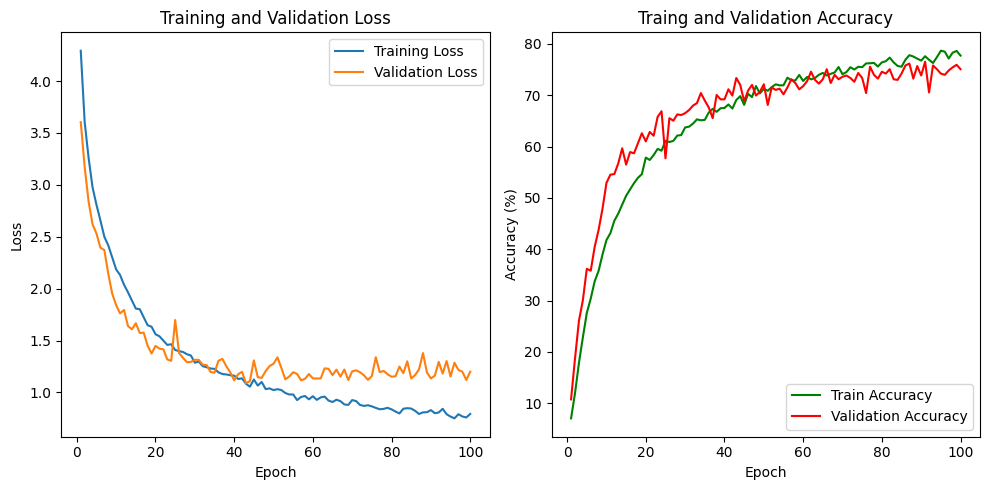

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the CSV file
csv_file = 'few_shot_learning_metrics.csv'
df = pd.read_csv(csv_file)

# Extract the data from the DataFrame
epoch = df['Epoch']
train_losses = df['Training Loss']
valid_losses = df['Validation Loss']
train_accuracies = df['Training Accuracy']
valid_accuracies = df['Validation Accuracy']

# Create subplots
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch, train_losses, label='Training Loss')
plt.plot(epoch, valid_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epoch, train_accuracies, label='Train Accuracy', color='green')
plt.plot(epoch, valid_accuracies, label='Validation Accuracy', color='red')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Traing and Validation Accuracy')

plt.tight_layout()
plt.show()



In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for support_set, query_set in validloader:
      support_set, query_set = support_set.to(device), query_set.to(device)
      embeddings = model(support_set)
      _, predicted = torch.max(embeddings, 1)
      total += query_set.size(0)
      correct += (predicted == query_set).sum().item()
print('Accuracy: %d %%' % (100 * correct / total))


Accuracy: 75 %


In [ ]:
# Save the trained model to a file
torch.save(model, './few_shot_learning_model.pth')


In [ ]:
# Create an instance of the CNNModel
model = CNNModel()

# Load the trained model's state dictionary

model = torch.load('few_shot_learning_model.pth').to(device)

model.state_dict()

# Switch the model to evaluation mode
model.eval()


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

In [15]:
# Assuming you have already loaded the model
model = torch.load('few_shot_learning_model.pth').to(device)

# Print the model architecture to see the layers and attributes
print(model)


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)


In [16]:
# Assuming you have already loaded the model
model = torch.load('few_shot_learning_model.pth').to(device)

# Access the number of output features in the final classification layer (fc2)
num_classes = model.fc2.out_features

# Print the number of classes
print("Number of classes:", num_classes)


Number of classes: 102


In [17]:
# Load the mapping from category names to labels
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Assuming you have already loaded the model and accessed the number of classes
model = torch.load('few_shot_learning_model.pth').to(device)
num_classes = model.fc2.out_features

# Print out all the class names
for class_idx in range(num_classes):
    class_name = cat_to_name.get(str(class_idx), 'Unknown')
    print(f"Class {class_idx}: {class_name}")


Class 0: Unknown
Class 1: pink primrose
Class 2: hard-leaved pocket orchid
Class 3: canterbury bells
Class 4: sweet pea
Class 5: english marigold
Class 6: tiger lily
Class 7: moon orchid
Class 8: bird of paradise
Class 9: monkshood
Class 10: globe thistle
Class 11: snapdragon
Class 12: colt's foot
Class 13: king protea
Class 14: spear thistle
Class 15: yellow iris
Class 16: globe-flower
Class 17: purple coneflower
Class 18: peruvian lily
Class 19: balloon flower
Class 20: giant white arum lily
Class 21: fire lily
Class 22: pincushion flower
Class 23: fritillary
Class 24: red ginger
Class 25: grape hyacinth
Class 26: corn poppy
Class 27: prince of wales feathers
Class 28: stemless gentian
Class 29: artichoke
Class 30: sweet william
Class 31: carnation
Class 32: garden phlox
Class 33: love in the mist
Class 34: mexican aster
Class 35: alpine sea holly
Class 36: ruby-lipped cattleya
Class 37: cape flower
Class 38: great masterwort
Class 39: siam tulip
Class 40: lenten rose
Class 41: barbe

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


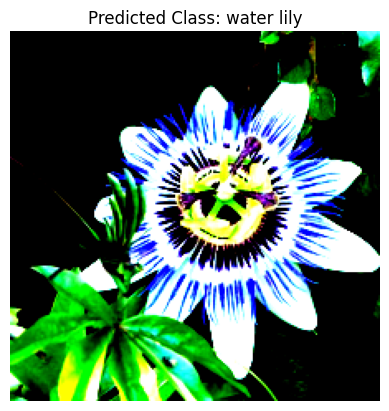

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os 

image_path = "dataset/test/image_00005.jpg"

image = Image.open(image_path)

# Apply the same transformations used during training
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image = transform(image).unsqueeze(0)  # Add a batch dimension

# Move the image to the same device as the model
image = image.to(device)

# Make a prediction using your model
model.eval()
with torch.no_grad():
    output = model(image)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class index to its label
predicted_label = cat_to_name.get(str(predicted_class.item()), 'Unknown')

# Move the image tensor to the CPU for NumPy conversion
image = image.cpu()

# Display the image and its predicted class label
plt.imshow(np.array(image.squeeze().permute(1, 2, 0)))
plt.title(f'Predicted Class: {predicted_label}')
plt.axis('off')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


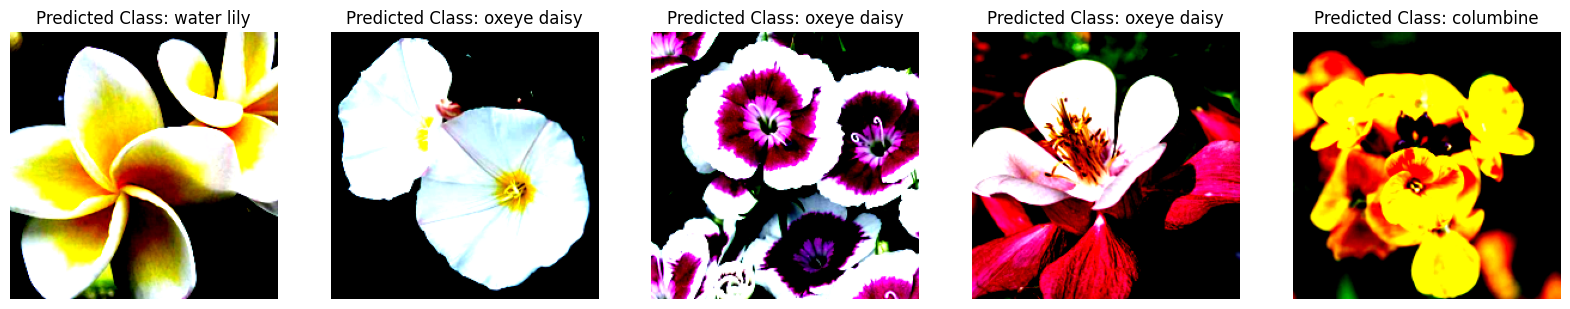

In [20]:
import os
import random

# Define the directory path for the test images
test_dir = 'dataset/test'

# List all the image files in the test directory
image_files = [os.path.join(test_dir, filename) for filename in os.listdir(test_dir) if filename.endswith(('.jpg', '.png', '.jpeg'))]

# Randomly select 5 images
random_images = random.sample(image_files, 5)

# Create a subplot with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Function to display an image with its predicted class
def display_image(image_path, ax):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Apply the same transformations
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)

    _, predicted_class = output.max(1)
    predicted_label = cat_to_name.get(str(predicted_class.item()), 'Unknown')

    image = image.cpu()
    ax.imshow(np.array(image.squeeze().permute(1, 2, 0)))
    ax.set_title(f'Predicted Class: {predicted_label}')
    ax.axis('off')

# Display the randomly selected images side by side
for i, image_path in enumerate(random_images):
    display_image(image_path, axes[i])

plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
def predict(image_path, model_path, topk=5):
    image = Image.open(image_path).convert("RGB")  # Remove '.jpg' and add .convert("RGB")

    # Define the transformation for the input image
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = preprocess(image).unsqueeze(0).to(device)  # Add .to(device)

    # Load the model and send it to the same device
    model = torch.load(model_path).to(device)

    # Ensure the model is in evaluation mode
    model.eval()

    # Forward pass to get probabilities
    with torch.no_grad():
        output = model(image)

    # Calculate probabilities and top class indices
    probs, indices = torch.topk(output, topk)

    # Convert indices to class labels
    classes = [str(idx.item()) for idx in indices[0]]

    return probs[0].cpu().tolist(), classes  # Add .cpu() to move results back to the CPU


./dataset/test/image_03440.jpg


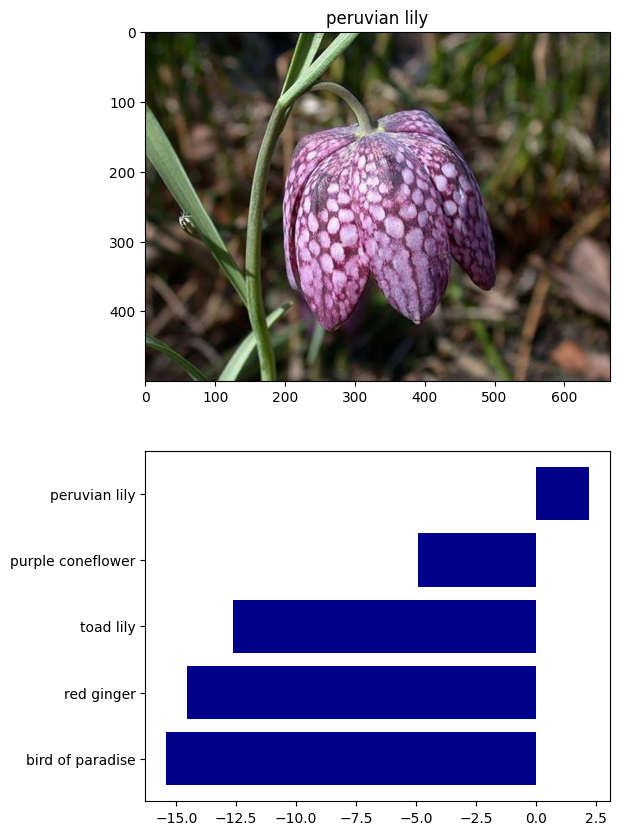

In [ ]:
import os
import random

model_path = 'C:/Users/RZG_TESTER/Documents/GitHub/SC4001-Assignment-2/few_shot_learning_model.pth'
test_dir = data_dir + '/test'

# List all files in the test directory
test_files = []
for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.endswith(".jpg"):
            test_files.append(os.path.join(root, file).replace('\\', '/'))  # Use double backslashes

# Randomly select an image from the test directory
random_image_path = random.choice(test_files)

print(random_image_path)

# Getting prediction
probs, classes = predict(random_image_path, model_path, topk=5)

# Uncomment to check if the class of the flower (as seen from the file path) matches the top one predicted:
# print(classes[0])

# Converting classes to names
names = [cat_to_name[i] for i in classes]

# Creating PIL image
image = Image.open(random_image_path)

# Plotting the random test image and predicted probabilities
f, ax = plt.subplots(2, figsize=(6, 10))

ax[0].imshow(image)
ax[0].set_title(names[0])

y_names = np.arange(len(names))
ax[1].barh(y_names, probs, color='darkblue')
ax[1].set_yticks(y_names)
ax[1].set_yticklabels(names)
ax[1].invert_yaxis()

plt.show()


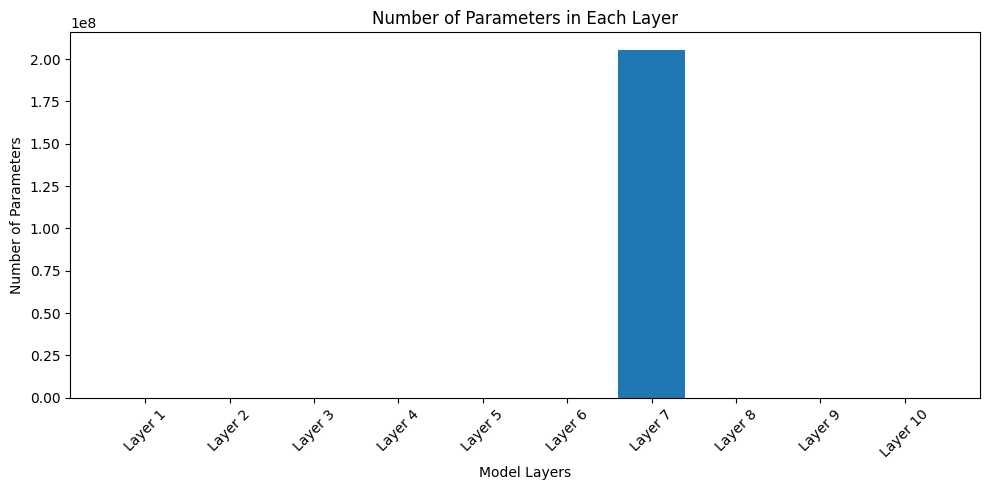

In [ ]:
import matplotlib.pyplot as plt

# Get the model's parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = [p.numel() for p in model_parameters]

# Create labels for each layer
layer_labels = [f'Layer {i}' for i in range(1, len(params) + 1)]

# Create a bar graph
plt.figure(figsize=(10, 5))
plt.bar(layer_labels, params)
plt.xlabel('Model Layers')
plt.ylabel('Number of Parameters')
plt.title('Number of Parameters in Each Layer')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the graph
plt.show()


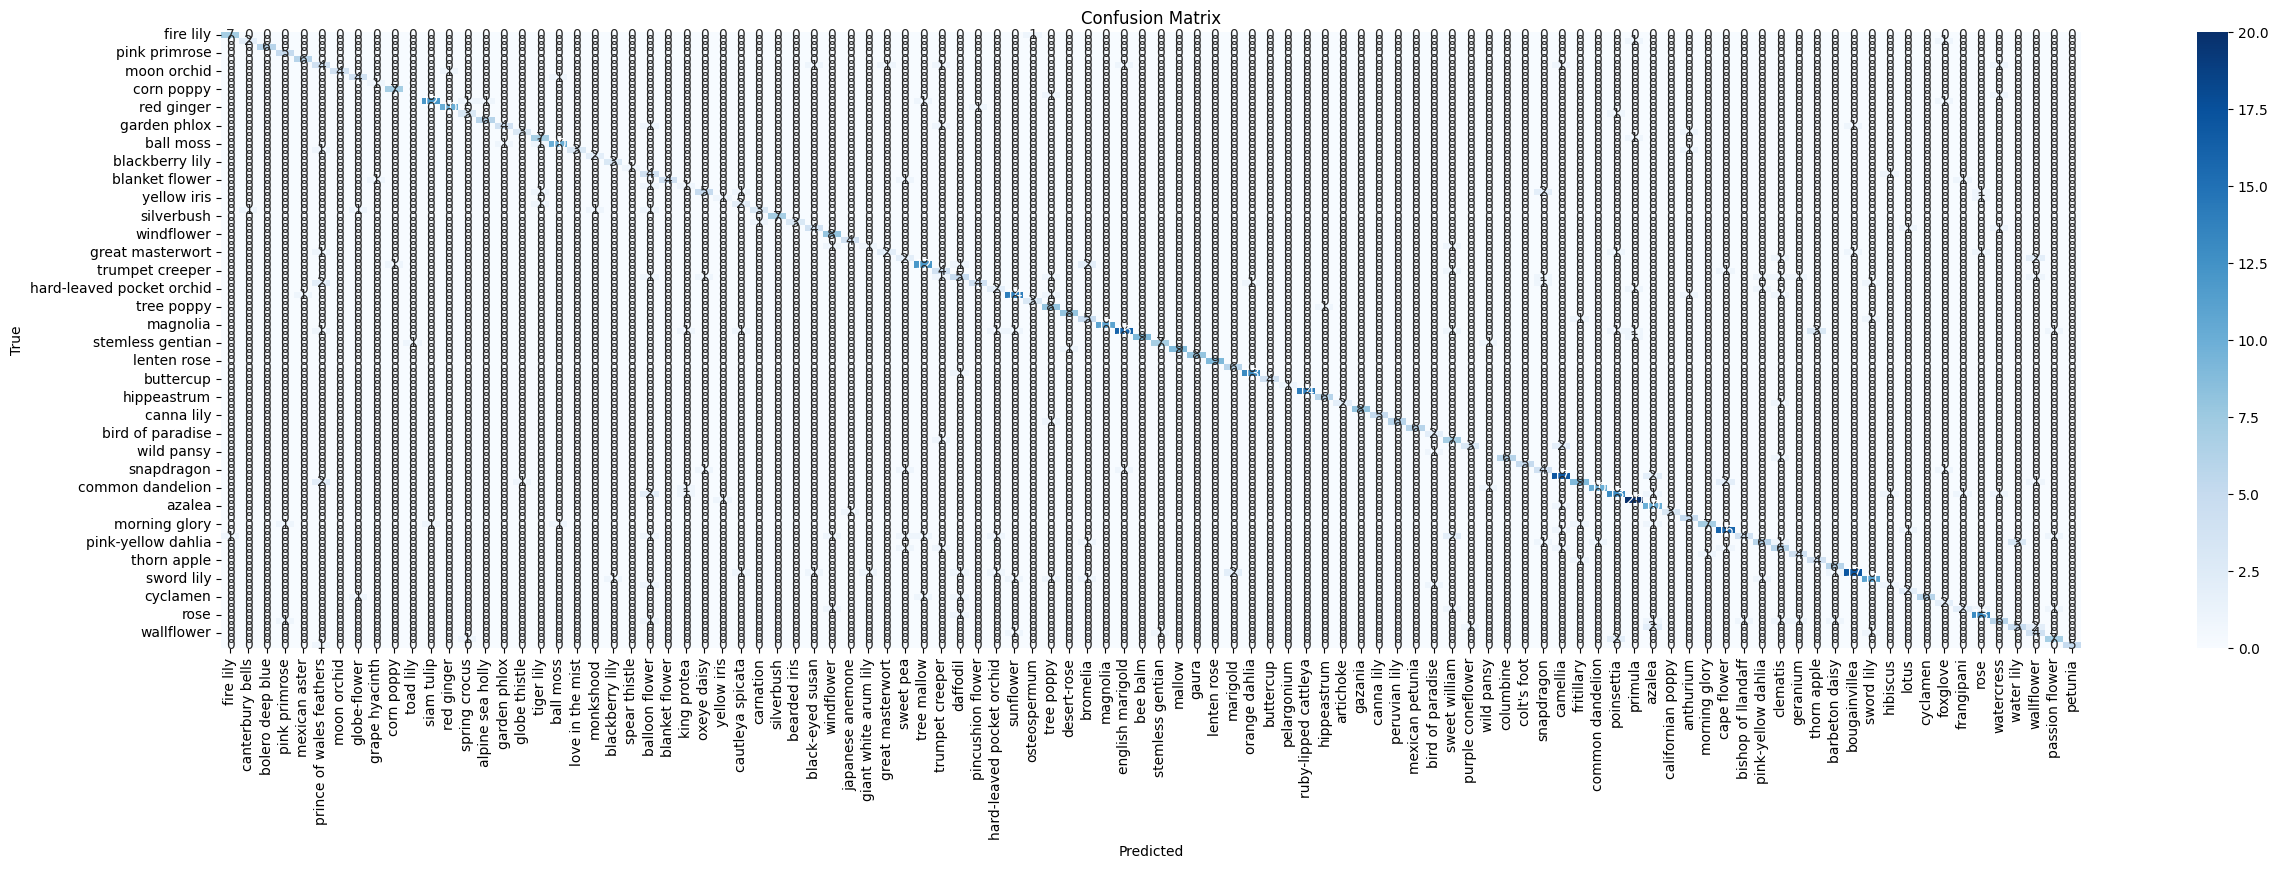

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Initialize variables to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to collect labels
with torch.no_grad():
    for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Convert the confusion matrix to a Pandas DataFrame for visualization
cm_df = pd.DataFrame(cm, index=cat_to_name.values(), columns=cat_to_name.values())

# Create a heatmap of the confusion matrix
plt.figure(figsize=(30, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
writer.close()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs


ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.